In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import re
import os

import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from classifier import Classifier
from constants import *

In [14]:
csvs = sorted(os.listdir(INPUTS_PATH))
csvs

['2014-final.xlsx - Sheet1.csv',
 '2015-final.xlsx - Sheet1.csv',
 '2016-final.xlsx - Total counts.csv',
 '2017-final.xlsx - 2017 LIS phytoplankton count.csv',
 '2018-Final Report Data.xlsx - 2018 LIS phytoplankton count.csv',
 'LIS_2019-Phytoplankton_Final Report Data.xlsx - 2019 LIS phytoplankton count.csv',
 'LIS_2020-Phytoplankton_Final Report Data.xlsx - 2020 LIS phytoplankton count.csv',
 'LIS_2021-Phytoplankton_Final Report Data.xlsx - 2021 LIS phytoplankton count.csv']

In [15]:
def percentages(df, column):
    df = df.groupby([column], as_index=False)['Totals'].sum()
    df['Percentages'] = round(((df['Totals'] / df['Totals'].sum()) * 100), 1)
    df = df.loc[(df[column] != "") & (df['Totals'] != 0)]
    return df

In [16]:
season2month = {
    'Winter': ['January', 'February', 'March'],
    'Spring': ['April', 'May', 'June'],
    'Summer': ['July', 'August', 'September'],
    'Fall': ['October', 'November', 'December']
}

## 1. What fraction of the total cell number are mixotrophs and what fraction are phytoplankton (strict phototrophs)? 
### For this question, we could also aggregate the data by adding all the surface samples together on a given sampling day and comparing that to the bottom samples.  Or we could see if the fraction of mixoplankton changes as we go from West to East (stations A to K), because there is a big decrease in the amount of nutrients like nitrogen that are added to the Sound as you get farther East (away from NYC), so there might be more of a need for mixoplankton to get their nitrogen by eating as you go to the East.

In [17]:
def seasonal_trophic_strategy_per_station(csv_name, season):

    # Get months corresponding to season
    months = season2month.get(season)
    
    # Clean data
    classified = Classifier(csv_name)
    by_station_SB = classified.add_multiheader(classified.all_classified)
    removed_columns = by_station_SB.loc[:, by_station_SB.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species'])].copy()
    removed_columns.columns = removed_columns.columns.get_level_values(2)
    other_columns = by_station_SB.loc[:, ~by_station_SB.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species', 'Totals'])]
    other_columns = other_columns.loc[:, other_columns.columns.get_level_values(0).isin(months)]
    other_columns.columns = other_columns.columns.get_level_values(1)
    other_columns = other_columns.groupby(other_columns.columns.str[:3], axis=1).sum()
    by_station_SB = pd.concat([removed_columns, other_columns ], axis=1)
    by_station_SB.loc[by_station_SB['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    by_station_SB = by_station_SB.replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton']).drop(['Phylum', 'Genus', 'Species'], axis=1).replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton']).groupby('Status').sum()
    by_station_SB.index.name = None
    by_station_SB = by_station_SB.transpose().reset_index().rename(columns={"index": "Station"})
    by_station_SB['Totals'] = by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].sum(axis=1)
    by_station_SB[['Mixoplankton %', "Phytoplankton %", "Protozooplankton %"]] = by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].div(by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].sum(axis=1), axis=0) * 100
    
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'
    
    # Plot Stacked Bar Chart
    ax = by_station_SB.plot(kind='bar', x='Station', y=['Mixoplankton %', 'Phytoplankton %', 'Protozooplankton %'], stacked=True, figsize=(15, 7), xlabel="Stations", ylabel="Trophic Strategy Percentages", legend=True, title=f"Trophic Strategy per Station (S/B) in LIS in {season} {year}", edgecolor='black', width=.9)
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{bar.get_height():.1f}%' if bar.get_height() > 0 else '' for bar in container], label_type='center', fmt='%.1f%%', color='black')
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
    ax.set_yticklabels([f'{int(tick)}%' for tick in ax.get_yticks()])
    plt.xticks(rotation=0)
        
    plt.show()
    display(by_station_SB)

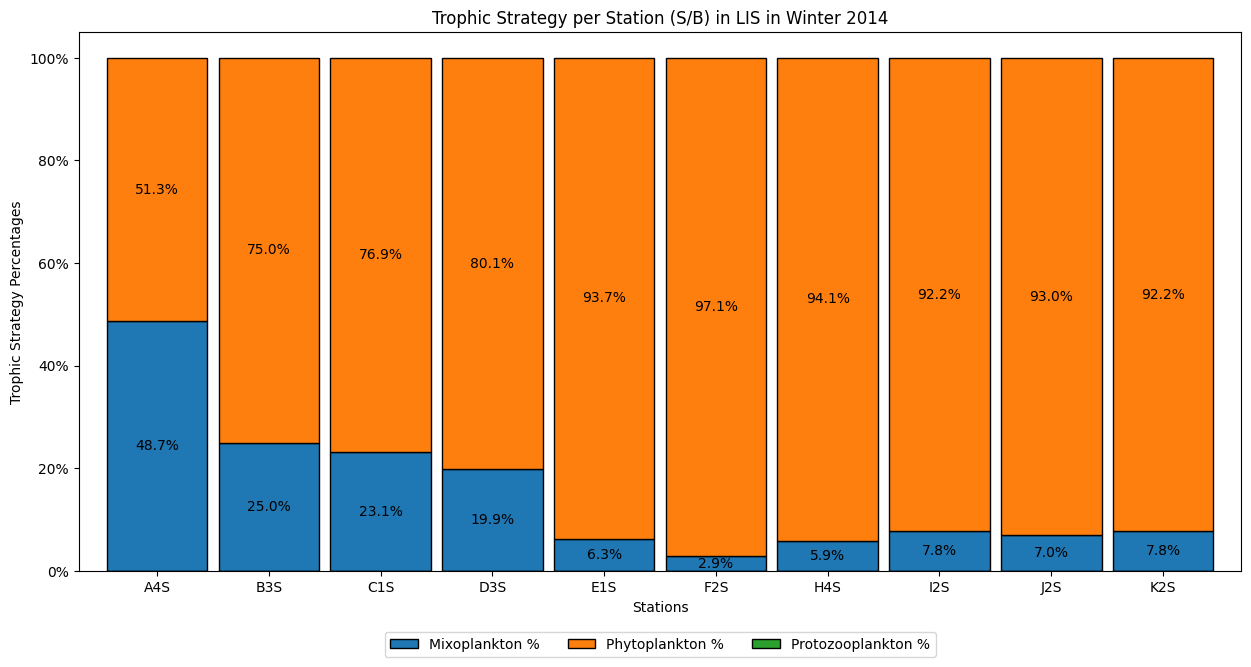

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0     A4S       1636800        1723260                 0  3360060   
1     B3S        595452        1786312                 0  2381764   
2     C1S        638000        2121548                 0  2759548   
3     D3S        580800        2344980                 0  2925780   
4     E1S        110836        1637504                 0  1748340   
5     F2S         36652        1217964                 0  1254616   
6     H4S        155452        2462680                 0  2618132   
7     I2S        124036        1466608                 0  1590644   
8     J2S        140756        1856096                 0  1996852   
9     K2S         51260         603592                 0   654852   

   Mixoplankton %  Phytoplankton %  Protozooplankton %  
0       48.713416        51.286584                 0.0  
1       25.000462        74.999538                 0.0  
2       23.119728        76.880272                 0.0  
3       19.851117        80.148883                 0.0  
4        6.339499        93.660501                 0.0  
5        2.921372        97.078628                 0.0  
6        5.937516        94.062484                 0.0  
7        7.797848        92.202152                 0.0  
8        7.048895        92.951105                 0.0  
9        7.827723        92.172277                 0.0

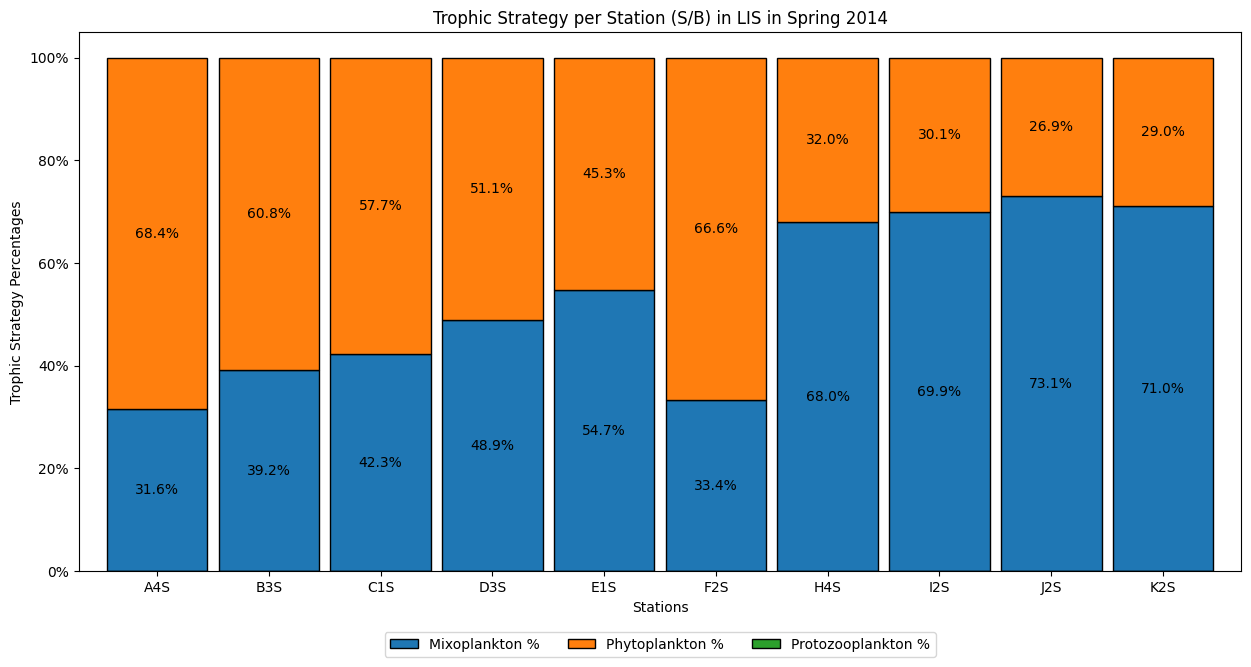

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0     A4S       1739136        3765156                 0  5504292   
1     B3S       1999008        3097380                 0  5096388   
2     C1S       1506252        2057484                 0  3563736   
3     D3S       2230756        2333100                 0  4563856   
4     E1S       1865600        1547084                 0  3412684   
5     F2S        853512        1704956                 0  2558468   
6     H4S       2069018         972185                 0  3041203   
7     I2S       1047156         451572                 0  1498728   
8     J2S       1033956         381084                 0  1415040   
9     K2S        852060         347292                 0  1199352   

   Mixoplankton %  Phytoplankton %  Protozooplankton %  
0       31.595998        68.404002                 0.0  
1       39.224015        60.775985                 0.0  
2       42.266094        57.733906                 0.0  
3       48.878755        51.121245                 0.0  
4       54.666649        45.333351                 0.0  
5       33.360277        66.639723                 0.0  
6       68.032880        31.967120                 0.0  
7       69.869649        30.130351                 0.0  
8       73.069030        26.930970                 0.0  
9       71.043363        28.956637                 0.0

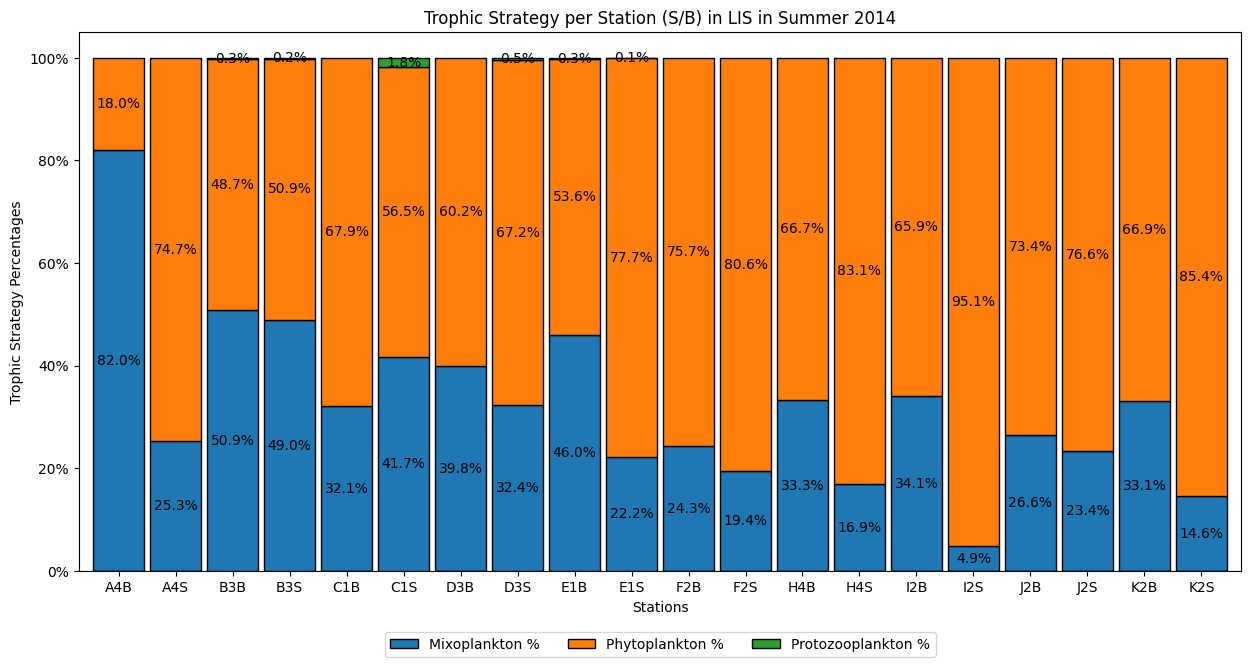

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        720104         158180                 0   878284   
1      A4S       1170356        3456772                 0  4627128   
2      B3B        243408         232892              1452   477752   
3      B3S        818400         850564              2904  1671868   
4      C1B        186208         394328                 0   580536   
5      C1S        508904         690668             22000  1221572   
6      D3B        146652         221364                 0   368016   
7      D3S        626252        1300772              8800  1935824   
8      E1B        202400         235884              1452   439736   
9      E1S        349052        1218580              1452  1569084   
10     F2B        124652         388388                 0   513040   
11     F2S        328460        1360832                 0  1689292   
12     H4B        133452         266816                 0   400268   
13     H4S        360756        1769988                 0  2130744   
14     I2B        177452         342320                 0   519772   
15     I2S        108504        2122076                 0  2230580   
16     J2B        244904         677336                 0   922240   
17     J2S        243452         798996                 0  1042448   
18     K2B        200860         406032                 0   606892   
19     K2S         99616         583440                 0   683056   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        81.989880        18.010120            0.000000  
1        25.293357        74.706643            0.000000  
2        50.948609        48.747467            0.303923  
3        48.951233        50.875069            0.173698  
4        32.075186        67.924814            0.000000  
5        41.659763        56.539279            1.800958  
6        39.849354        60.150646            0.000000  
7        32.350668        67.194745            0.454587  
8        46.027617        53.642185            0.330198  
9        22.245590        77.661872            0.092538  
10       24.296741        75.703259            0.000000  
11       19.443649        80.556351            0.000000  
12       33.340662        66.659338            0.000000  
13       16.930987        83.069013            0.000000  
14       34.140354        65.859646            0.000000  
15        4.864385        95.135615            0.000000  
16       26.555344        73.444656            0.000000  
17       23.353875        76.646125            0.000000  
18       33.096498        66.903502            0.000000  
19       14.583870        85.416130            0.000000

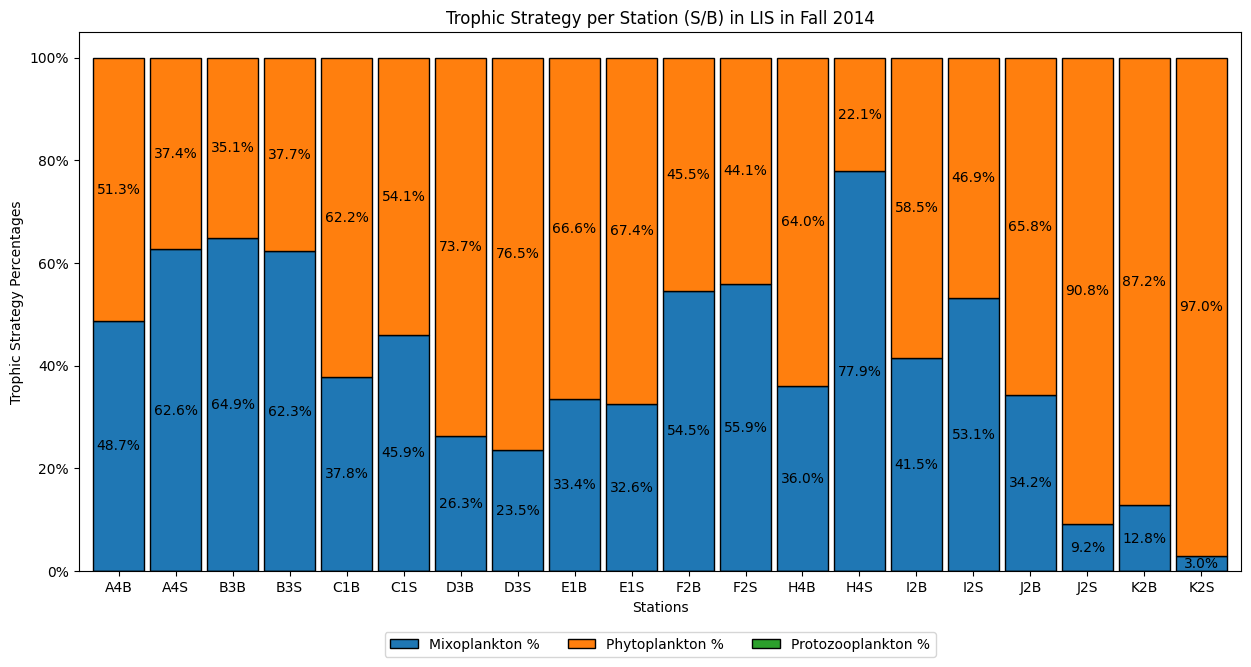

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B        224400         236016                 0  460416   
1      A4S        356400         212476                 0  568876   
2      B3B        422400         228624                 0  651024   
3      B3S        357852         216920                 0  574772   
4      C1B        272800         448712                 0  721512   
5      C1S        230252         270996                 0  501248   
6      D3B        118800         332816                 0  451616   
7      D3S         63052         205040                 0  268092   
8      E1B        139304         277156                 0  416460   
9      E1S         80652         166980                 0  247632   
10     F2B        256652         214074                 0  470726   
11     F2S        265408         209484                 0  474892   
12     H4B        107052         190564                 0  297616   
13     H4S        494252         140624                 0  634876   
14     I2B        136400         192104                 0  328504   
15     I2S        237556         209528                 0  447084   
16     J2B         74800         143660                 0  218460   
17     J2S         20504         203544                 0  224048   
18     K2B         33704         230120                 0  263824   
19     K2S          7304         234476                 0  241780   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        48.738532        51.261468                 0.0  
1        62.649857        37.350143                 0.0  
2        64.882401        35.117599                 0.0  
3        62.259818        37.740182                 0.0  
4        37.809489        62.190511                 0.0  
5        45.935744        54.064256                 0.0  
6        26.305534        73.694466                 0.0  
7        23.518792        76.481208                 0.0  
8        33.449551        66.550449                 0.0  
9        32.569296        67.430704                 0.0  
10       54.522589        45.477411                 0.0  
11       55.888076        44.111924                 0.0  
12       35.969840        64.030160                 0.0  
13       77.850163        22.149837                 0.0  
14       41.521564        58.478436                 0.0  
15       53.134534        46.865466                 0.0  
16       34.239678        65.760322                 0.0  
17        9.151610        90.848390                 0.0  
18       12.775183        87.224817                 0.0  
19        3.020928        96.979072                 0.0

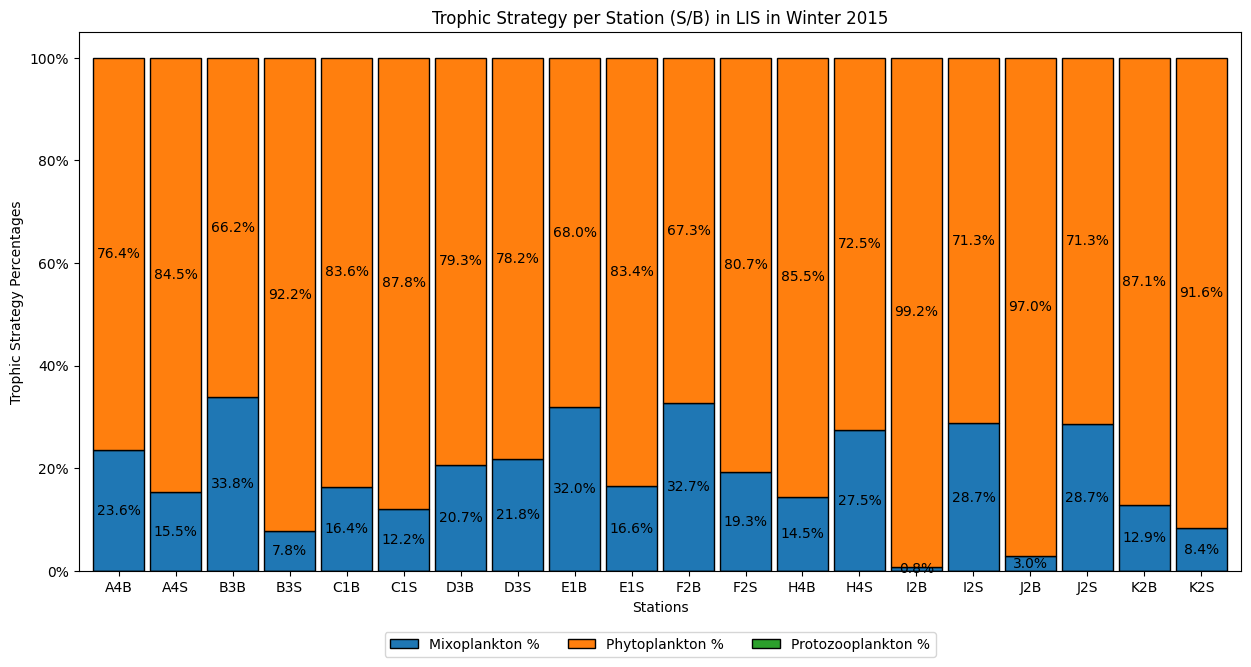

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        242000         784652                 0  1026652   
1      A4S        167200         912255                 0  1079455   
2      B3B        259600         507452                 0   767052   
3      B3S         44000         522104                 0   566104   
4      C1B        146652         745052                 0   891704   
5      C1S         61600         444400                 0   506000   
6      D3B        193600         740653                 0   934253   
7      D3S        184800         662860                 0   847660   
8      E1B        220000         467852                 0   687852   
9      E1S        123200         620356                 0   743556   
10     F2B        224400         461956                 0   686356   
11     F2S        162800         680460                 0   843260   
12     H4B        220000        1297956                 0  1517956   
13     H4S        134904         356356                 0   491260   
14     I2B          5808         680504                 0   686312   
15     I2S        211200         523468                 0   734668   
16     J2B         51304        1658714                 0  1710018   
17     J2S        192104         478016                 0   670120   
18     K2B         88000         596816                 0   684816   
19     K2S         29304         319572                 0   348876   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        23.571765        76.428235                 0.0  
1        15.489298        84.510702                 0.0  
2        33.843859        66.156141                 0.0  
3         7.772423        92.227577                 0.0  
4        16.446265        83.553735                 0.0  
5        12.173913        87.826087                 0.0  
6        20.722438        79.277562                 0.0  
7        21.801194        78.198806                 0.0  
8        31.983624        68.016376                 0.0  
9        16.569028        83.430972                 0.0  
10       32.694403        67.305597                 0.0  
11       19.306027        80.693973                 0.0  
12       14.493174        85.506826                 0.0  
13       27.460815        72.539185                 0.0  
14        0.846262        99.153738                 0.0  
15       28.747679        71.252321                 0.0  
16        3.000202        96.999798                 0.0  
17       28.667104        71.332896                 0.0  
18       12.850167        87.149833                 0.0  
19        8.399546        91.600454                 0.0

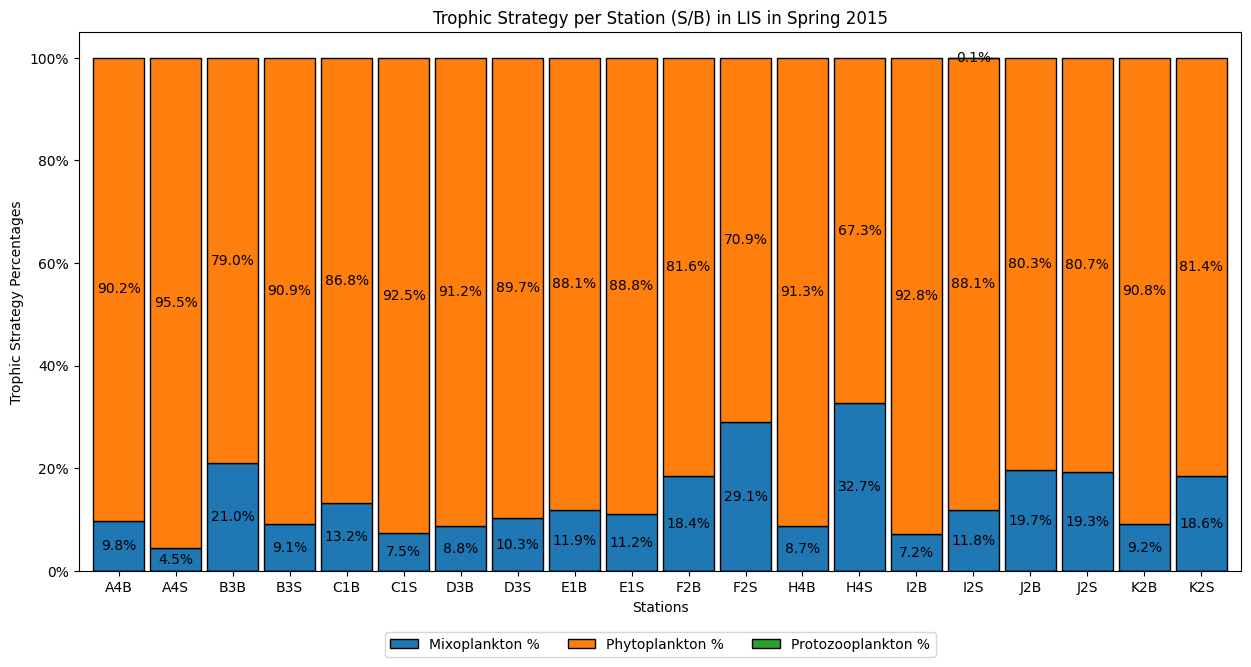

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        872652        8024060                 0  8896712   
1      A4S        423852        8924564                 0  9348416   
2      B3B       1377200        5177304                 0  6554504   
3      B3S        479600        4790060                 0  5269660   
4      C1B        674080        4436564                 0  5110644   
5      C1S        466400        5780104                 0  6246504   
6      D3B        397452        4136000                 0  4533452   
7      D3S        435600        3801556                 0  4237156   
8      E1B        462000        3407052                 0  3869052   
9      E1S        343200        2719159                 0  3062359   
10     F2B        888756        3935008                 0  4823764   
11     F2S       1029600        2505008                 0  3534608   
12     H4B        228800        2395009                 0  2623809   
13     H4S        416504         857912                 0  1274416   
14     I2B        265452        3415852                 0  3681304   
15     I2S        303600        2257112              1452  2562164   
16     J2B        432652        1762904                 0  2195556   
17     J2S        335852        1403600                 0  1739452   
18     K2B        154000        1522312                 0  1676312   
19     K2S        321200        1405052                 0  1726252   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         9.808702        90.191298            0.000000  
1         4.533945        95.466055            0.000000  
2        21.011506        78.988494            0.000000  
3         9.101156        90.898844            0.000000  
4        13.189727        86.810273            0.000000  
5         7.466577        92.533423            0.000000  
6         8.767094        91.232906            0.000000  
7        10.280481        89.719519            0.000000  
8        11.940910        88.059090            0.000000  
9        11.207047        88.792953            0.000000  
10       18.424533        81.575467            0.000000  
11       29.129114        70.870886            0.000000  
12        8.720147        91.279853            0.000000  
13       32.681950        67.318050            0.000000  
14        7.210814        92.789186            0.000000  
15       11.849359        88.093971            0.056671  
16       19.705806        80.294194            0.000000  
17       19.307920        80.692080            0.000000  
18        9.186834        90.813166            0.000000  
19       18.606785        81.393215            0.000000

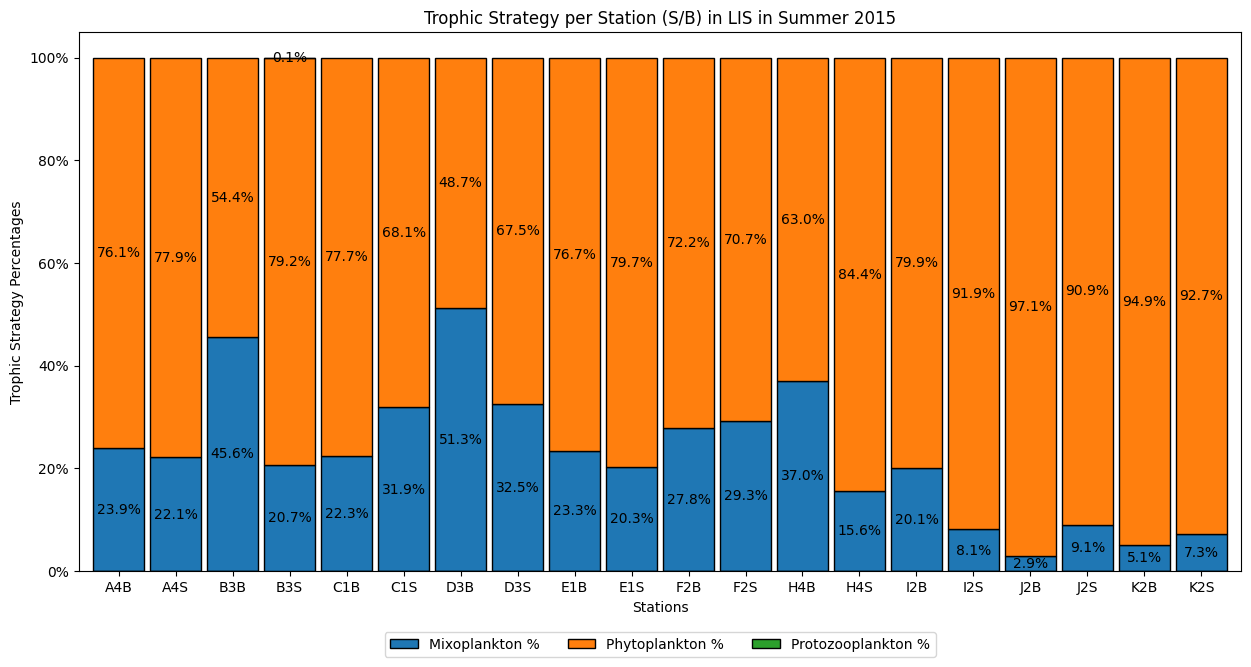

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         88000         280104                 0   368104   
1      A4S        426800        1501852                 0  1928652   
2      B3B        259160         309760                 0   568920   
3      B3S        896104        3429055              4400  4329559   
4      C1B         88880         309320                 0   398200   
5      C1S        885852        1893452                 0  2779304   
6      D3B        353320         335412                 0   688732   
7      D3S        466400         966504                 0  1432904   
8      E1B        112640         370422                 0   483062   
9      E1S        388652        1525304                 0  1913956   
10     F2B        118800         308340                 0   427140   
11     F2S        484000        1168860                 0  1652860   
12     H4B        265888         452707                 0   718595   
13     H4S        112904         608564                 0   721468   
14     I2B        213400         846067                 0  1059467   
15     I2S         70400         797764                 0   868164   
16     J2B         17600         582076                 0   599676   
17     J2S         66000         662904                 0   728904   
18     K2B         22000         412104                 0   434104   
19     K2S         23408         297660                 0   321068   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        23.906287        76.093713            0.000000  
1        22.129446        77.870554            0.000000  
2        45.552978        54.447022            0.000000  
3        20.697350        79.201023            0.101627  
4        22.320442        77.679558            0.000000  
5        31.873160        68.126840            0.000000  
6        51.300070        48.699930            0.000000  
7        32.549285        67.450715            0.000000  
8        23.317918        76.682082            0.000000  
9        20.306214        79.693786            0.000000  
10       27.812895        72.187105            0.000000  
11       29.282577        70.717423            0.000000  
12       37.001092        62.998908            0.000000  
13       15.649204        84.350796            0.000000  
14       20.142204        79.857796            0.000000  
15        8.109067        91.890933            0.000000  
16        2.934918        97.065082            0.000000  
17        9.054690        90.945310            0.000000  
18        5.067910        94.932090            0.000000  
19        7.290667        92.709333            0.000000

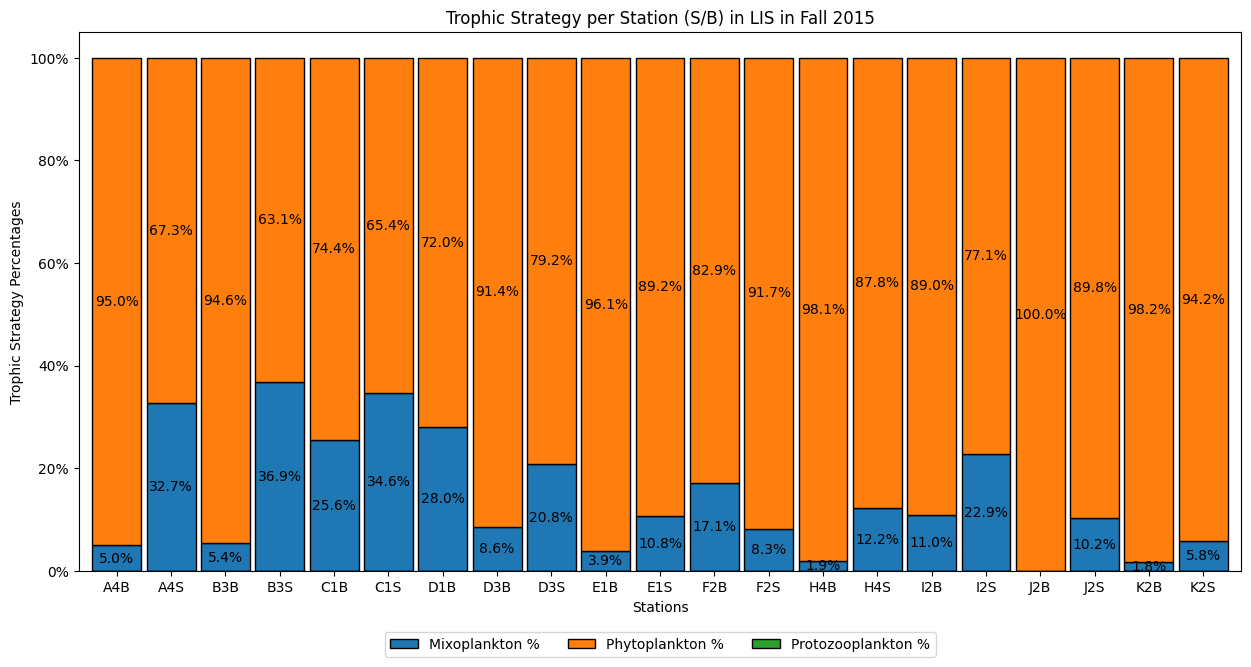

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         44000         837364                 0   881364   
1      A4S        470800         967780                 0  1438580   
2      B3B         35200         620224                 0   655424   
3      B3S        463452         793144                 0  1256596   
4      C1B        184800         536712                 0   721512   
5      C1S        431200         813736                 0  1244936   
6      D1B         88000         225852                 0   313852   
7      D3B         30800         325556                 0   356356   
8      D3S        316800        1206920                 0  1523720   
9      E1B         23452         583616                 0   607068   
10     E1S        107052         888712                 0   995764   
11     F2B         98252         476520                 0   574772   
12     F2S         52800         585068                 0   637868   
13     H4B          8800         448668                 0   457468   
14     H4S         52800         378312                 0   431112   
15     I2B         35200         284460                 0   319660   
16     I2S        119680         403855                 0   523535   
17     J2B             0         316712                 0   316712   
18     J2S         37532         328660                 0   366192   
19     K2B          1452          80565                 0    82017   
20     K2S         10252         166980                 0   177232   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         4.992262        95.007738                 0.0  
1        32.726717        67.273283                 0.0  
2         5.370569        94.629431                 0.0  
3        36.881543        63.118457                 0.0  
4        25.612880        74.387120                 0.0  
5        34.636319        65.363681                 0.0  
6        28.038693        71.961307                 0.0  
7         8.643042        91.356958                 0.0  
8        20.791221        79.208779                 0.0  
9         3.863159        96.136841                 0.0  
10       10.750740        89.249260                 0.0  
11       17.094083        82.905917                 0.0  
12        8.277575        91.722425                 0.0  
13        1.923632        98.076368                 0.0  
14       12.247397        87.752603                 0.0  
15       11.011700        88.988300                 0.0  
16       22.859981        77.140019                 0.0  
17        0.000000       100.000000                 0.0  
18       10.249268        89.750732                 0.0  
19        1.770365        98.229635                 0.0  
20        5.784508        94.215492                 0.0

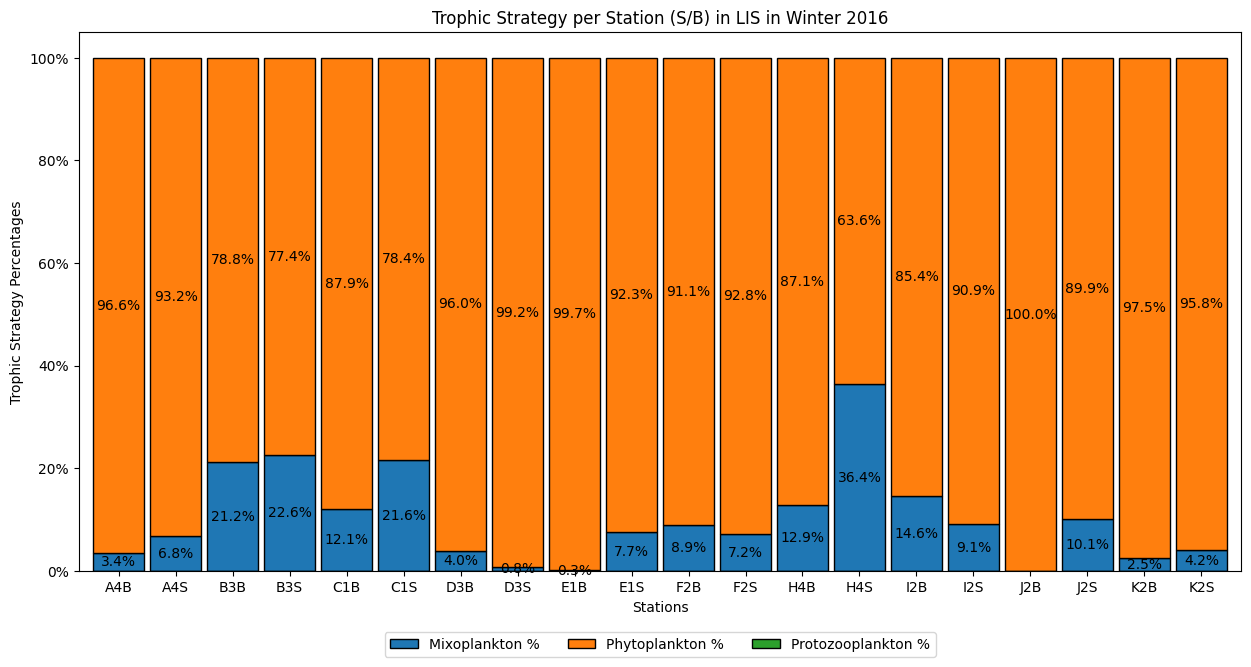

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         35200         987008                 0  1022208   
1      A4S         42504         579260                 0   621764   
2      B3B        120252         447216                 0   567468   
3      B3S        105600         362252                 0   467852   
4      C1B        118800         862356                 0   981156   
5      C1S         96800         351868                 0   448668   
6      D3B         36652         884312                 0   920964   
7      D3S          2904         376860                 0   379764   
8      E1B          1452         523512                 0   524964   
9      E1S         23452         281512                 0   304964   
10     F2B         63052         645260                 0   708312   
11     F2S         41052         529364                 0   570416   
12     H4B         73304         495616                 0   568920   
13     H4S        127600         222816                 0   350416   
14     I2B         93852         549912                 0   643764   
15     I2S         88000         878460                 0   966460   
16     J2B             0         740520                 0   740520   
17     J2S         52800         469172                 0   521972   
18     K2B          8800         343024                 0   351824   
19     K2S         17600         403260                 0   420860   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         3.443526        96.556474                 0.0  
1         6.836034        93.163966                 0.0  
2        21.190975        78.809025                 0.0  
3        22.571240        77.428760                 0.0  
4        12.108166        87.891834                 0.0  
5        21.574973        78.425027                 0.0  
6         3.979743        96.020257                 0.0  
7         0.764685        99.235315                 0.0  
8         0.276590        99.723410                 0.0  
9         7.690088        92.309912                 0.0  
10        8.901727        91.098273                 0.0  
11        7.196853        92.803147                 0.0  
12       12.884764        87.115236                 0.0  
13       36.413862        63.586138                 0.0  
14       14.578634        85.421366                 0.0  
15        9.105395        90.894605                 0.0  
16        0.000000       100.000000                 0.0  
17       10.115485        89.884515                 0.0  
18        2.501251        97.498749                 0.0  
19        4.181913        95.818087                 0.0

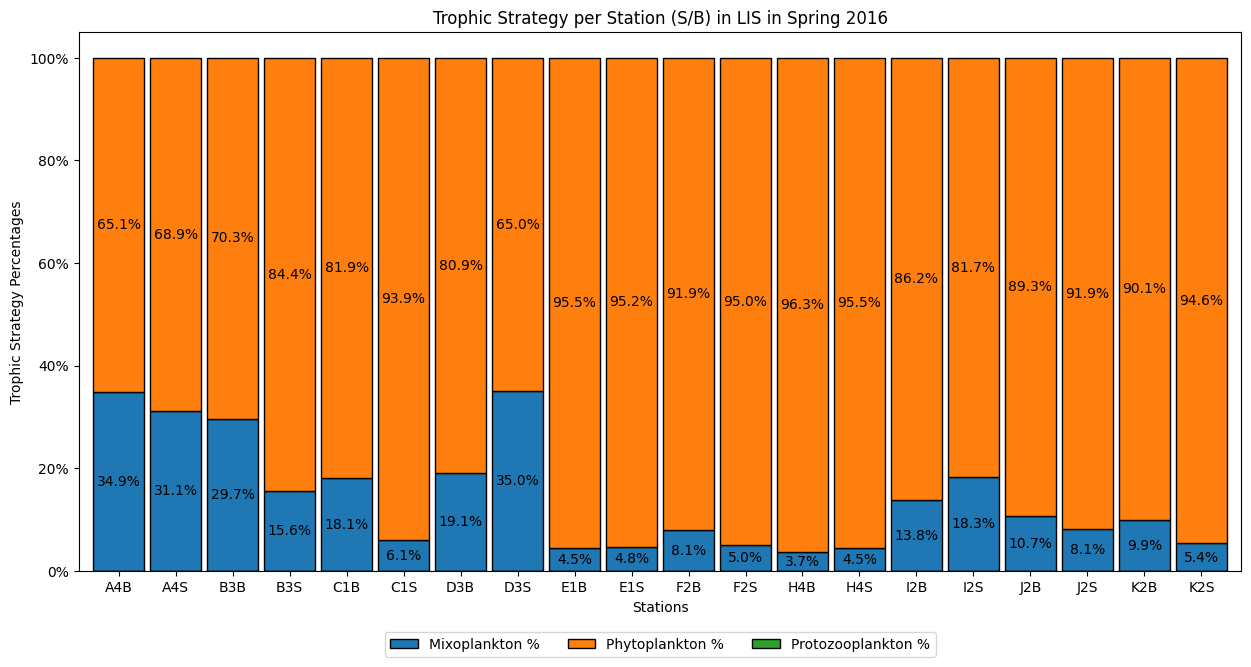

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        211200         394460                 0   605660   
1      A4S        457600        1013408                 0  1471008   
2      B3B        274252         649572                 0   923824   
3      B3S        331452        1793660                 0  2125112   
4      C1B        167200         756712                 0   923912   
5      C1S        139304        2141260                 0  2280564   
6      D3B        243452        1029468                 0  1272920   
7      D3S        639452        1186372                 0  1825824   
8      E1B         52800        1126312                 0  1179112   
9      E1S         41008         821304                 0   862312   
10     F2B        136400        1550164                 0  1686564   
11     F2S         95304        1799468                 0  1894772   
12     H4B         63052        1642608                 0  1705660   
13     H4S         61556        1299408                 0  1360964   
14     I2B        152504         951764                 0  1104268   
15     I2S        123200         548504                 0   671704   
16     J2B        134904        1124860                 0  1259764   
17     J2S         46904         529364                 0   576268   
18     K2B         45452         414964                 0   460416   
19     K2S         39600         698060                 0   737660   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        34.871050        65.128950                 0.0  
1        31.107921        68.892079                 0.0  
2        29.686607        70.313393                 0.0  
3        15.596919        84.403081                 0.0  
4        18.096962        81.903038                 0.0  
5         6.108314        93.891686                 0.0  
6        19.125475        80.874525                 0.0  
7        35.022653        64.977347                 0.0  
8         4.477946        95.522054                 0.0  
9         4.755587        95.244413                 0.0  
10        8.087449        91.912551                 0.0  
11        5.029840        94.970160                 0.0  
12        3.696634        96.303366                 0.0  
13        4.522970        95.477030                 0.0  
14       13.810416        86.189584                 0.0  
15       18.341412        81.658588                 0.0  
16       10.708672        89.291328                 0.0  
17        8.139269        91.860731                 0.0  
18        9.871942        90.128058                 0.0  
19        5.368327        94.631673                 0.0

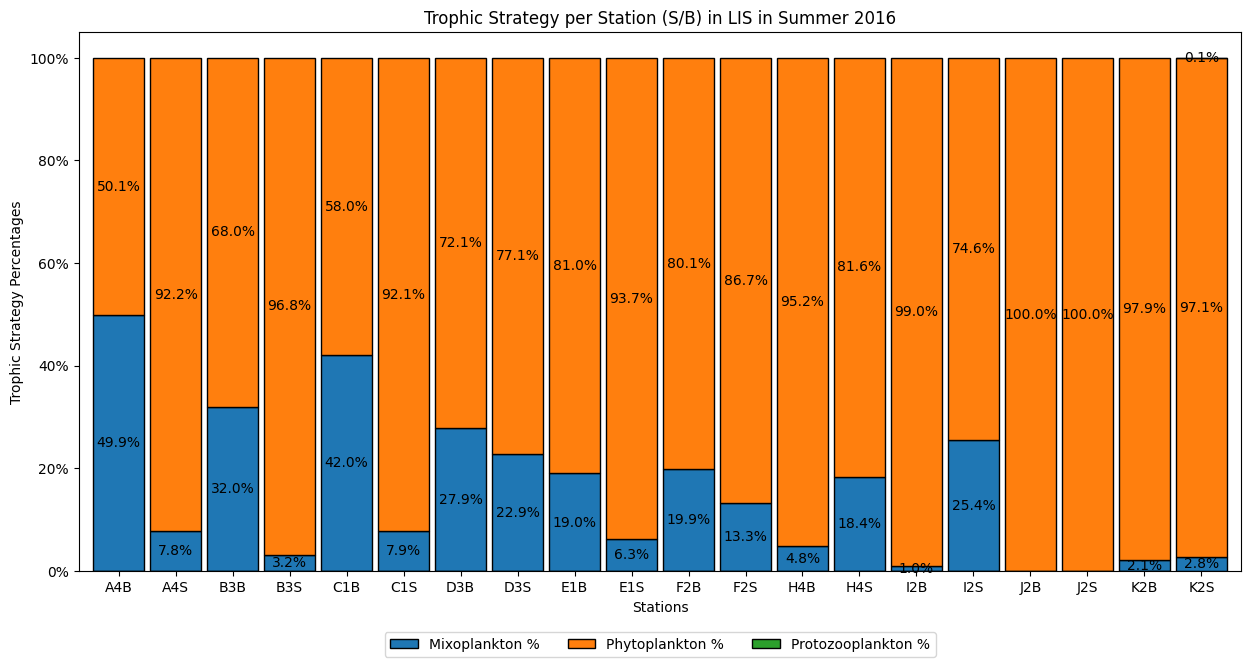

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        484000         486860                 0   970860   
1      A4S        167156        1969572                 0  2136728   
2      B3B        165704         351868                 0   517572   
3      B3S        217008        6567660                 0  6784668   
4      C1B        243452         335632                 0   579084   
5      C1S        470756        5521824                 0  5992580   
6      D3B        133452         344520                 0   477972   
7      D3S        214060         721512                 0   935572   
8      E1B         76252         324790                 0   401042   
9      E1S         41052         614416                 0   655468   
10     F2B         90904         366564                 0   457468   
11     F2S        101200         659780                 0   760980   
12     H4B         22000         435424                 0   457424   
13     H4S        167200         742016                 0   909216   
14     I2B         32252        3062180                 0  3094432   
15     I2S        640904        1878624                 0  2519528   
16     J2B             0         284460                 0   284460   
17     J2S             0         346104                 0   346104   
18     K2B         26400        1226632                 0  1253032   
19     K2S         60060        2066328              1452  2127840   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        49.852708        50.147292            0.000000  
1         7.822989        92.177011            0.000000  
2        32.015642        67.984358            0.000000  
3         3.198506        96.801494            0.000000  
4        42.040878        57.959122            0.000000  
5         7.855648        92.144352            0.000000  
6        27.920464        72.079536            0.000000  
7        22.880120        77.119880            0.000000  
8        19.013470        80.986530            0.000000  
9         6.263006        93.736994            0.000000  
10       19.871117        80.128883            0.000000  
11       13.298641        86.701359            0.000000  
12        4.809542        95.190458            0.000000  
13       18.389470        81.610530            0.000000  
14        1.042259        98.957741            0.000000  
15       25.437463        74.562537            0.000000  
16        0.000000       100.000000            0.000000  
17        0.000000       100.000000            0.000000  
18        2.106890        97.893110            0.000000  
19        2.822581        97.109181            0.068238

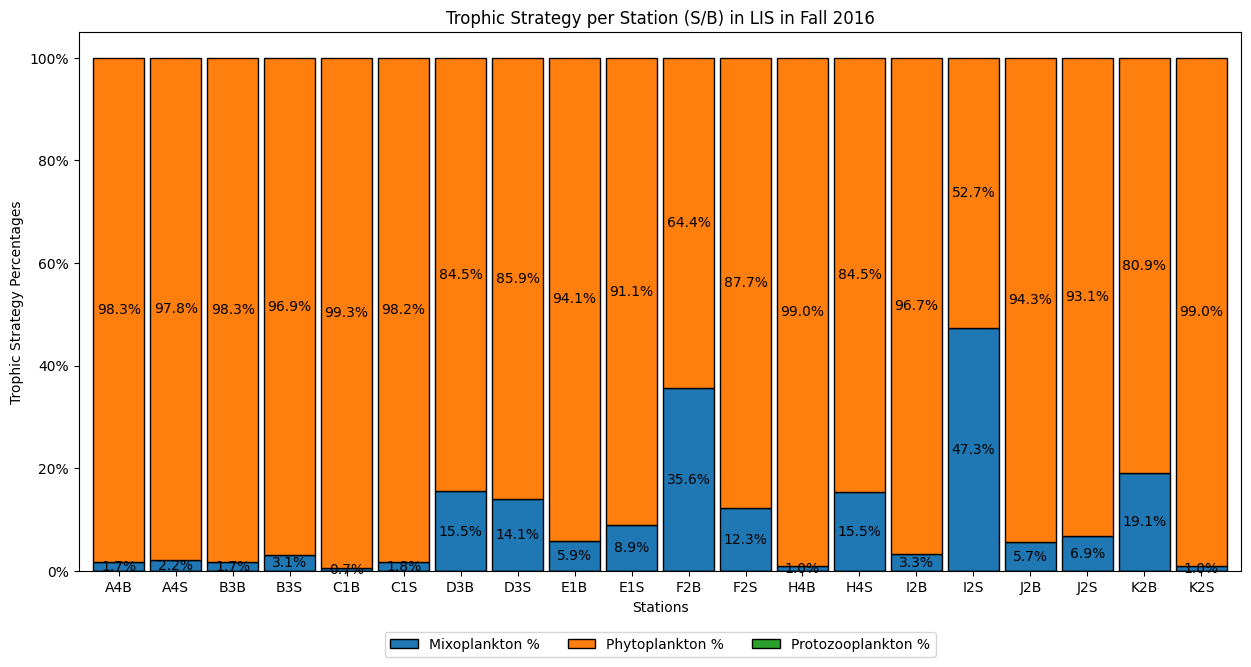

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         40304        2331032                 0  2371336   
1      A4S         32252        1403468                 0  1435720   
2      B3B         27852        1636624                 0  1664476   
3      B3S         45452        1438536                 0  1483988   
4      C1B          7304        1113112                 0  1120416   
5      C1S         16104         871024                 0   887128   
6      D3B         42504         231572                 0   274076   
7      D3S         71808         438416                 0   510224   
8      E1B         10252         162580                 0   172832   
9      E1S         29304         298936                 0   328240   
10     F2B        101200         183084                 0   284284   
11     F2S         35200         252120                 0   287320   
12     H4B          2904         284196                 0   287100   
13     H4S         27852         152196                 0   180048   
14     I2B          8800         255068                 0   263868   
15     I2S        114356         127380                 0   241736   
16     J2B         14652         244026                 0   258678   
17     J2S         17600         237292                 0   254892   
18     K2B         36652         155188                 0   191840   
19     K2S          2904         290180                 0   293084   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         1.699633        98.300367                 0.0  
1         2.246399        97.753601                 0.0  
2         1.673319        98.326681                 0.0  
3         3.062828        96.937172                 0.0  
4         0.651901        99.348099                 0.0  
5         1.815296        98.184704                 0.0  
6        15.508107        84.491893                 0.0  
7        14.073819        85.926181                 0.0  
8         5.931772        94.068228                 0.0  
9         8.927614        91.072386                 0.0  
10       35.598205        64.401795                 0.0  
11       12.251149        87.748851                 0.0  
12        1.011494        98.988506                 0.0  
13       15.469208        84.530792                 0.0  
14        3.335001        96.664999                 0.0  
15       47.306152        52.693848                 0.0  
16        5.664185        94.335815                 0.0  
17        6.904885        93.095115                 0.0  
18       19.105505        80.894495                 0.0  
19        0.990842        99.009158                 0.0

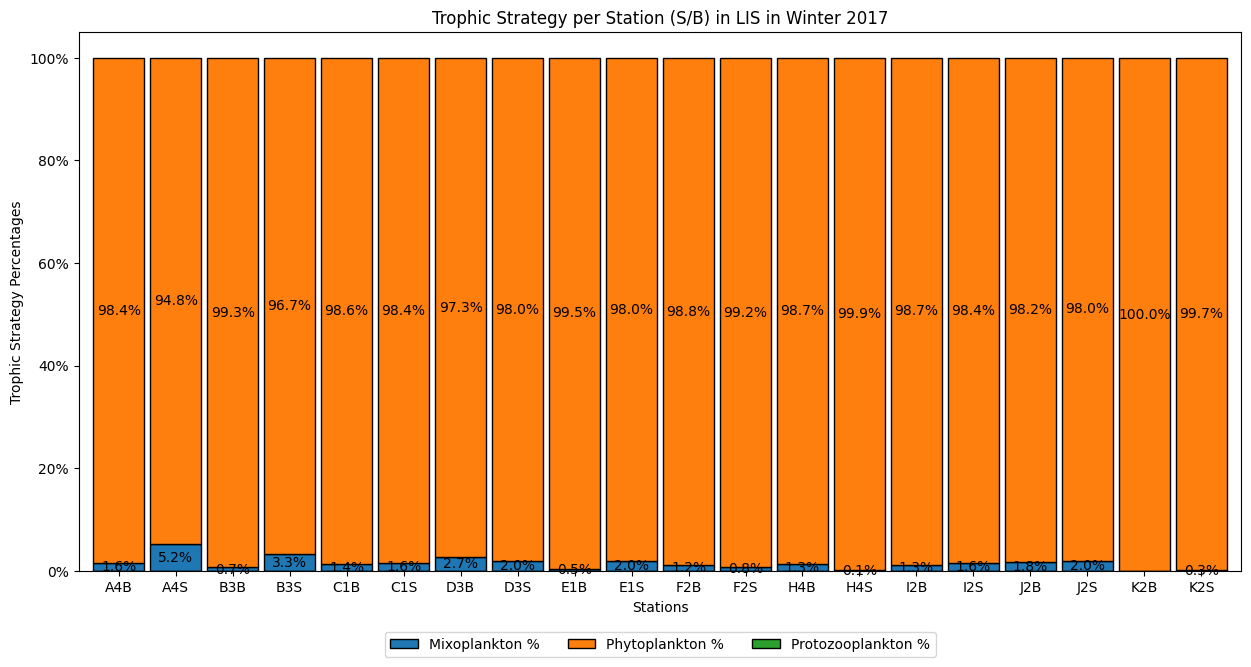

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         52756        3229424                 0  3282180   
1      A4S        114400        2094180                 0  2208580   
2      B3B         20504        2881912                 0  2902416   
3      B3S         58652        1728232                 0  1786884   
4      C1B         42504        2959572                 0  3002076   
5      C1S         27852        1743676                 0  1771528   
6      D3B         76252        2752816                 0  2829068   
7      D3S         46904        2296008                 0  2342912   
8      E1B         11704        2436016                 0  2447720   
9      E1S         32252        1572912                 0  1605164   
10     F2B         26400        2238060                 0  2264460   
11     F2S         13200        1608816                 0  1622016   
12     H4B         30800        2325972                 0  2356772   
13     H4S          2904        2019512                 0  2022416   
14     I2B         17600        1382920                 0  1400520   
15     I2S         11704         715572                 0   727276   
16     J2B         21956        1183380                 0  1205336   
17     J2S         16104         778624                 0   794728   
18     K2B             0         653796                 0   653796   
19     K2S          1452         564476                 0   565928   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         1.607346        98.392654                 0.0  
1         5.179799        94.820201                 0.0  
2         0.706446        99.293554                 0.0  
3         3.282362        96.717638                 0.0  
4         1.415820        98.584180                 0.0  
5         1.572202        98.427798                 0.0  
6         2.695305        97.304695                 0.0  
7         2.001953        97.998047                 0.0  
8         0.478159        99.521841                 0.0  
9         2.009265        97.990735                 0.0  
10        1.165841        98.834159                 0.0  
11        0.813802        99.186198                 0.0  
12        1.306872        98.693128                 0.0  
13        0.143591        99.856409                 0.0  
14        1.256676        98.743324                 0.0  
15        1.609293        98.390707                 0.0  
16        1.821567        98.178433                 0.0  
17        2.026354        97.973646                 0.0  
18        0.000000       100.000000                 0.0  
19        0.256570        99.743430                 0.0

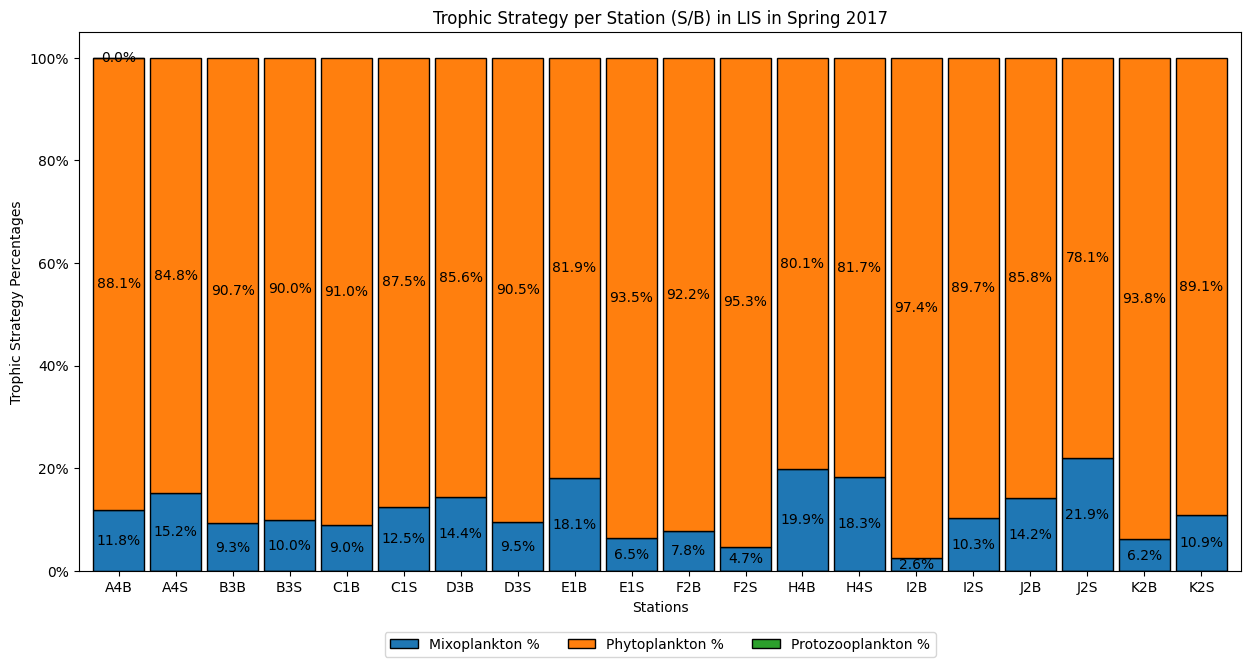

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        353452        2638020              1452  2992924   
1      A4S        624800        3484712                 0  4109512   
2      B3B        247852        2422860                 0  2670712   
3      B3S        293304        2632432                 0  2925736   
4      C1B        229548        2321660                 0  2551208   
5      C1S        200904        1400608                 0  1601512   
6      D3B        441452        2631024                 0  3072476   
7      D3S        256652        2456564                 0  2713216   
8      E1B        441452        1997468                 0  2438920   
9      E1S        140800        2029764                 0  2170564   
10     F2B        199452        2355452                 0  2554904   
11     F2S        105600        2120756                 0  2226356   
12     H4B        243452         980364                 0  1223816   
13     H4S        120252         536712                 0   656964   
14     I2B         33704        1286208                 0  1319912   
15     I2S        111452         967868                 0  1079320   
16     J2B        233200        1412356                 0  1645556   
17     J2S        360800        1283216                 0  1644016   
18     K2B         57156         871112                 0   928268   
19     K2S         62260         510268                 0   572528   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        11.809588        88.141897            0.048514  
1        15.203752        84.796248            0.000000  
2         9.280372        90.719628            0.000000  
3        10.024965        89.975035            0.000000  
4         8.997620        91.002380            0.000000  
5        12.544645        87.455355            0.000000  
6        14.367956        85.632044            0.000000  
7         9.459328        90.540672            0.000000  
8        18.100307        81.899693            0.000000  
9         6.486793        93.513207            0.000000  
10        7.806634        92.193366            0.000000  
11        4.743177        95.256823            0.000000  
12       19.892860        80.107140            0.000000  
13       18.304199        81.695801            0.000000  
14        2.553504        97.446496            0.000000  
15       10.326131        89.673869            0.000000  
16       14.171502        85.828498            0.000000  
17       21.946258        78.053742            0.000000  
18        6.157274        93.842726            0.000000  
19       10.874577        89.125423            0.000000

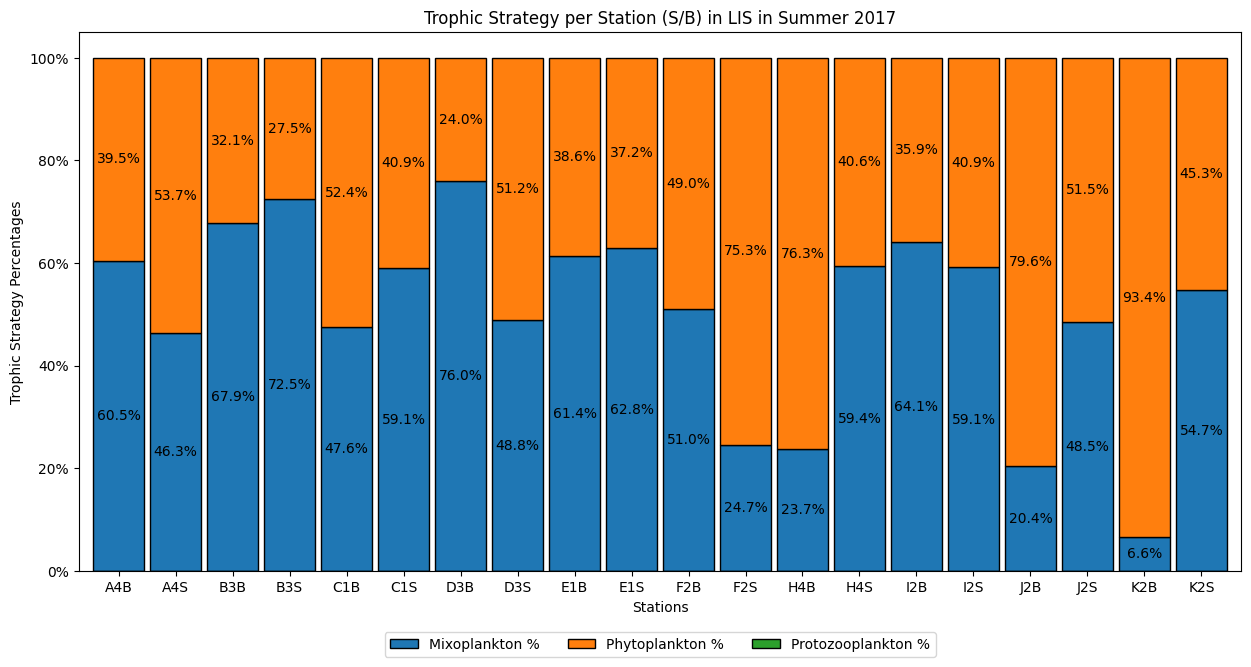

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        668800         436876                 0  1105676   
1      A4S       1295052        1501764                 0  2796816   
2      B3B        409904         194172                 0   604076   
3      B3S       2803504        1063216                 0  3866720   
4      C1B         35200          38764                 0    73964   
5      C1S       1231208         851928                 0  2083136   
6      D3B        327052         103312                 0   430364   
7      D3S        630652         661364                 0  1292016   
8      E1B        221452         139172                 0   360624   
9      E1S        866800         512468                 0  1379268   
10     F2B        375452         360580                 0   736032   
11     F2S        141504         432520                 0   574024   
12     H4B        110704         355564                 0   466268   
13     H4S        541200         370216                 0   911416   
14     I2B        291852         163284                 0   455136   
15     I2S        545566         376860                 0   922426   
16     J2B         46508         181456                 0   227964   
17     J2S        240504         255024                 0   495528   
18     K2B         13860         195580                 0   209440   
19     K2S        272800         225632                 0   498432   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        60.487883        39.512117                 0.0  
1        46.304512        53.695488                 0.0  
2        67.856362        32.143638                 0.0  
3        72.503414        27.496586                 0.0  
4        47.590720        52.409280                 0.0  
5        59.103582        40.896418                 0.0  
6        75.994275        24.005725                 0.0  
7        48.811470        51.188530                 0.0  
8        61.408004        38.591996                 0.0  
9        62.844929        37.155071                 0.0  
10       51.010282        48.989718                 0.0  
11       24.651234        75.348766                 0.0  
12       23.742569        76.257431                 0.0  
13       59.380129        40.619871                 0.0  
14       64.124130        35.875870                 0.0  
15       59.144690        40.855310                 0.0  
16       20.401467        79.598533                 0.0  
17       48.534896        51.465104                 0.0  
18        6.617647        93.382353                 0.0  
19       54.731638        45.268362                 0.0

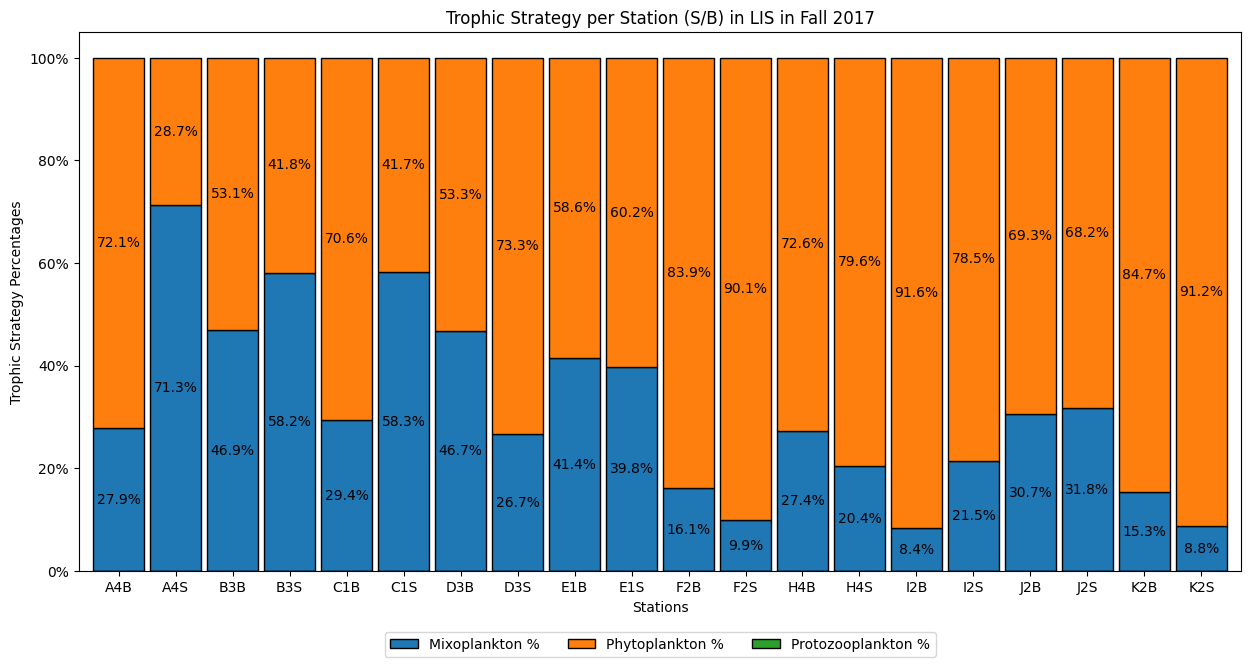

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B         74800         193204                 0  268004   
1      A4S        343156         138336                 0  481492   
2      B3B        159852         180708                 0  340560   
3      B3S        275704         198396                 0  474100   
4      C1B         79200         190344                 0  269544   
5      C1S        249304         178640                 0  427944   
6      D3B        142252         162404                 0  304656   
7      D3S         79200         217536                 0  296736   
8      E1B        101904         144012                 0  245916   
9      E1S        116512         176352                 0  292864   
10     F2B         73304         380996                 0  454300   
11     F2S         27104         245344                 0  272448   
12     H4B        115852         307648                 0  423500   
13     H4S         96800         377432                 0  474232   
14     I2B         32208         349448                 0  381656   
15     I2S         71104         259116                 0  330220   
16     J2B         89452         202136                 0  291588   
17     J2S        109956         235796                 0  345752   
18     K2B         28512         157344                 0  185856   
19     K2S         24904         258456                 0  283360   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        27.910031        72.089969                 0.0  
1        71.269305        28.730695                 0.0  
2        46.937984        53.062016                 0.0  
3        58.153132        41.846868                 0.0  
4        29.382958        70.617042                 0.0  
5        58.256220        41.743780                 0.0  
6        46.692663        53.307337                 0.0  
7        26.690391        73.309609                 0.0  
8        41.438540        58.561460                 0.0  
9        39.783654        60.216346                 0.0  
10       16.135593        83.864407                 0.0  
11        9.948320        90.051680                 0.0  
12       27.355844        72.644156                 0.0  
13       20.411950        79.588050                 0.0  
14        8.439013        91.560987                 0.0  
15       21.532312        78.467688                 0.0  
16       30.677531        69.322469                 0.0  
17       31.801985        68.198015                 0.0  
18       15.340909        84.659091                 0.0  
19        8.788820        91.211180                 0.0

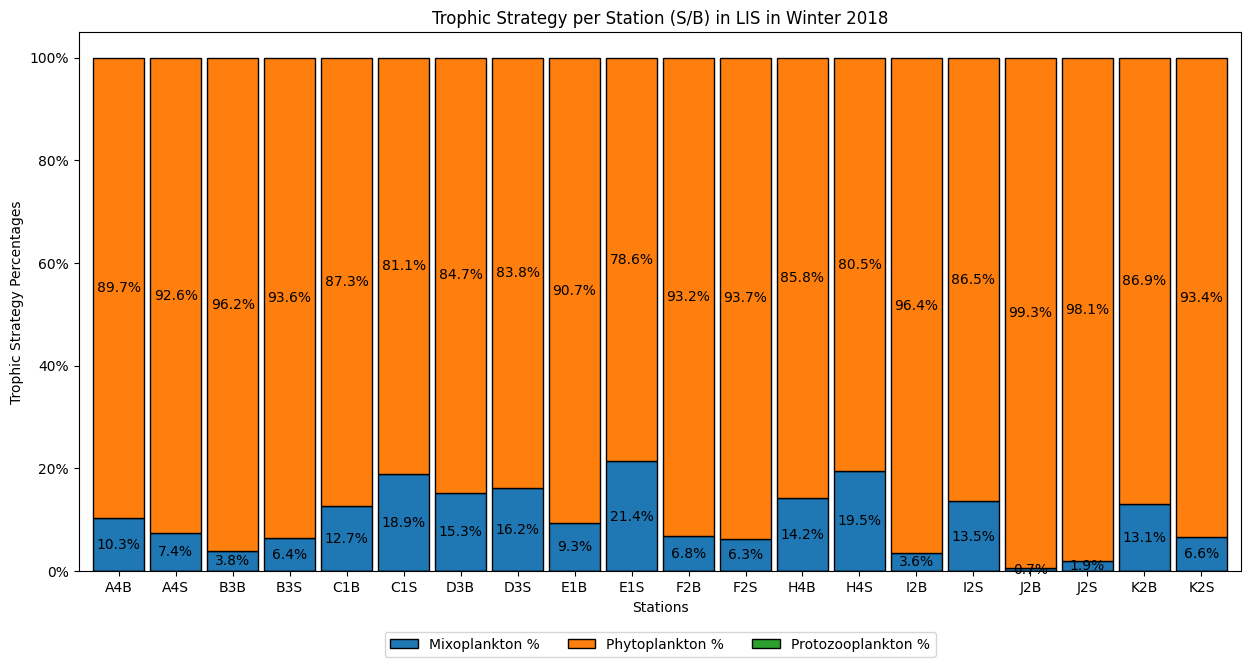

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        289564        2524016                 0  2813580   
1      A4S        198704        2495372                 0  2694076   
2      B3B         92400        2318668                 0  2411068   
3      B3S        232408        3415016                 0  3647424   
4      C1B        194260        1332320                 0  1526580   
5      C1S        349052        1502534                 0  1851586   
6      D3B        200816        1112364                 0  1313180   
7      D3S        206800        1069112                 0  1275912   
8      E1B        110704        1078616                 0  1189320   
9      E1S        211904         780032                 0   991936   
10     F2B        140756        1941060                 0  2081816   
11     F2S         64504         959068                 0  1023572   
12     H4B        248556        1507704                 0  1756260   
13     H4S        101904         420772                 0   522676   
14     I2B         44704        1208372                 0  1253076   
15     I2S        101904         650276                 0   752180   
16     J2B          5060         744876                 0   749936   
17     J2S         10252         524128                 0   534380   
18     K2B         68860         457380                 0   526240   
19     K2S         44000         623084                 0   667084   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        10.291657        89.708343                 0.0  
1         7.375590        92.624410                 0.0  
2         3.832327        96.167673                 0.0  
3         6.371839        93.628161                 0.0  
4        12.725177        87.274823                 0.0  
5        18.851514        81.148486                 0.0  
6        15.292344        84.707656                 0.0  
7        16.208014        83.791986                 0.0  
8         9.308176        90.691824                 0.0  
9        21.362669        78.637331                 0.0  
10        6.761212        93.238788                 0.0  
11        6.301853        93.698147                 0.0  
12       14.152574        85.847426                 0.0  
13       19.496591        80.503409                 0.0  
14        3.567541        96.432459                 0.0  
15       13.547821        86.452179                 0.0  
16        0.674724        99.325276                 0.0  
17        1.918485        98.081515                 0.0  
18       13.085284        86.914716                 0.0  
19        6.595871        93.404129                 0.0

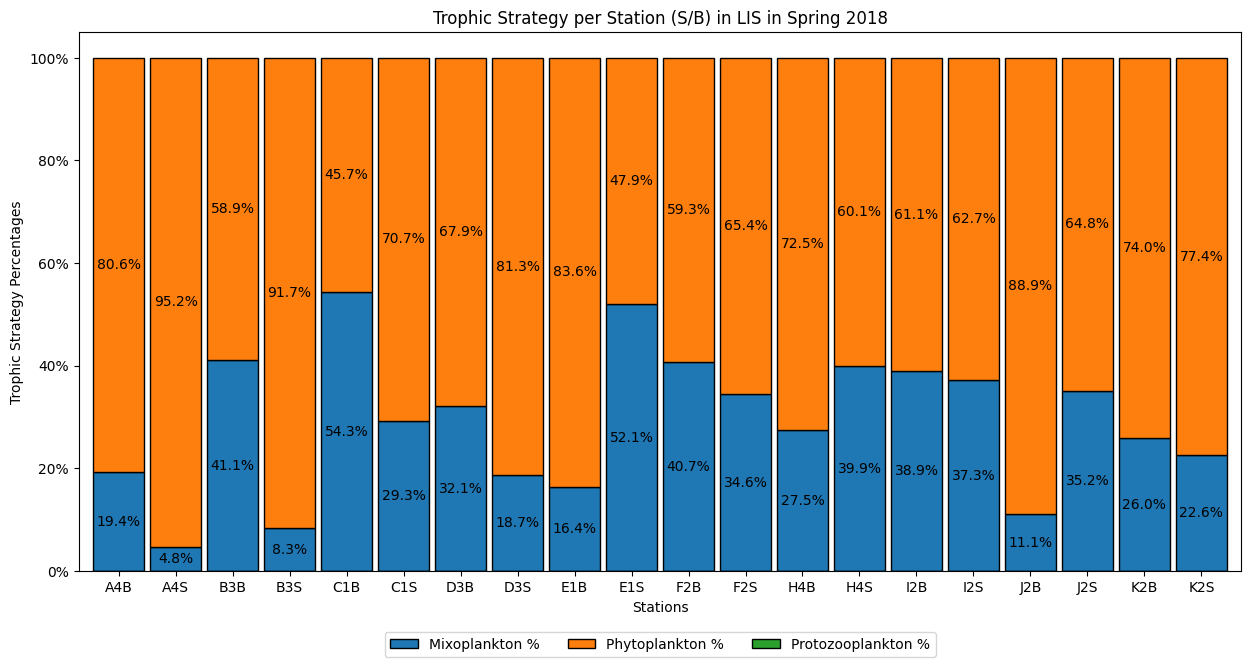

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        836000        3475912                 0  4311912   
1      A4S        365200        7294364                 0  7659564   
2      B3B        611600         877712                 0  1489312   
3      B3S        507408        5595172                 0  6102580   
4      C1B        973852         818356                 0  1792208   
5      C1S        662904        1597904                 0  2260808   
6      D3B        198704         419364                 0   618068   
7      D3S        358556        1562572                 0  1921128   
8      E1B         83600         424908                 0   508508   
9      E1S        444400         408320                 0   852720   
10     F2B        326304         475860                 0   802164   
11     F2S        313104         592504                 0   905608   
12     H4B        286000         753808                 0  1039808   
13     H4S        277200         417208                 0   694408   
14     I2B        418704         656964                 0  1075668   
15     I2S        357104         600556                 0   957660   
16     J2B         46904         376068                 0   422972   
17     J2S        215600         397408                 0   613008   
18     K2B         97152         277112                 0   374264   
19     K2S         85052         290972                 0   376024   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        19.388151        80.611849                 0.0  
1         4.767895        95.232105                 0.0  
2        41.065942        58.934058                 0.0  
3         8.314647        91.685353                 0.0  
4        54.338113        45.661887                 0.0  
5        29.321552        70.678448                 0.0  
6        32.149213        67.850787                 0.0  
7        18.663827        81.336173                 0.0  
8        16.440253        83.559747                 0.0  
9        52.115583        47.884417                 0.0  
10       40.677966        59.322034                 0.0  
11       34.573900        65.426100                 0.0  
12       27.505078        72.494922                 0.0  
13       39.918895        60.081105                 0.0  
14       38.925021        61.074979                 0.0  
15       37.289226        62.710774                 0.0  
16       11.089150        88.910850                 0.0  
17       35.170830        64.829170                 0.0  
18       25.958147        74.041853                 0.0  
19       22.618769        77.381231                 0.0

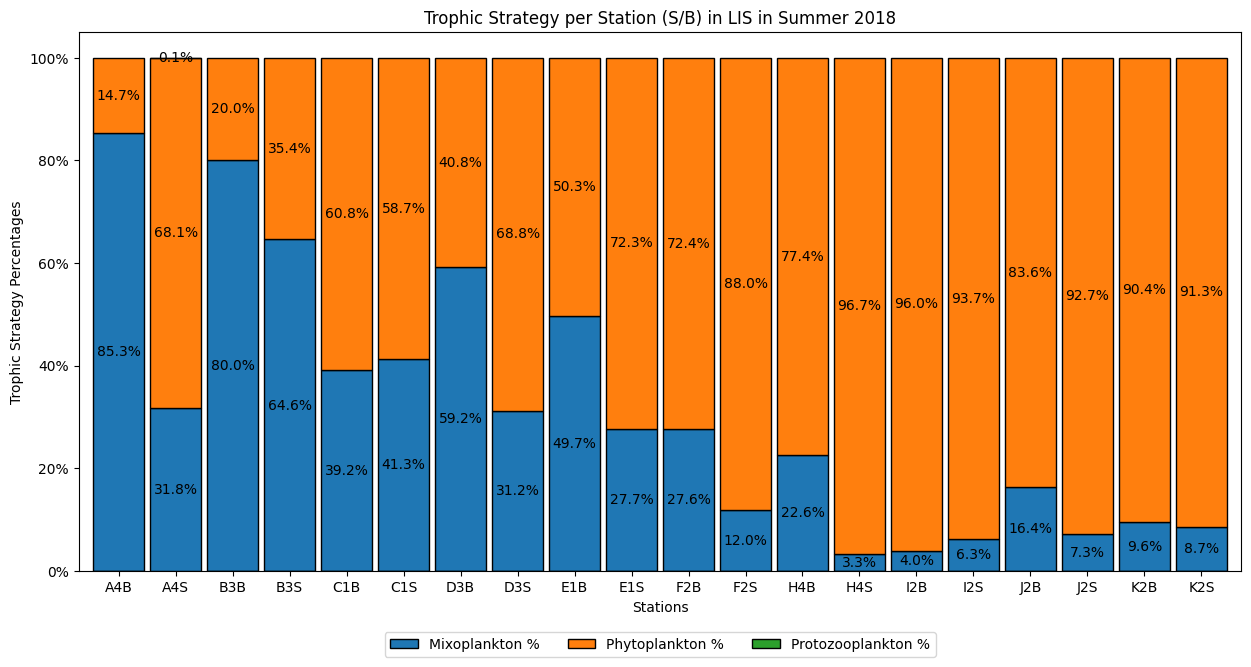

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        528000          91080                 0   619080   
1      A4S        621456        1330648              2904  1955008   
2      B3B        287452          71720                 0   359172   
3      B3S       1727264         946484                 0  2673748   
4      C1B         57200          88836                 0   146036   
5      C1S       1203312        1708256                 0  2911568   
6      D3B        155452         107008                 0   262460   
7      D3S        541552        1192312                 0  1733864   
8      E1B        111452         112904                 0   224356   
9      E1S        894652        2330592                 0  3225244   
10     F2B         64504         168828                 0   233332   
11     F2S        330000        2428140                 0  2758140   
12     H4B         52800         181016                 0   233816   
13     H4S         59356        1731840                 0  1791196   
14     I2B         14652         352924                 0   367576   
15     I2S        139304        2088636                 0  2227940   
16     J2B        113256         577236                 0   690492   
17     J2S         90904        1161688                 0  1252592   
18     K2B         30800         289784                 0   320584   
19     K2S        115104        1214972                 0  1330076   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        85.287846        14.712154            0.000000  
1        31.787901        68.063558            0.148542  
2        80.031851        19.968149            0.000000  
3        64.600852        35.399148            0.000000  
4        39.168424        60.831576            0.000000  
5        41.328659        58.671341            0.000000  
6        59.228835        40.771165            0.000000  
7        31.233822        68.766178            0.000000  
8        49.676407        50.323593            0.000000  
9        27.739049        72.260951            0.000000  
10       27.644729        72.355271            0.000000  
11       11.964585        88.035415            0.000000  
12       22.581859        77.418141            0.000000  
13        3.313764        96.686236            0.000000  
14        3.986114        96.013886            0.000000  
15        6.252592        93.747408            0.000000  
16       16.402218        83.597782            0.000000  
17        7.257271        92.742729            0.000000  
18        9.607466        90.392534            0.000000  
19        8.653942        91.346058            0.000000

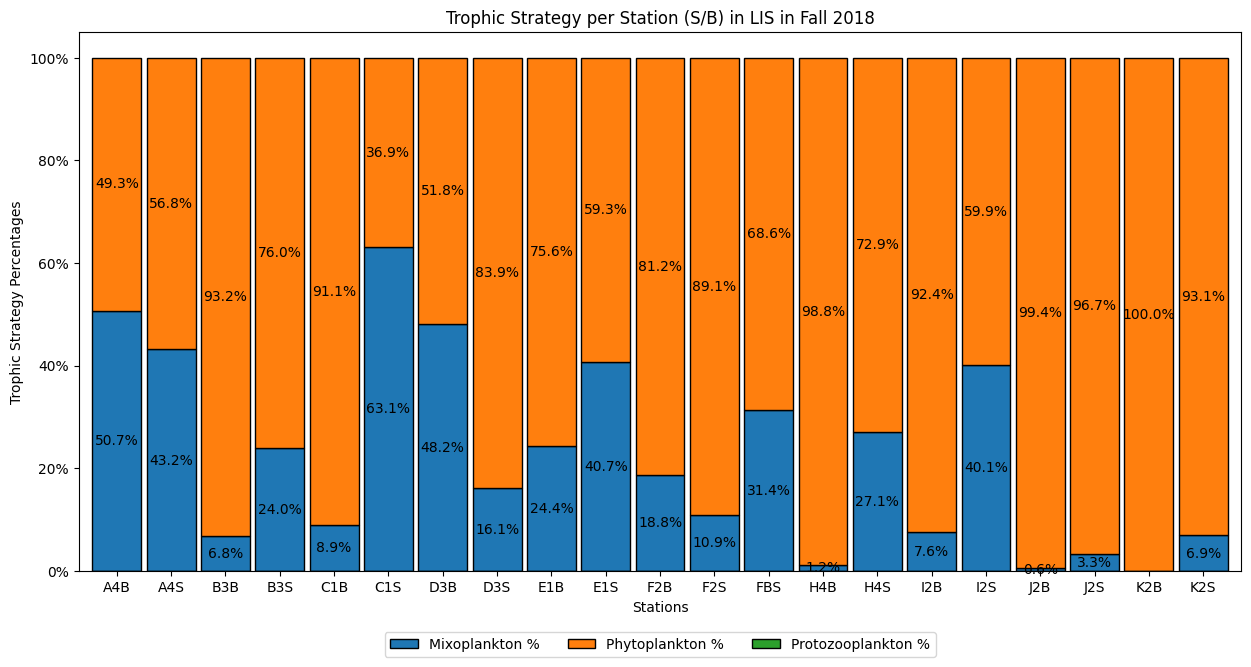

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B        244904         237688                 0  482592   
1      A4S        214104         281908                 0  496012   
2      B3B         17556         241692                 0  259248   
3      B3S         82104         259688                 0  341792   
4      C1B         22000         225148                 0  247148   
5      C1S        228756         133980                 0  362736   
6      D3B        111452         119812                 0  231264   
7      D3S         34408         179520                 0  213928   
8      E1B         48396         150304                 0  198700   
9      E1S        221452         322476                 0  543928   
10     F2B         35200         152460                 0  187660   
11     F2S         54252         442288                 0  496540   
12     FBS         17776          38764                 0   56540   
13     H4B          2904         237116                 0  240020   
14     H4S         68904         184932                 0  253836   
15     I2B          8800         107096                 0  115896   
16     I2S         26356          39380                 0   65736   
17     J2B           704         124476                 0  125180   
18     J2S          3432          99704                 0  103136   
19     K2B             0         107140                 0  107140   
20     K2S          4356          58432                 0   62788   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        50.747629        49.252371                 0.0  
1        43.165085        56.834915                 0.0  
2         6.771894        93.228106                 0.0  
3        24.021627        75.978373                 0.0  
4         8.901549        91.098451                 0.0  
5        63.064047        36.935953                 0.0  
6        48.192542        51.807458                 0.0  
7        16.083916        83.916084                 0.0  
8        24.356316        75.643684                 0.0  
9        40.713477        59.286523                 0.0  
10       18.757327        81.242673                 0.0  
11       10.926008        89.073992                 0.0  
12       31.439689        68.560311                 0.0  
13        1.209899        98.790101                 0.0  
14       27.145086        72.854914                 0.0  
15        7.593014        92.406986                 0.0  
16       40.093708        59.906292                 0.0  
17        0.562390        99.437610                 0.0  
18        3.327645        96.672355                 0.0  
19        0.000000       100.000000                 0.0  
20        6.937631        93.062369                 0.0

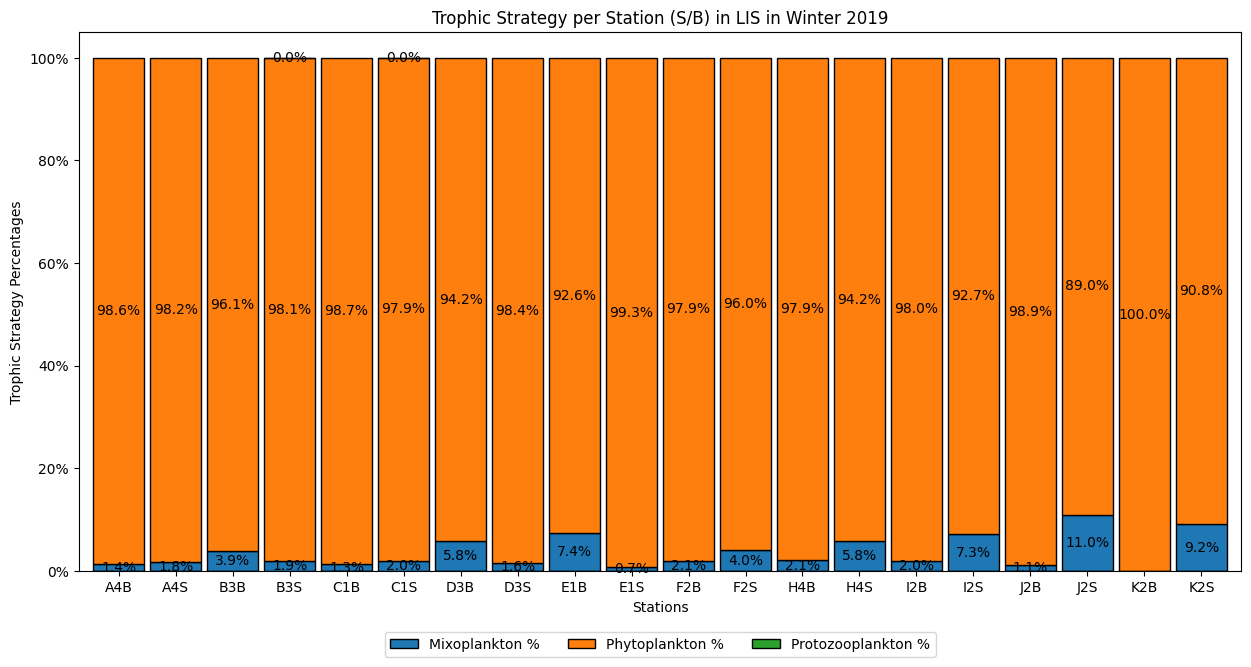

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         89452        6291912                 0  6381364   
1      A4S        108856        5932036                 0  6040892   
2      B3B         99704        2441120                 0  2540824   
3      B3S        117304        6053784              2904  6173992   
4      C1B         48400        3662076                 0  3710476   
5      C1S         54604        2621476               352  2676432   
6      D3B        255200        4159672                 0  4414872   
7      D3S         49852        3159640                 0  3209492   
8      E1B        280104        3490828                 0  3770932   
9      E1S         13904        1844392                 0  1858296   
10     F2B         66000        3149168                 0  3215168   
11     F2S        154000        3654816                 0  3808816   
12     H4B         76956        3632816                 0  3709772   
13     H4S        133452        2171576                 0  2305028   
14     I2B         45408        2205940                 0  2251348   
15     I2S        124608        1586728                 0  1711336   
16     J2B         11880        1042052                 0  1053932   
17     J2S        111452         903188                 0  1014640   
18     K2B             0         570636                 0   570636   
19     K2S         66000         655204                 0   721204   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         1.401769        98.598231            0.000000  
1         1.801986        98.198014            0.000000  
2         3.924081        96.075919            0.000000  
3         1.899970        98.052994            0.047036  
4         1.304415        98.695585            0.000000  
5         2.040179        97.946669            0.013152  
6         5.780462        94.219538            0.000000  
7         1.553268        98.446732            0.000000  
8         7.427978        92.572022            0.000000  
9         0.748212        99.251788            0.000000  
10        2.052770        97.947230            0.000000  
11        4.043251        95.956749            0.000000  
12        2.074413        97.925587            0.000000  
13        5.789604        94.210396            0.000000  
14        2.016925        97.983075            0.000000  
15        7.281329        92.718671            0.000000  
16        1.127207        98.872793            0.000000  
17       10.984389        89.015611            0.000000  
18        0.000000       100.000000            0.000000  
19        9.151364        90.848636            0.000000

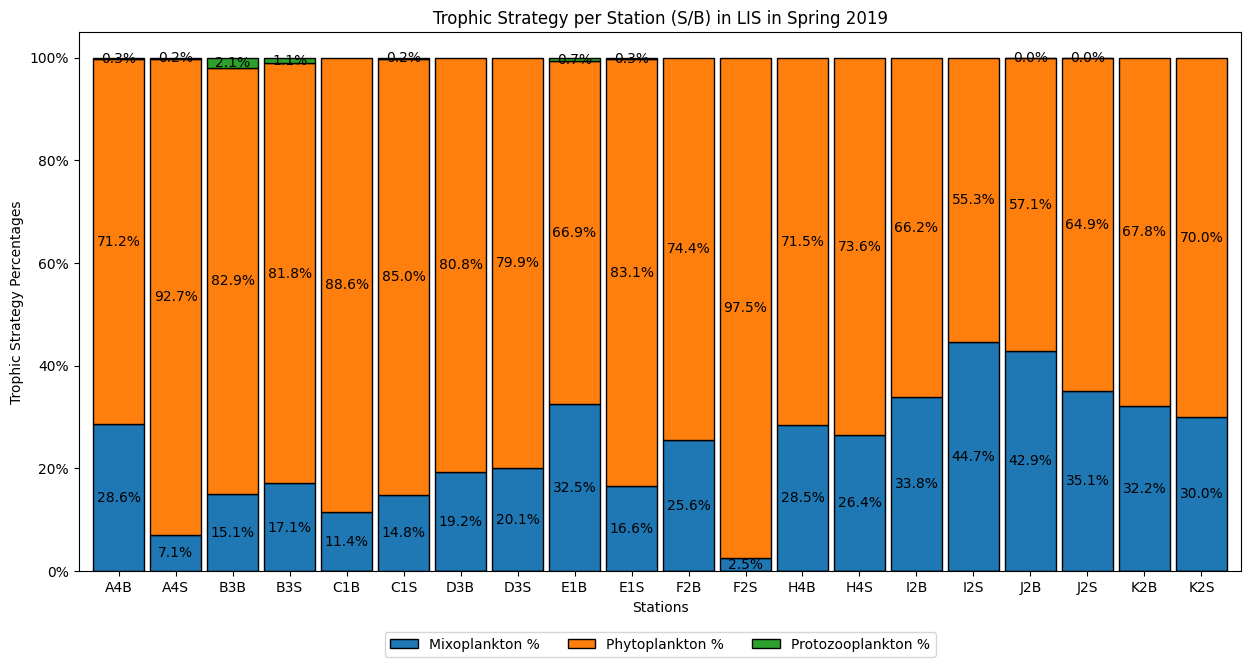

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        660000        1643972              5852  2309824   
1      A4S        228800        3000580              5852  3235232   
2      B3B        290356        1594472             39600  1924428   
3      B3S        400400        1919852             26400  2346652   
4      C1B        177452        1374076                 0  1551528   
5      C1S        270028        1549768              2904  1822700   
6      D3B        325600        1367740                 0  1693340   
7      D3S        356400        1413236                 0  1769636   
8      E1B        422400         869616              8800  1300816   
9      E1S        209704        1051820              4400  1265924   
10     F2B        340252         987976                 0  1328228   
11     F2S         38456        1520156                 0  1558612   
12     H4B        214104         537240                 0   751344   
13     H4S        211200         587664                 0   798864   
14     I2B        308000         602096                 0   910096   
15     I2S        381304         472296                 0   853600   
16     J2B        272800         363220               176   636196   
17     J2S        189156         350152               176   539484   
18     K2B         57904         122188                 0   180092   
19     K2S        132000         307824                 0   439824   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        28.573606        71.173042            0.253353  
1         7.072136        92.746981            0.180883  
2        15.087912        82.854334            2.057754  
3        17.062607        81.812386            1.125007  
4        11.437241        88.562759            0.000000  
5        14.814725        85.025951            0.159324  
6        19.228271        80.771729            0.000000  
7        20.139735        79.860265            0.000000  
8        32.471925        66.851576            0.676498  
9        16.565291        83.087136            0.347572  
10       25.616987        74.383013            0.000000  
11        2.467323        97.532677            0.000000  
12       28.496135        71.503865            0.000000  
13       26.437541        73.562459            0.000000  
14       33.842584        66.157416            0.000000  
15       44.670103        55.329897            0.000000  
16       42.879867        57.092468            0.027664  
17       35.062393        64.904983            0.032624  
18       32.152455        67.847545            0.000000  
19       30.012005        69.987995            0.000000

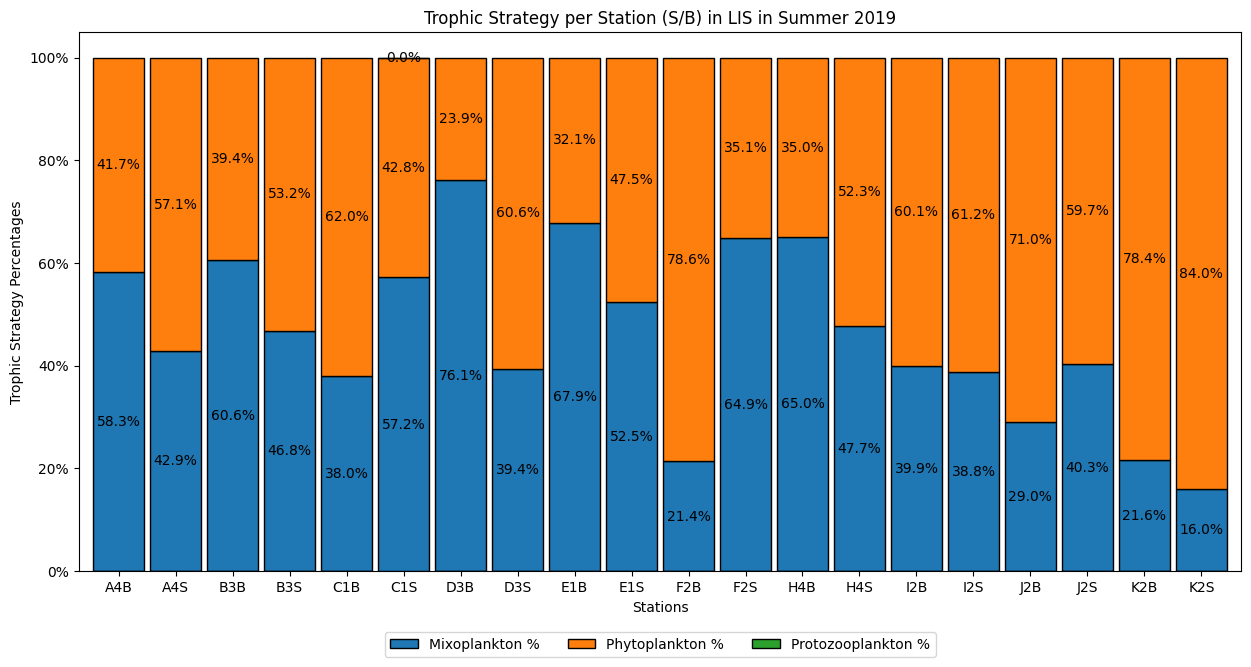

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        177452         126852                 0   304304   
1      A4S        835384        1113068                 0  1948452   
2      B3B        143704          93324                 0   237028   
3      B3S        696608         791252                 0  1487860   
4      C1B         85052         138688                 0   223740   
5      C1S        990792         740740               704  1732236   
6      D3B        286000          89892                 0   375892   
7      D3S        366652         563420                 0   930072   
8      E1B        180400          85404                 0   265804   
9      E1S        297704         269852                 0   567556   
10     F2B         39600         145860                 0   185460   
11     F2S        466356         251680                 0   718036   
12     H4B        237776         127776                 0   365552   
13     H4S        255376         279690                 0   535066   
14     I2B         68904         103664                 0   172568   
15     I2S        313544         493812                 0   807356   
16     J2B        134992         331188                 0   466180   
17     J2S        154176         228580                 0   382756   
18     K2B         32428         117524                 0   149952   
19     K2S        118976         626560                 0   745536   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        58.314054        41.685946            0.000000  
1        42.874241        57.125759            0.000000  
2        60.627436        39.372564            0.000000  
3        46.819459        53.180541            0.000000  
4        38.013766        61.986234            0.000000  
5        57.197287        42.762072            0.040641  
6        76.085684        23.914316            0.000000  
7        39.421894        60.578106            0.000000  
8        67.869558        32.130442            0.000000  
9        52.453679        47.546321            0.000000  
10       21.352313        78.647687            0.000000  
11       64.948833        35.051167            0.000000  
12       65.045739        34.954261            0.000000  
13       47.727944        52.272056            0.000000  
14       39.928608        60.071392            0.000000  
15       38.835904        61.164096            0.000000  
16       28.957055        71.042945            0.000000  
17       40.280492        59.719508            0.000000  
18       21.625587        78.374413            0.000000  
19       15.958451        84.041549            0.000000

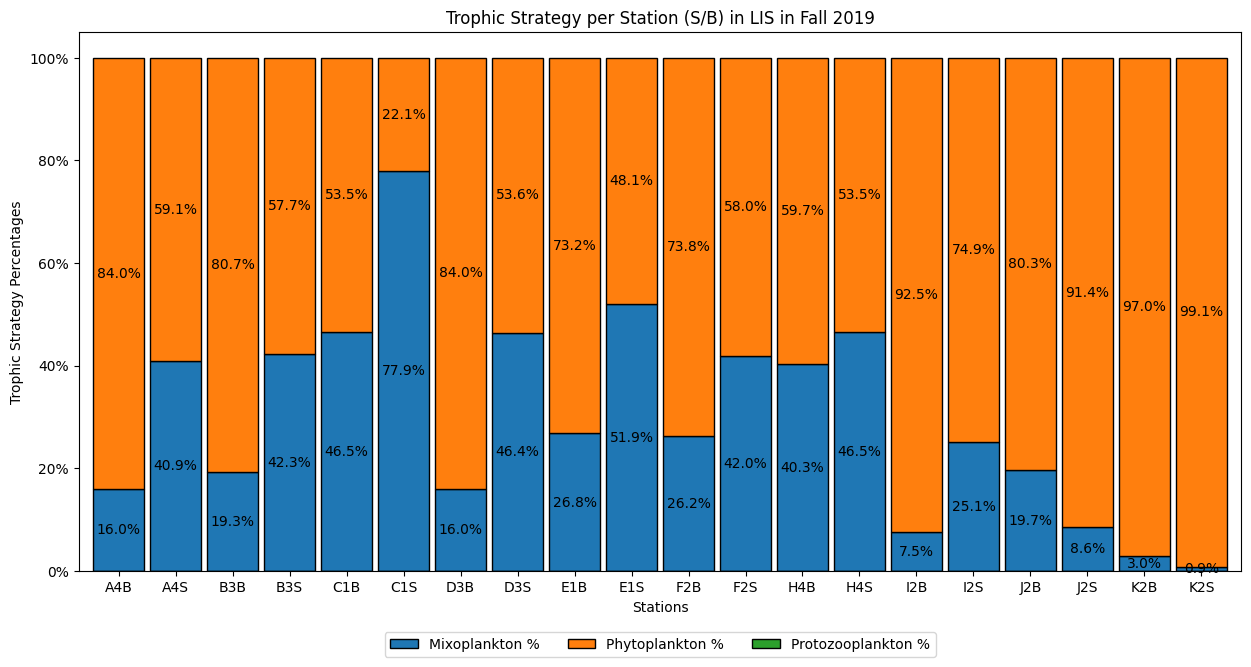

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B         49896         261932                 0  311828   
1      A4S        165704         239096                 0  404800   
2      B3B         51304         214280                 0  265584   
3      B3S        234608         319484                 0  554092   
4      C1B        156904         180620                 0  337524   
5      C1S        434280         122936                 0  557216   
6      D3B         35508         185768                 0  221276   
7      D3S        242176         279224                 0  521400   
8      E1B         49104         134068                 0  183172   
9      E1S        146652         135740                 0  282392   
10     F2B         66088         185900                 0  251988   
11     F2S        139832         193424                 0  333256   
12     H4B        118976         176396                 0  295372   
13     H4S        186428         214544                 0  400972   
14     I2B         27808         341484                 0  369292   
15     I2S         68904         205700                 0  274604   
16     J2B         69608         284196                 0  353804   
17     J2S         20504         219252                 0  239756   
18     K2B          3080         100012                 0  103092   
19     K2S          1628         182556                 0  184184   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        16.001129        83.998871                 0.0  
1        40.934783        59.065217                 0.0  
2        19.317429        80.682571                 0.0  
3        42.340983        57.659017                 0.0  
4        46.486768        53.513232                 0.0  
5        77.937461        22.062539                 0.0  
6        16.046928        83.953072                 0.0  
7        46.447257        53.552743                 0.0  
8        26.807591        73.192409                 0.0  
9        51.932066        48.067934                 0.0  
10       26.226646        73.773354                 0.0  
11       41.959335        58.040665                 0.0  
12       40.280054        59.719946                 0.0  
13       46.494020        53.505980                 0.0  
14        7.530085        92.469915                 0.0  
15       25.092133        74.907867                 0.0  
16       19.674170        80.325830                 0.0  
17        8.552028        91.447972                 0.0  
18        2.987623        97.012377                 0.0  
19        0.883899        99.116101                 0.0

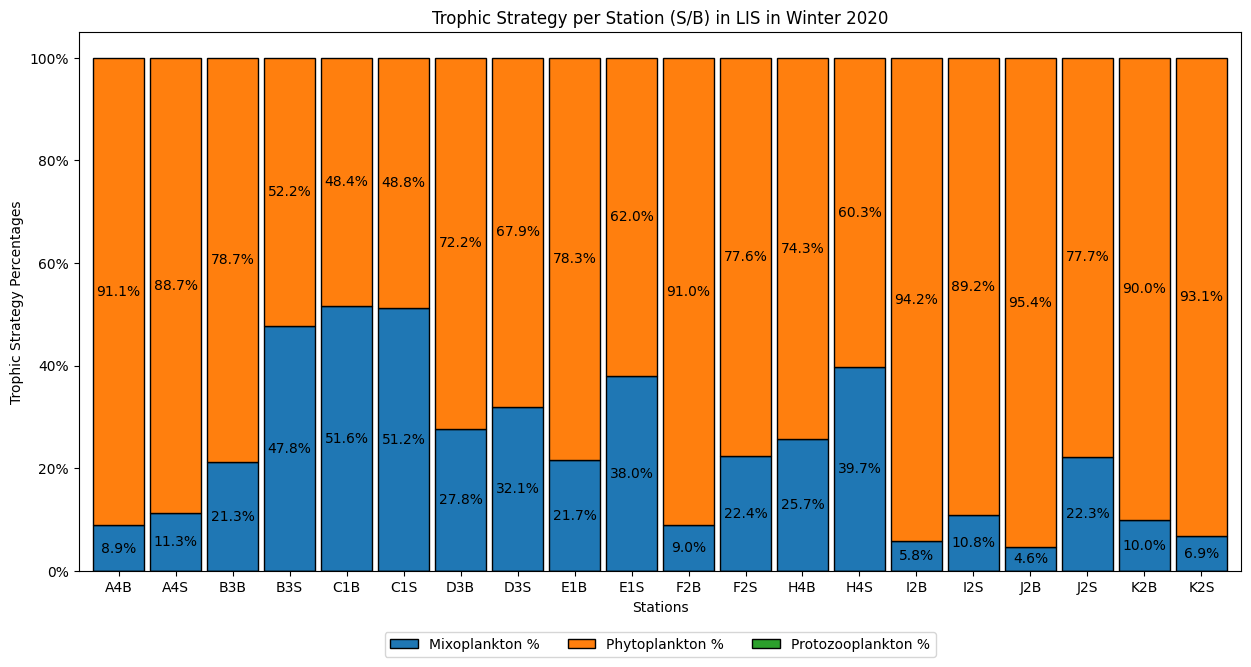

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         61600         632456                 0   694056   
1      A4S        154000        1205468                 0  1359468   
2      B3B        133452         494208                 0   627660   
3      B3S        550176         600512                 0  1150688   
4      C1B        321200         301400                 0   622600   
5      C1S        445852         425480                 0   871332   
6      D3B        215600         561000                 0   776600   
7      D3S        133452         282920                 0   416372   
8      E1B         88000         317416                 0   405416   
9      E1S        118008         192544                 0   310552   
10     F2B         39600         401148                 0   440748   
11     F2S        103004         356664                 0   459668   
12     H4B        180400         522764                 0   703164   
13     H4S        160160         243452                 0   403612   
14     I2B         28292         459844                 0   488136   
15     I2S         32428         266596                 0   299024   
16     J2B         17600         361724                 0   379324   
17     J2S        127688         444972                 0   572660   
18     K2B         39600         357852                 0   397452   
19     K2S         24156         325248                 0   349404   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0         8.875365        91.124635                 0.0  
1        11.327961        88.672039                 0.0  
2        21.261830        78.738170                 0.0  
3        47.812787        52.187213                 0.0  
4        51.590106        48.409894                 0.0  
5        51.169015        48.830985                 0.0  
6        27.762040        72.237960                 0.0  
7        32.051147        67.948853                 0.0  
8        21.706099        78.293901                 0.0  
9        37.999433        62.000567                 0.0  
10        8.984726        91.015274                 0.0  
11       22.408347        77.591653                 0.0  
12       25.655466        74.344534                 0.0  
13       39.681674        60.318326                 0.0  
14        5.795926        94.204074                 0.0  
15       10.844614        89.155386                 0.0  
16        4.639833        95.360167                 0.0  
17       22.297349        77.702651                 0.0  
18        9.963467        90.036533                 0.0  
19        6.913487        93.086513                 0.0

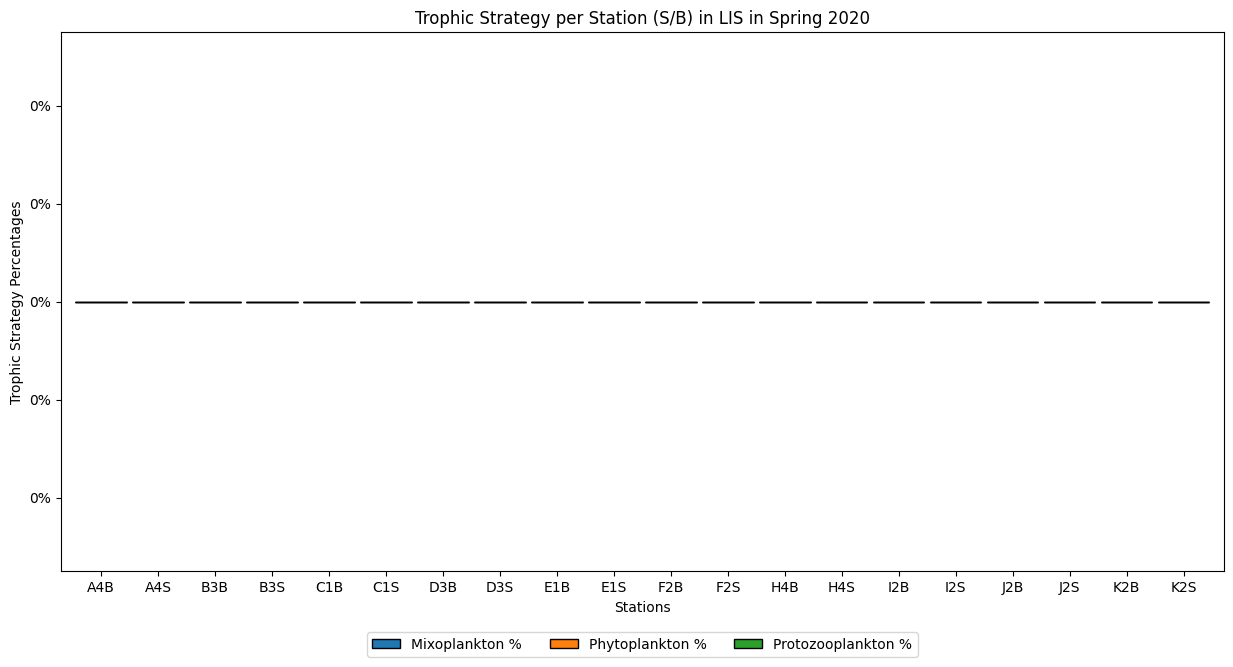

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B             0              0                 0       0   
1      A4S             0              0                 0       0   
2      B3B             0              0                 0       0   
3      B3S             0              0                 0       0   
4      C1B             0              0                 0       0   
5      C1S             0              0                 0       0   
6      D3B             0              0                 0       0   
7      D3S             0              0                 0       0   
8      E1B             0              0                 0       0   
9      E1S             0              0                 0       0   
10     F2B             0              0                 0       0   
11     F2S             0              0                 0       0   
12     H4B             0              0                 0       0   
13     H4S             0              0                 0       0   
14     I2B             0              0                 0       0   
15     I2S             0              0                 0       0   
16     J2B             0              0                 0       0   
17     J2S             0              0                 0       0   
18     K2B             0              0                 0       0   
19     K2S             0              0                 0       0   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0              NaN              NaN                 NaN  
1              NaN              NaN                 NaN  
2              NaN              NaN                 NaN  
3              NaN              NaN                 NaN  
4              NaN              NaN                 NaN  
5              NaN              NaN                 NaN  
6              NaN              NaN                 NaN  
7              NaN              NaN                 NaN  
8              NaN              NaN                 NaN  
9              NaN              NaN                 NaN  
10             NaN              NaN                 NaN  
11             NaN              NaN                 NaN  
12             NaN              NaN                 NaN  
13             NaN              NaN                 NaN  
14             NaN              NaN                 NaN  
15             NaN              NaN                 NaN  
16             NaN              NaN                 NaN  
17             NaN              NaN                 NaN  
18             NaN              NaN                 NaN  
19             NaN              NaN                 NaN

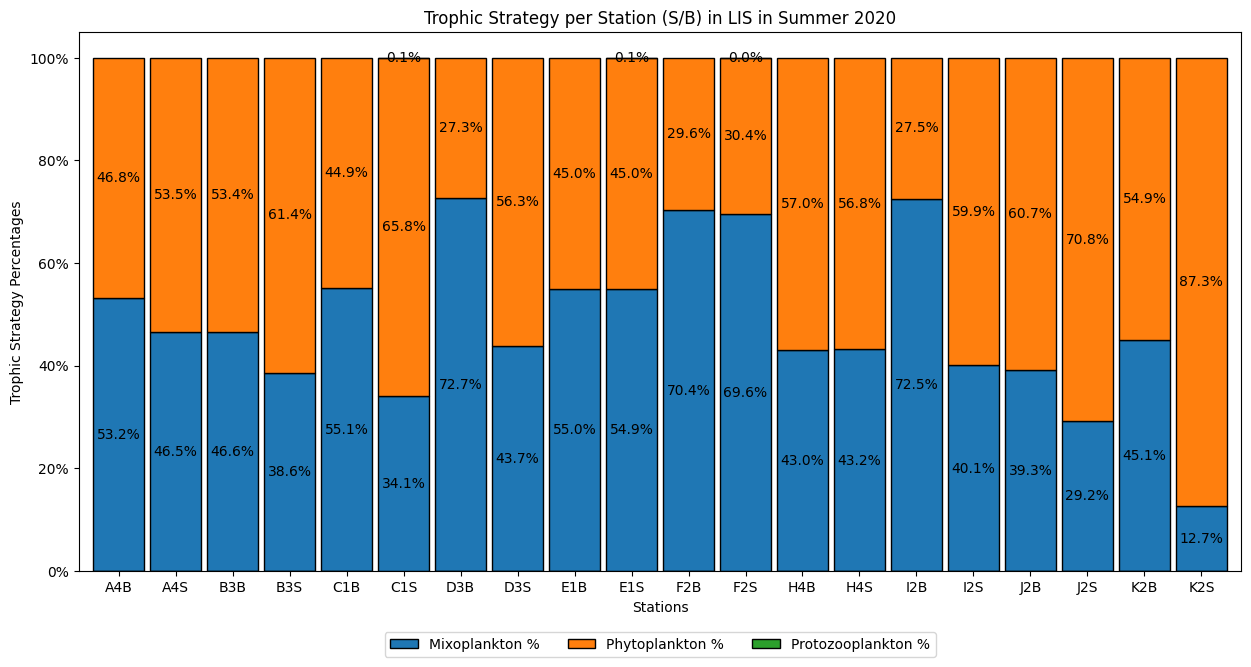

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B         44000          38720                 0    82720   
1      A4S       1443200        1660956                 0  3104156   
2      B3B        228800         261932                 0   490732   
3      B3S       1249732        1984752                 0  3234484   
4      C1B        338800         276628                 0   615428   
5      C1S        830808        1600588              2904  2434300   
6      D3B        335852         126192                 0   462044   
7      D3S        579304         744964                 0  1324268   
8      E1B        112992          92576                 0   205568   
9      E1S       1663376        1362416              2904  3028696   
10     F2B        382800         161084                 0   543884   
11     F2S       1299452         567512                88  1867052   
12     H4B        225940         299508                 0   525448   
13     H4S       1029688        1355376                 0  2385064   
14     I2B        686620         259864                 0   946484   
15     I2S        620576         928840                 0  1549416   
16     J2B        107052         165660                 0   272712   
17     J2S        110176         267300                 0   377476   
18     K2B        101992         124124                 0   226116   
19     K2S         64504         443740                 0   508244   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        53.191489        46.808511            0.000000  
1        46.492509        53.507491            0.000000  
2        46.624227        53.375773            0.000000  
3        38.637755        61.362245            0.000000  
4        55.051119        44.948881            0.000000  
5        34.129236        65.751469            0.119295  
6        72.688315        27.311685            0.000000  
7        43.745224        56.254776            0.000000  
8        54.965753        45.034247            0.000000  
9        54.920533        44.983584            0.095883  
10       70.382655        29.617345            0.000000  
11       69.599133        30.396154            0.004713  
12       42.999498        57.000502            0.000000  
13       43.172343        56.827657            0.000000  
14       72.544280        27.455720            0.000000  
15       40.052252        59.947748            0.000000  
16       39.254598        60.745402            0.000000  
17       29.187551        70.812449            0.000000  
18       45.106052        54.893948            0.000000  
19       12.691542        87.308458            0.000000

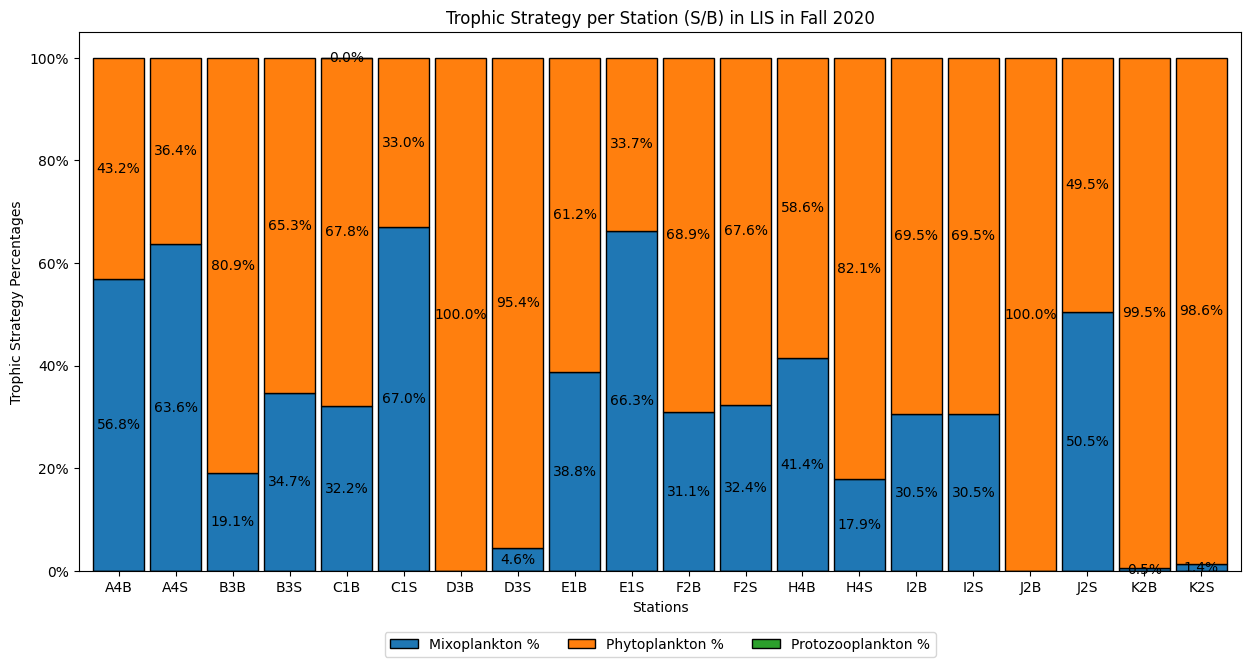

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B         88000          66836                 0  154836   
1      A4S        111628          63844                 0  175472   
2      B3B         22000          93104                 0  115104   
3      B3S         49852          93720                 0  143572   
4      C1B         30800          64812                44   95656   
5      C1S        114400          56276                 0  170676   
6      D3B             0          74096                 0   74096   
7      D3S          4400          91872                 0   96272   
8      E1B         23452          36916                 0   60368   
9      E1S         66000          33528                 0   99528   
10     F2B         30844          68464                 0   99308   
11     F2S         27852          58080                 0   85932   
12     H4B         30800          43516                 0   74316   
13     H4S         22000         100716                 0  122716   
14     I2B         22352          50820                 0   73172   
15     I2S         35552          80960                 0  116512   
16     J2B             0          60896                 0   60896   
17     J2S         66396          65164                 0  131560   
18     K2B           132          24772                 0   24904   
19     K2S          1452         102168                 0  103620   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        56.834328        43.165672            0.000000  
1        63.615848        36.384152            0.000000  
2        19.113150        80.886850            0.000000  
3        34.722648        65.277352            0.000000  
4        32.198712        67.755290            0.045998  
5        67.027584        32.972416            0.000000  
6         0.000000       100.000000            0.000000  
7         4.570384        95.429616            0.000000  
8        38.848397        61.151603            0.000000  
9        66.312997        33.687003            0.000000  
10       31.058928        68.941072            0.000000  
11       32.411674        67.588326            0.000000  
12       41.444642        58.555358            0.000000  
13       17.927573        82.072427            0.000000  
14       30.547204        69.452796            0.000000  
15       30.513595        69.486405            0.000000  
16        0.000000       100.000000            0.000000  
17       50.468227        49.531773            0.000000  
18        0.530035        99.469965            0.000000  
19        1.401274        98.598726            0.000000

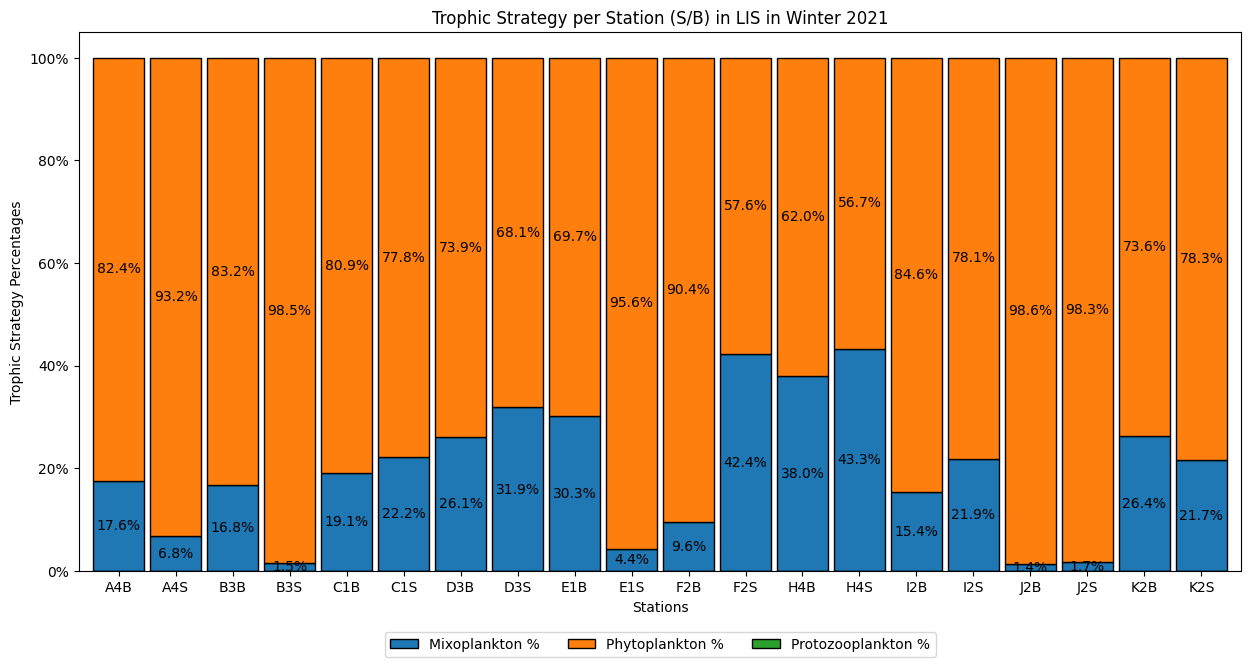

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B        167200         781308                 0  948508   
1      A4S         57200         784564                 0  841764   
2      B3B        118800         589556                 0  708356   
3      B3S          8800         572044                 0  580844   
4      C1B        123200         520608                 0  643808   
5      C1S        118800         416592                 0  535392   
6      D3B        105600         299156                 0  404756   
7      D3S        107052         228756                 0  335808   
8      E1B        105600         243408                 0  349008   
9      E1S         14652         321596                 0  336248   
10     F2B         20504         192148                 0  212652   
11     F2S        158400         215556                 0  373956   
12     H4B        286000         466752                 0  752752   
13     H4S        105600         138160                 0  243760   
14     I2B        137852         759660                 0  897512   
15     I2S         63052         224664                 0  287716   
16     J2B          9504         669152                 0  678656   
17     J2S          9504         544852                 0  554356   
18     K2B        107052         298408                 0  405460   
19     K2S         61644         222860                 0  284504   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        17.627685        82.372315                 0.0  
1         6.795254        93.204746                 0.0  
2        16.771228        83.228772                 0.0  
3         1.515037        98.484963                 0.0  
4        19.136140        80.863860                 0.0  
5        22.189349        77.810651                 0.0  
6        26.089792        73.910208                 0.0  
7        31.878931        68.121069                 0.0  
8        30.257186        69.742814                 0.0  
9         4.357498        95.642502                 0.0  
10        9.642044        90.357956                 0.0  
11       42.357924        57.642076                 0.0  
12       37.993921        62.006079                 0.0  
13       43.321300        56.678700                 0.0  
14       15.359349        84.640651                 0.0  
15       21.914666        78.085334                 0.0  
16        1.400415        98.599585                 0.0  
17        1.714422        98.285578                 0.0  
18       26.402604        73.597396                 0.0  
19       21.667182        78.332818                 0.0

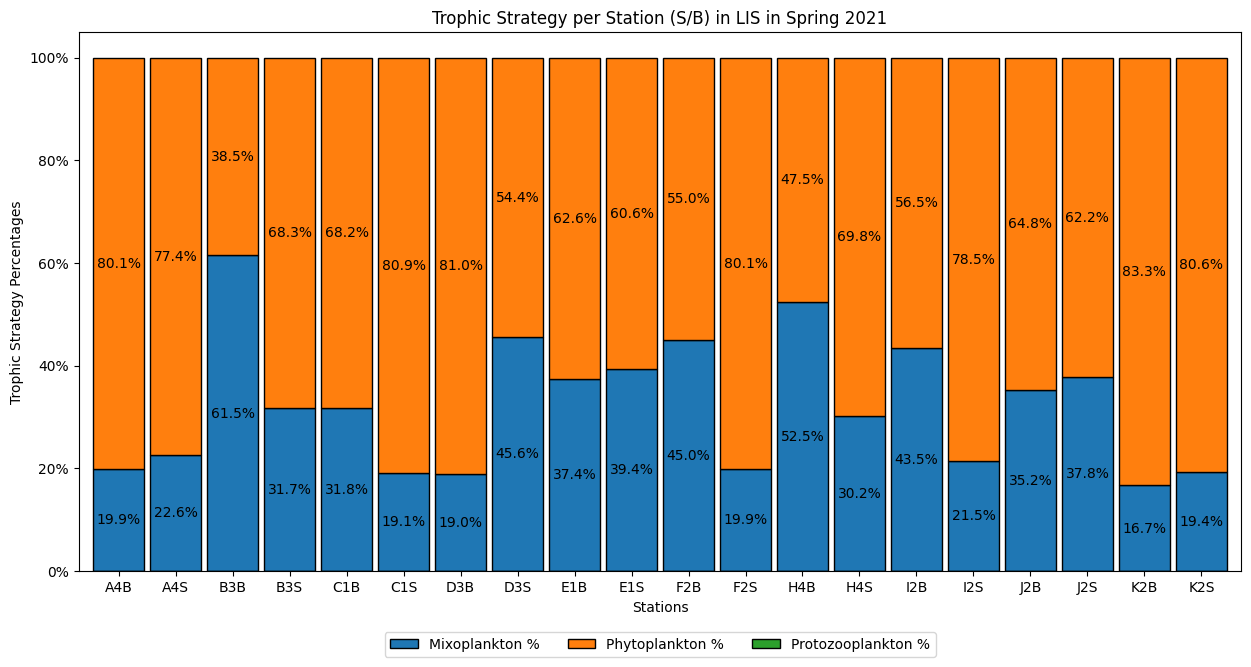

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        180400         727408                 0   907808   
1      A4S        655776        2240172                 0  2895948   
2      B3B        563200         352968                 0   916168   
3      B3S       1020976        2197844                 0  3218820   
4      C1B        202400         434060                 0   636460   
5      C1S        526856        2225608                 0  2752464   
6      D3B        107052         456368                 0   563420   
7      D3S        369600         440220                 0   809820   
8      E1B        303600         507452                 0   811052   
9      E1S        193952         298804                 0   492756   
10     F2B        365200         445808                 0   811008   
11     F2S        171600         689260                 0   860860   
12     H4B        393756         356840                 0   750596   
13     H4S        324808         752048                 0  1076856   
14     I2B        418000         543356                 0   961356   
15     I2S        102608         375320                 0   477928   
16     J2B        192104         353012                 0   545116   
17     J2S        182908         301356                 0   484264   
18     K2B         70400         351956                 0   422356   
19     K2S         70752         294756                 0   365508   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        19.872043        80.127957                 0.0  
1        22.644605        77.355395                 0.0  
2        61.473442        38.526558                 0.0  
3        31.718953        68.281047                 0.0  
4        31.800899        68.199101                 0.0  
5        19.141249        80.858751                 0.0  
6        19.000390        80.999610                 0.0  
7        45.639772        54.360228                 0.0  
8        37.432865        62.567135                 0.0  
9        39.360657        60.639343                 0.0  
10       45.030382        54.969618                 0.0  
11       19.933555        80.066445                 0.0  
12       52.459112        47.540888                 0.0  
13       30.162622        69.837378                 0.0  
14       43.480251        56.519749                 0.0  
15       21.469343        78.530657                 0.0  
16       35.240940        64.759060                 0.0  
17       37.770307        62.229693                 0.0  
18       16.668403        83.331597                 0.0  
19       19.357169        80.642831                 0.0

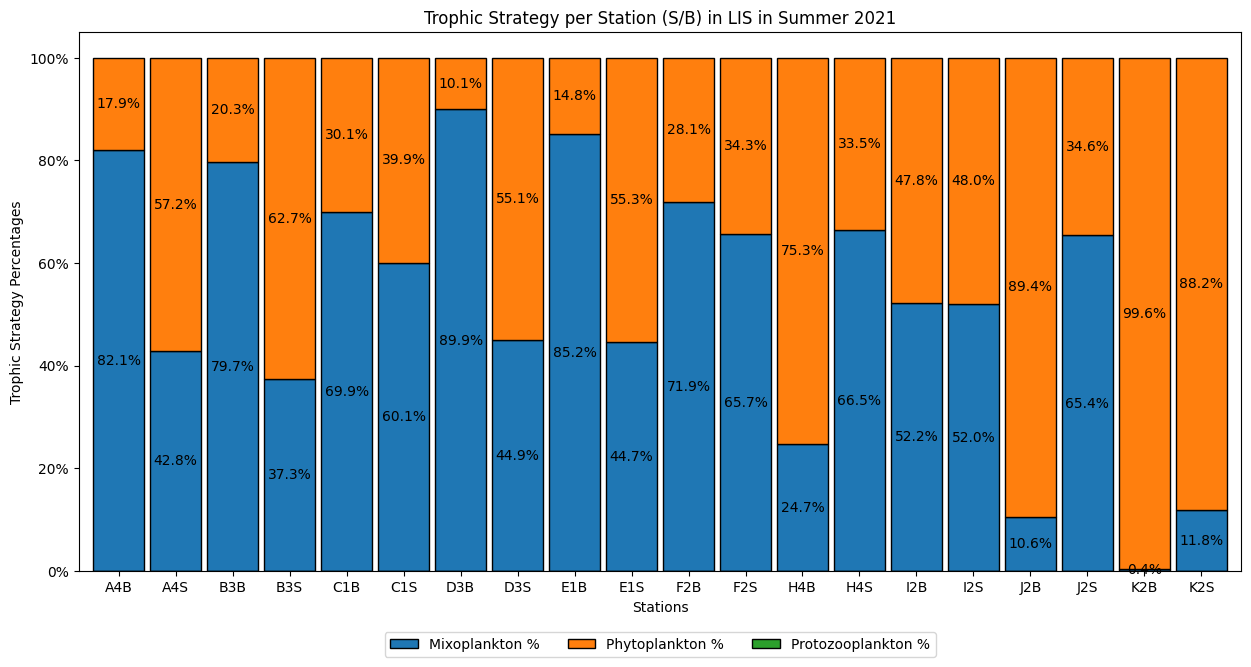

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        479556         104676                 0   584232   
1      A4S       1103960        1473868                 0  2577828   
2      B3B        471152         119680                 0   590832   
3      B3S       1236708        2074600                 0  3311308   
4      C1B        177452          76516                 0   253968   
5      C1S        975656         648120                 0  1623776   
6      D3B        501600          56144                 0   557744   
7      D3S        317856         389444                 0   707300   
8      E1B        532708          92312                 0   625020   
9      E1S         79200          98032                 0   177232   
10     F2B        202356          79068                 0   281424   
11     F2S        589996         308528                 0   898524   
12     H4B         24904          75856                 0   100760   
13     H4S        215600         108724                 0   324324   
14     I2B         82104          75064                 0   157168   
15     I2S        281600         260392                 0   541992   
16     J2B         22000         185548                 0   207548   
17     J2S        758296         401676                 0  1159972   
18     K2B           352          96448                 0    96800   
19     K2S         36740         273504                 0   310244   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        82.083145        17.916855                 0.0  
1        42.825200        57.174800                 0.0  
2        79.743819        20.256181                 0.0  
3        37.348021        62.651979                 0.0  
4        69.871795        30.128205                 0.0  
5        60.085628        39.914372                 0.0  
6        89.933733        10.066267                 0.0  
7        44.939347        55.060653                 0.0  
8        85.230553        14.769447                 0.0  
9        44.687190        55.312810                 0.0  
10       71.904315        28.095685                 0.0  
11       65.662798        34.337202                 0.0  
12       24.716157        75.283843                 0.0  
13       66.476733        33.523267                 0.0  
14       52.239642        47.760358                 0.0  
15       51.956486        48.043514                 0.0  
16       10.599958        89.400042                 0.0  
17       65.371923        34.628077                 0.0  
18        0.363636        99.636364                 0.0  
19       11.842292        88.157708                 0.0

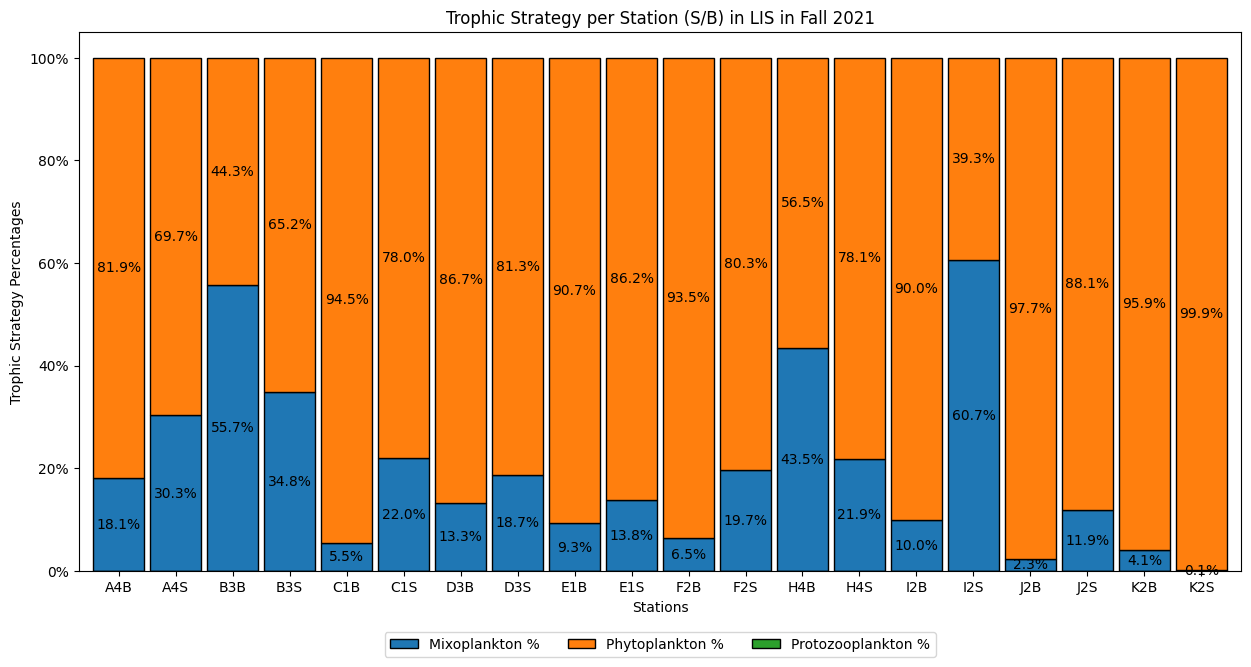

Station  Mixoplankton  Phytoplankton  Protozooplankton  Totals  \
0      A4B         40304         182336                 0  222640   
1      A4S         89452         205700                 0  295152   
2      B3B        140800         111892                 0  252692   
3      B3S         58696         110000                 0  168696   
4      C1B          9152         156596                 0  165748   
5      C1S        129360         459096                 0  588456   
6      D3B         13112          85272                 0   98384   
7      D3S         11748          50952                 0   62700   
8      E1B         13200         129228                 0  142428   
9      E1S         17556         109516                 0  127072   
10     F2B          8712         124960                 0  133672   
11     F2S         29304         119108                 0  148412   
12     H4B         79200         102916                 0  182116   
13     H4S         55748         198792                 0  254540   
14     I2B         13552         121704                 0  135256   
15     I2S         97152          62964                 0  160116   
16     J2B          3256         139392                 0  142648   
17     J2S         14652         108064                 0  122716   
18     K2B          5852         136708                 0  142560   
19     K2S            88          71456                 0   71544   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        18.102767        81.897233                 0.0  
1        30.307096        69.692904                 0.0  
2        55.720007        44.279993                 0.0  
3        34.793949        65.206051                 0.0  
4         5.521635        94.478365                 0.0  
5        21.982952        78.017048                 0.0  
6        13.327370        86.672630                 0.0  
7        18.736842        81.263158                 0.0  
8         9.267841        90.732159                 0.0  
9        13.815789        86.184211                 0.0  
10        6.517446        93.482554                 0.0  
11       19.745034        80.254966                 0.0  
12       43.488765        56.511235                 0.0  
13       21.901469        78.098531                 0.0  
14       10.019519        89.980481                 0.0  
15       60.676010        39.323990                 0.0  
16        2.282542        97.717458                 0.0  
17       11.939763        88.060237                 0.0  
18        4.104938        95.895062                 0.0  
19        0.123001        99.876999                 0.0

In [18]:
for csv_name in csvs:
    # Get map for each season
    for season in season2month.keys():
        seasonal_trophic_strategy_per_station(csv_name, season)

In [19]:
def yearly_trophic_strategy_per_station(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean data
    classified = Classifier(csv_name)
    by_station_SB = classified.add_multiheader(classified.all_classified)
    removed_columns = by_station_SB.loc[:, by_station_SB.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species'])].copy()
    removed_columns.columns = removed_columns.columns.get_level_values(2)
    other_columns = by_station_SB.loc[:, ~by_station_SB.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species', 'Totals'])]
    other_columns.columns = other_columns.columns.get_level_values(1)
    other_columns = other_columns.groupby(other_columns.columns.str[:3], axis=1).sum()
    by_station_SB = pd.concat([removed_columns, other_columns ], axis=1)
    by_station_SB.loc[by_station_SB['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    by_station_SB = by_station_SB.replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton']).drop(['Phylum', 'Genus', 'Species'], axis=1).replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton']).groupby('Status').sum()
    by_station_SB.index.name = None
    by_station_SB = by_station_SB.transpose().reset_index().rename(columns={"index": "Station"})
    by_station_SB['Totals'] = by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].sum(axis=1)
    by_station_SB[['Mixoplankton %', "Phytoplankton %", "Protozooplankton %"]] = by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].div(by_station_SB[['Mixoplankton', "Phytoplankton", "Protozooplankton"]].sum(axis=1), axis=0) * 100
        
    # plot bars in stack manner
    ax = by_station_SB.plot(kind='bar', x='Station', y=['Mixoplankton %', 'Phytoplankton %', 'Protozooplankton %'], stacked=True, figsize=(15, 7), xlabel="Stations", ylabel="Trophic Strategy Percentages", legend=True, title=f"Trophic Strategy per Station (S/B) in LIS in {year}", edgecolor='black', width=.9)
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{bar.get_height():.1f}%' if bar.get_height() > 0 else '' for bar in container], label_type='center', fmt='%.1f%%', color='black')
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
    ax.set_yticklabels([f'{int(tick)}%' for tick in ax.get_yticks()])
    plt.xticks(rotation=0)
    
    plt.show()
    display(by_station_SB)

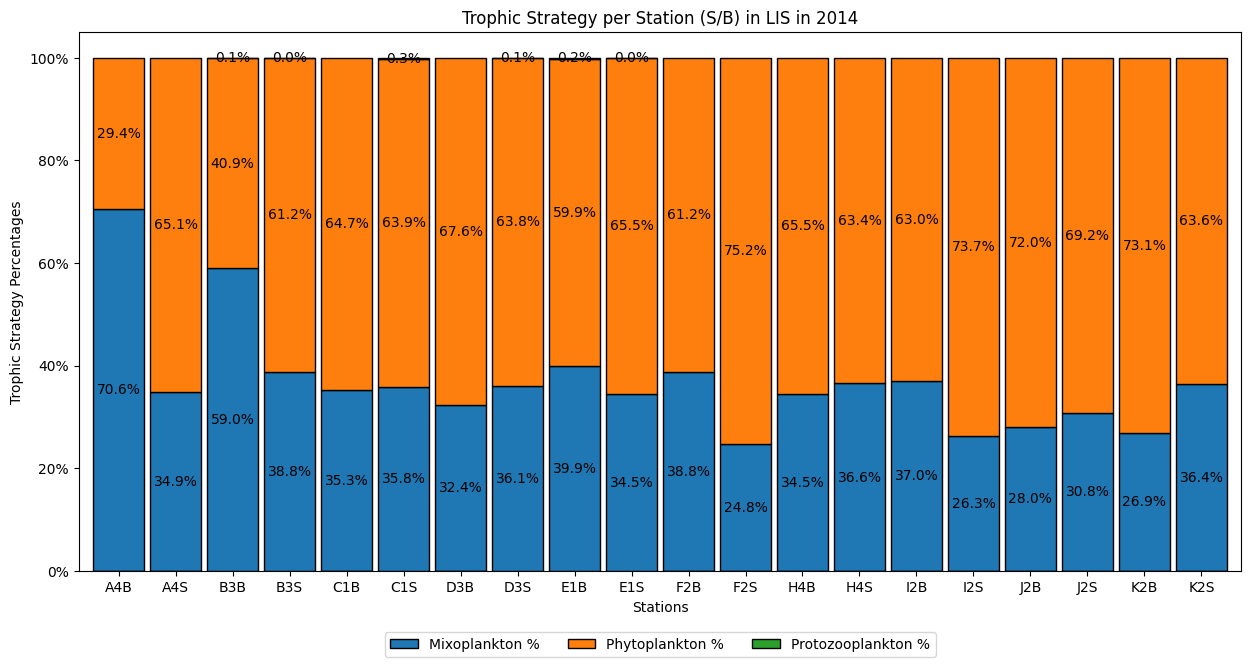

Station  Mixoplankton  Phytoplankton  Protozooplankton    Totals  \
0      A4B        944504         394196                 0   1338700   
1      A4S       4902692        9157664                 0  14060356   
2      B3B        665808         461516              1452   1128776   
3      B3S       3770712        5951176              2904   9724792   
4      C1B        459008         843040                 0   1302048   
5      C1S       2883408        5140696             22000   8046104   
6      D3B        265452         554180                 0    819632   
7      D3S       3500860        6183892              8800   9693552   
8      E1B        341704         513040              1452    856196   
9      E1S       2406140        4570148              1452   6977740   
10     F2B        381304         602462                 0    983766   
11     F2S       1484032        4493236                 0   5977268   
12     H4B        240504         457380                 0    697884   
13     H4S       3079478        5345477                 0   8424955   
14     I2B        313852         534424                 0    848276   
15     I2S       1517252        4249784                 0   5767036   
16     J2B        319704         820996                 0   1140700   
17     J2S       1438668        3239720                 0   4678388   
18     K2B        234564         636152                 0    870716   
19     K2S       1010240        1768800                 0   2779040   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        70.553821        29.446179            0.000000  
1        34.868904        65.131096            0.000000  
2        58.984954        40.886411            0.128635  
3        38.774217        61.195921            0.029862  
4        35.252771        64.747229            0.000000  
5        35.836077        63.890499            0.273424  
6        32.386730        67.613270            0.000000  
7        36.115348        63.793870            0.090782  
8        39.909553        59.920859            0.169587  
9        34.483085        65.496106            0.020809  
10       38.759624        61.240376            0.000000  
11       24.827931        75.172069            0.000000  
12       34.461888        65.538112            0.000000  
13       36.551863        63.448137            0.000000  
14       36.998807        63.001193            0.000000  
15       26.309043        73.690957            0.000000  
16       28.027001        71.972999            0.000000  
17       30.751361        69.248639            0.000000  
18       26.939209        73.060791            0.000000  
19       36.352122        63.647878            0.000000

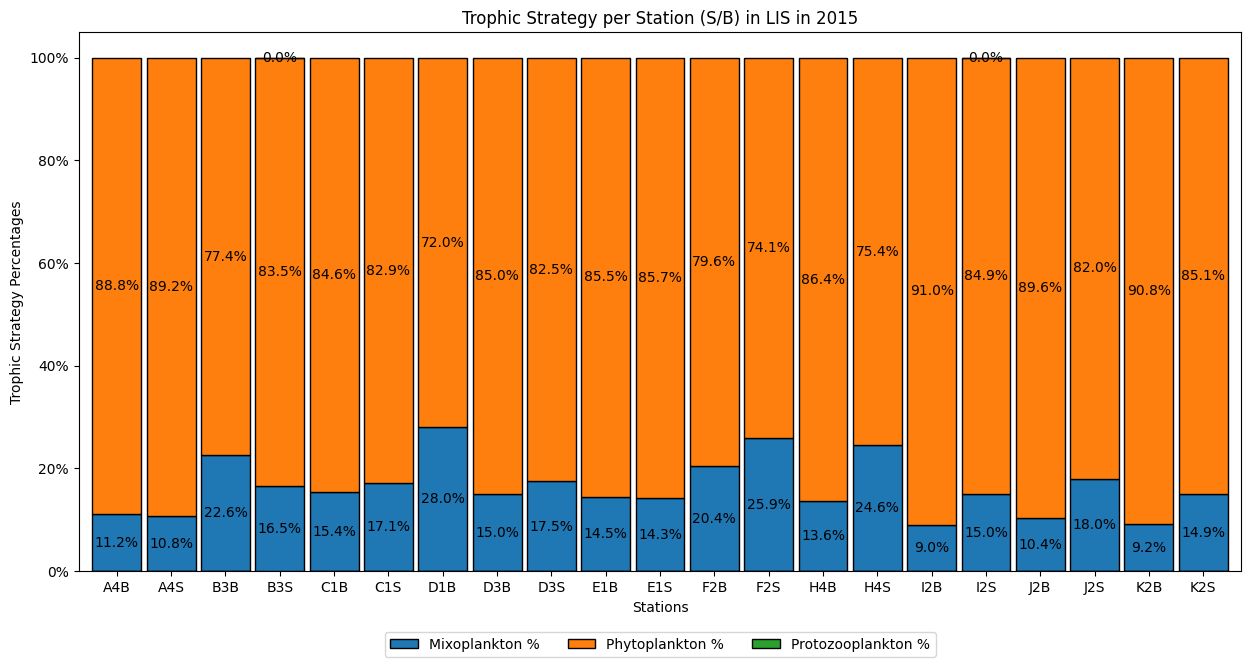

Station  Mixoplankton  Phytoplankton  Protozooplankton    Totals  \
0      A4B       1246652        9926180                 0  11172832   
1      A4S       1488652       12306451                 0  13795103   
2      B3B       1931160        6614740                 0   8545900   
3      B3S       1883156        9534363              4400  11421919   
4      C1B       1094412        6027648                 0   7122060   
5      C1S       1845052        8931692                 0  10776744   
6      D1B         88000         225852                 0    313852   
7      D3B        975172        5537621                 0   6512793   
8      D3S       1403600        6637840                 0   8041440   
9      E1B        818092        4828942                 0   5647034   
10     E1S        962104        5753531                 0   6715635   
11     F2B       1330208        5181824                 0   6512032   
12     F2S       1729200        4939396                 0   6668596   
13     H4B        723488        4594340                 0   5317828   
14     H4S        717112        2201144                 0   2918256   
15     I2B        519860        5226883                 0   5746743   
16     I2S        704880        3982199              1452   4688531   
17     J2B        501556        4320406                 0   4821962   
18     J2S        631488        2873180                 0   3504668   
19     K2B        265452        2611797                 0   2877249   
20     K2S        384164        2189264                 0   2573428   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        11.157887        88.842113            0.000000  
1        10.791163        89.208837            0.000000  
2        22.597503        77.402497            0.000000  
3        16.487212        83.474266            0.038522  
4        15.366509        84.633491            0.000000  
5        17.120681        82.879319            0.000000  
6        28.038693        71.961307            0.000000  
7        14.973177        85.026823            0.000000  
8        17.454585        82.545415            0.000000  
9        14.487110        85.512890            0.000000  
10       14.326330        85.673670            0.000000  
11       20.426927        79.573073            0.000000  
12       25.930496        74.069504            0.000000  
13       13.604953        86.395047            0.000000  
14       24.573307        75.426693            0.000000  
15        9.046168        90.953832            0.000000  
16       15.034133        84.934898            0.030969  
17       10.401492        89.598508            0.000000  
18       18.018483        81.981517            0.000000  
19        9.225896        90.774104            0.000000  
20       14.928104        85.071896            0.000000

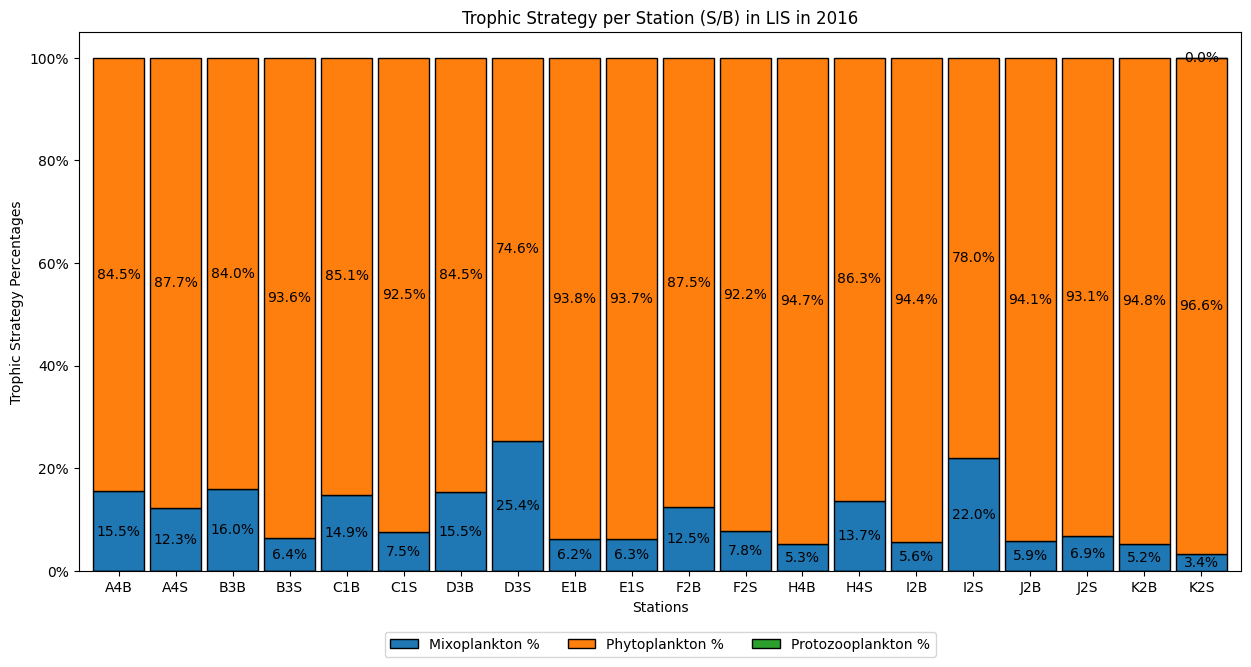

Station  Mixoplankton  Phytoplankton  Protozooplankton    Totals  \
0      A4B        770704        4199360                 0   4970064   
1      A4S        699512        4965708                 0   5665220   
2      B3B        588060        3085280                 0   3673340   
3      B3S        699512       10162108                 0  10861620   
4      C1B        536756        3067812                 0   3604568   
5      C1S        722964        8885976                 0   9608940   
6      D3B        456060        2489872                 0   2945932   
7      D3S        928224        2723160                 0   3651384   
8      E1B        140756        2137194                 0   2277950   
9      E1S        134816        2016168                 0   2150984   
10     F2B        391556        2745072                 0   3136628   
11     F2S        272756        3240732                 0   3513488   
12     H4B        161260        2857844                 0   3019104   
13     H4S        384208        2416436                 0   2800644   
14     I2B        287408        4818924                 0   5106332   
15     I2S        966460        3432968                 0   4399428   
16     J2B        149556        2393866                 0   2543422   
17     J2S        117304        1581932                 0   1699236   
18     K2B        117304        2139808                 0   2257112   
19     K2S        120164        3457828              1452   3579444   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        15.506923        84.493077            0.000000  
1        12.347482        87.652518            0.000000  
2        16.008864        83.991136            0.000000  
3         6.440218        93.559782            0.000000  
4        14.890994        85.109006            0.000000  
5         7.523868        92.476132            0.000000  
6        15.481009        84.518991            0.000000  
7        25.421155        74.578845            0.000000  
8         6.179065        93.820935            0.000000  
9         6.267643        93.732357            0.000000  
10       12.483342        87.516658            0.000000  
11        7.763112        92.236888            0.000000  
12        5.341320        94.658680            0.000000  
13       13.718559        86.281441            0.000000  
14        5.628463        94.371537            0.000000  
15       21.967856        78.032144            0.000000  
16        5.880110        94.119890            0.000000  
17        6.903338        93.096662            0.000000  
18        5.197084        94.802916            0.000000  
19        3.357058        96.602377            0.040565

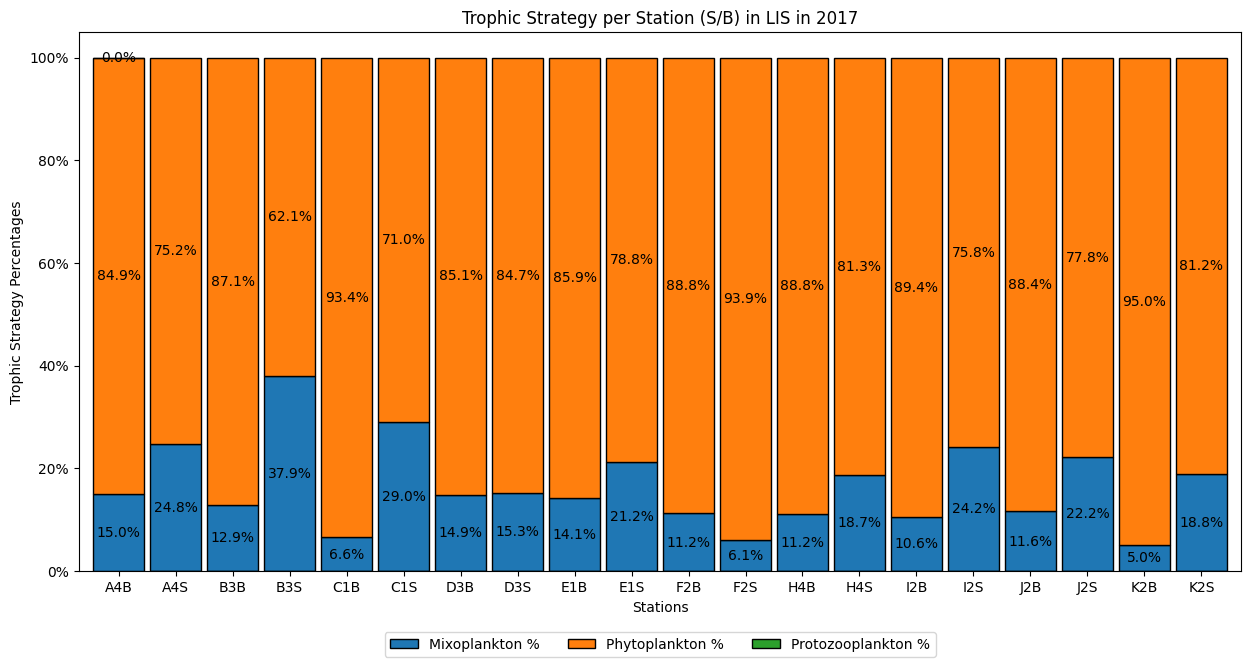

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B       1149808        6497524              1452  7648784   
1      A4S       2377408        7218992                 0  9596400   
2      B3B        838112        5679652                 0  6517764   
3      B3S       3431164        5622276                 0  9053440   
4      C1B        386452        5510340                 0  5896792   
5      C1S       1709268        4174852                 0  5884120   
6      D3B        987008        5649556                 0  6636564   
7      D3S       1013408        5631472                 0  6644880   
8      E1B        776512        4716668                 0  5493180   
9      E1S       1156364        4291496                 0  5447860   
10     F2B        674608        5335088                 0  6009696   
11     F2S        287408        4407436                 0  4694844   
12     H4B        500808        3969548                 0  4470356   
13     H4S        761156        3303872                 0  4065028   
14     I2B        375364        3181860                 0  3557224   
15     I2S        739826        2319416                 0  3059242   
16     J2B        391116        2979328                 0  3370444   
17     J2S        727364        2552660                 0  3280024   
18     K2B         99528        1877832                 0  1977360   
19     K2S        361416        1558832                 0  1920248   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        15.032559        84.948457            0.018983  
1        24.773957        75.226043            0.000000  
2        12.858888        87.141112            0.000000  
3        37.899009        62.100991            0.000000  
4         6.553597        93.446403            0.000000  
5        29.048830        70.951170            0.000000  
6        14.872274        85.127726            0.000000  
7        15.250960        84.749040            0.000000  
8        14.135929        85.864071            0.000000  
9        21.226023        78.773977            0.000000  
10       11.225327        88.774673            0.000000  
11        6.121780        93.878220            0.000000  
12       11.202866        88.797134            0.000000  
13       18.724496        81.275504            0.000000  
14       10.552161        89.447839            0.000000  
15       24.183311        75.816689            0.000000  
16       11.604287        88.395713            0.000000  
17       22.175569        77.824431            0.000000  
18        5.033378        94.966622            0.000000  
19       18.821319        81.178681            0.000000

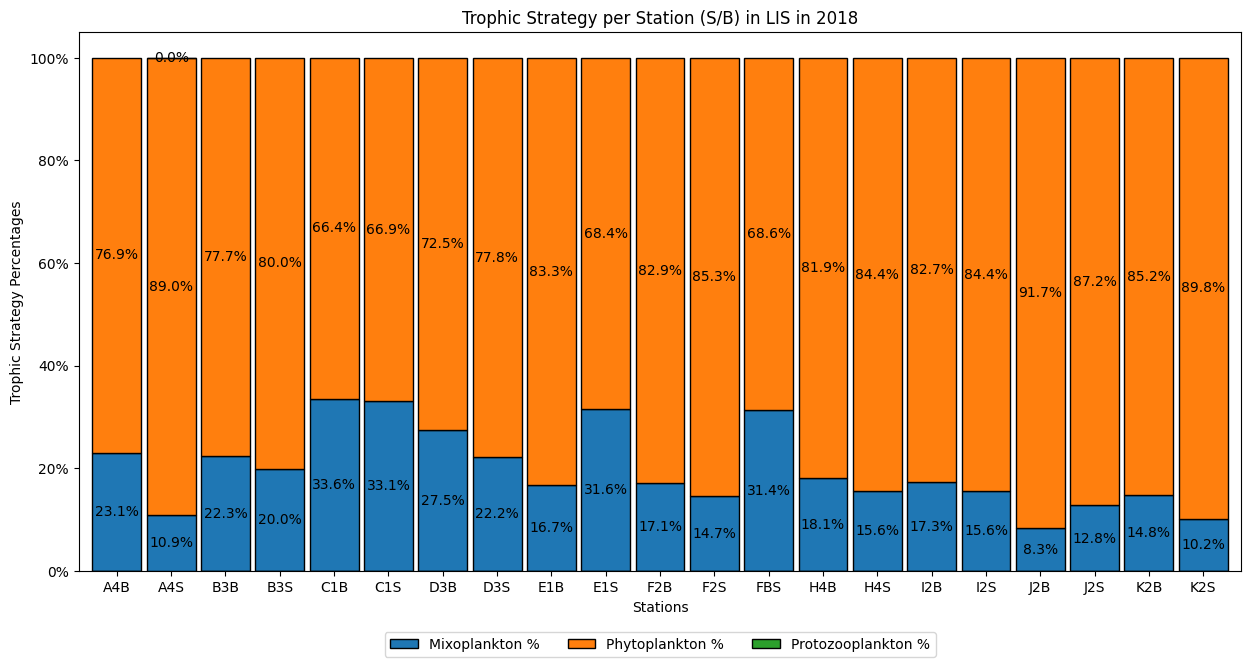

Station  Mixoplankton  Phytoplankton  Protozooplankton    Totals  \
0      A4B       1898468        6328696                 0   8227164   
1      A4S       1399464       11402292              2904  12804660   
2      B3B       1009008        3509792                 0   4518800   
3      B3S       2549184       10216360                 0  12765544   
4      C1B       1247312        2464660                 0   3711972   
5      C1S       2444024        4942674                 0   7386698   
6      D3B        666424        1758548                 0   2424972   
7      D3S       1141316        4003516                 0   5144832   
8      E1B        354152        1766732                 0   2120884   
9      E1S       1772408        3841420                 0   5613828   
10     F2B        566764        2738208                 0   3304972   
11     F2S        761860        4422000                 0   5183860   
12     FBS         17776          38764                 0     56540   
13     H4B        590260        2679644                 0   3269904   
14     H4S        507364        2754752                 0   3262116   
15     I2B        486860        2325356                 0   2812216   
16     I2S        624668        3378848                 0   4003516   
17     J2B        165924        1822656                 0   1988580   
18     J2S        320188        2182928                 0   2503116   
19     K2B        196812        1131416                 0   1328228   
20     K2S        248512        2187460                 0   2435972   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        23.075607        76.924393            0.000000  
1        10.929334        89.047987            0.022679  
2        22.329114        77.670886            0.000000  
3        19.969255        80.030745            0.000000  
4        33.602409        66.397591            0.000000  
5        33.086827        66.913173            0.000000  
6        27.481719        72.518281            0.000000  
7        22.183737        77.816263            0.000000  
8        16.698320        83.301680            0.000000  
9        31.572182        68.427818            0.000000  
10       17.148829        82.851171            0.000000  
11       14.696770        85.303230            0.000000  
12       31.439689        68.560311            0.000000  
13       18.051294        81.948706            0.000000  
14       15.553218        84.446782            0.000000  
15       17.312326        82.687674            0.000000  
16       15.602985        84.397015            0.000000  
17        8.343843        91.656157            0.000000  
18       12.791577        87.208423            0.000000  
19       14.817637        85.182363            0.000000  
20       10.201759        89.798241            0.000000

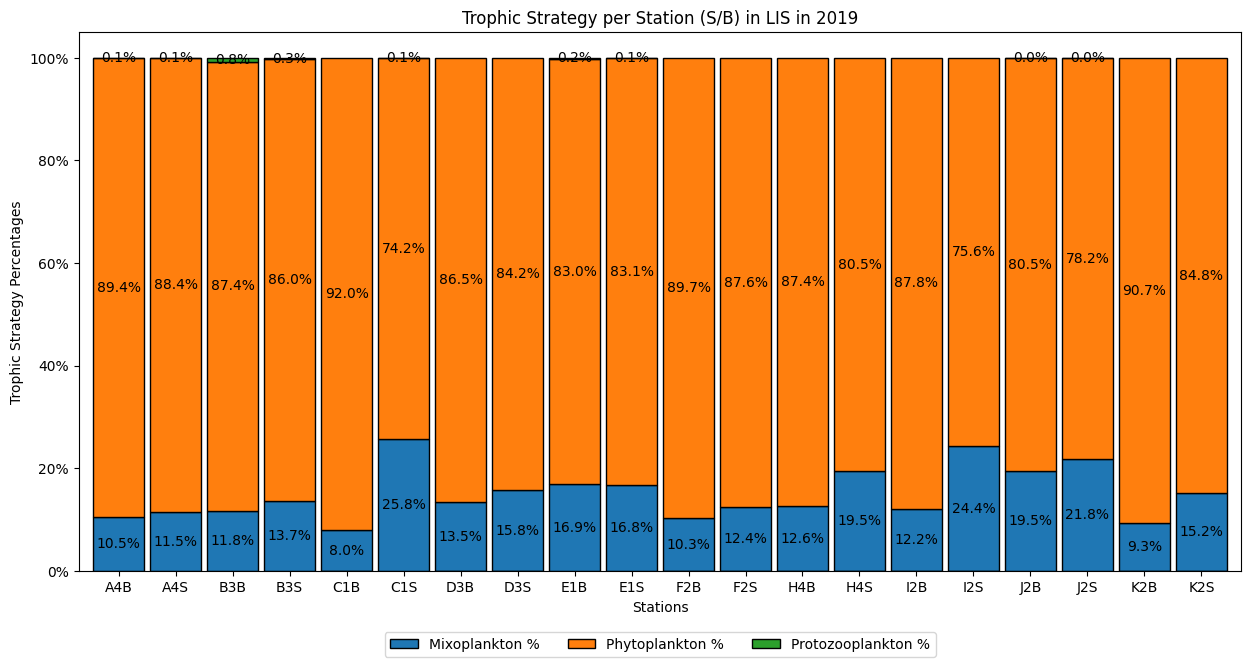

Station  Mixoplankton  Phytoplankton  Protozooplankton    Totals  \
0      A4B        976800        8324668              5852   9307320   
1      A4S       1338744       10284780              5852  11629376   
2      B3B        585068        4343196             39600   4967864   
3      B3S       1448920        9084372             29304  10562596   
4      C1B        467808        5355460                 0   5823268   
5      C1S       1749704        5034920              3960   6788584   
6      D3B        902308        5803072                 0   6705380   
7      D3S       1015080        5415520                 0   6430600   
8      E1B        932008        4579916              8800   5520724   
9      E1S        667964        3301804              4400   3974168   
10     F2B        511940        4468904                 0   4980844   
11     F2S        798644        5620076                 0   6418720   
12     H4B        647812        4474228                 0   5122040   
13     H4S        786456        3253474                 0   4039930   
14     I2B        450120        3253184                 0   3703304   
15     I2S        888360        2758536                 0   3646896   
16     J2B        489280        2020656               176   2510112   
17     J2S        475288        1701172               176   2176636   
18     K2B         93412         910360                 0   1003772   
19     K2S        318604        1772144                 0   2090748   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        10.494965        89.442160            0.062875  
1        11.511744        88.437935            0.050321  
2        11.777053        87.425823            0.797123  
3        13.717461        86.005107            0.277432  
4         8.033427        91.966573            0.000000  
5        25.774212        74.167455            0.058333  
6        13.456478        86.543522            0.000000  
7        15.785152        84.214848            0.000000  
8        16.881989        82.958612            0.159399  
9        16.807644        83.081641            0.110715  
10       10.278178        89.721822            0.000000  
11       12.442418        87.557582            0.000000  
12       12.647539        87.352461            0.000000  
13       19.467070        80.532930            0.000000  
14       12.154552        87.845448            0.000000  
15       24.359346        75.640654            0.000000  
16       19.492357        80.500631            0.007012  
17       21.835897        78.156017            0.008086  
18        9.306097        90.693903            0.000000  
19       15.238757        84.761243            0.000000

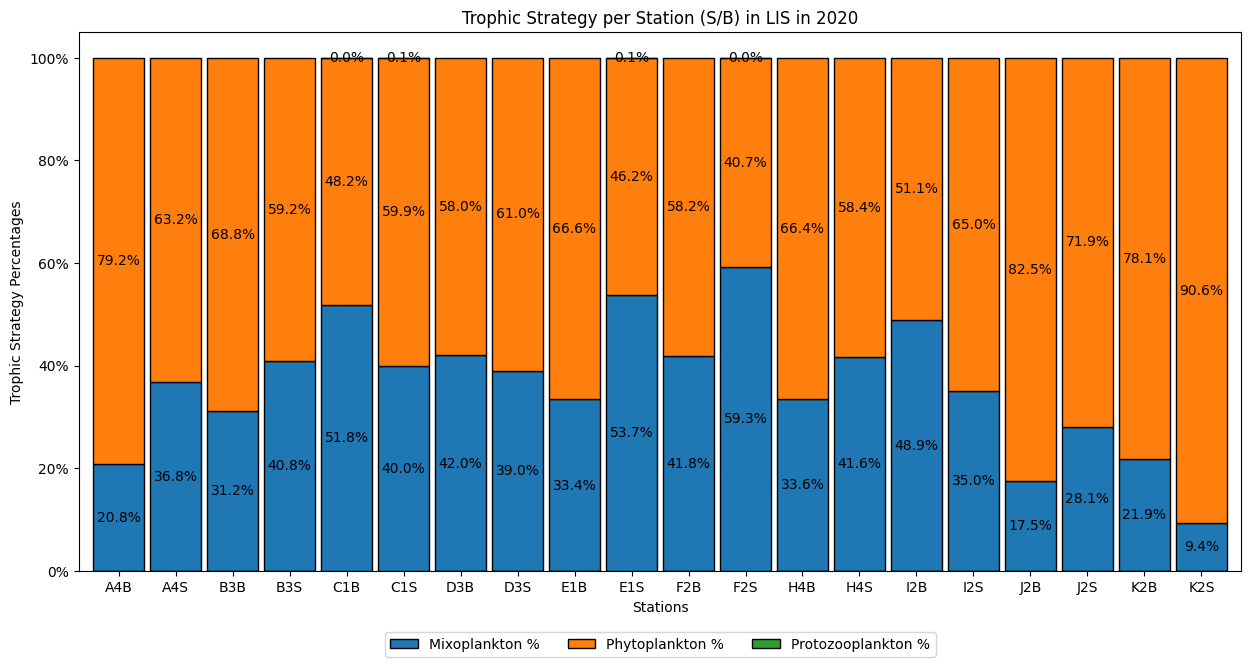

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        193600         738012                 0   931612   
1      A4S       1708828        2930268                 0  4639096   
2      B3B        384252         849244                 0  1233496   
3      B3S       1849760        2678984                 0  4528744   
4      C1B        690800         642840                44  1333684   
5      C1S       1391060        2082344              2904  3476308   
6      D3B        551452         761288                 0  1312740   
7      D3S        717156        1119756                 0  1836912   
8      E1B        224444         446908                 0   671352   
9      E1S       1847384        1588488              2904  3438776   
10     F2B        453244         630696                 0  1083940   
11     F2S       1430308         982256                88  2412652   
12     H4B        437140         865788                 0  1302928   
13     H4S       1211848        1699544                 0  2911392   
14     I2B        737264         770528                 0  1507792   
15     I2S        688556        1276396                 0  1964952   
16     J2B        124652         588280                 0   712932   
17     J2S        304260         777436                 0  1081696   
18     K2B        141724         506748                 0   648472   
19     K2S         90112         871156                 0   961268   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        20.781184        79.218816            0.000000  
1        36.835366        63.164634            0.000000  
2        31.151459        68.848541            0.000000  
3        40.844879        59.155121            0.000000  
4        51.796378        48.200323            0.003299  
5        40.015442        59.901021            0.083537  
6        42.007709        57.992291            0.000000  
7        39.041391        60.958609            0.000000  
8        33.431642        66.568358            0.000000  
9        53.722138        46.193413            0.084449  
10       41.814492        58.185508            0.000000  
11       59.283643        40.712709            0.003647  
12       33.550588        66.449412            0.000000  
13       41.624350        58.375650            0.000000  
14       48.896930        51.103070            0.000000  
15       35.041874        64.958126            0.000000  
16       17.484416        82.515584            0.000000  
17       28.128051        71.871949            0.000000  
18       21.855069        78.144931            0.000000  
19        9.374285        90.625715            0.000000

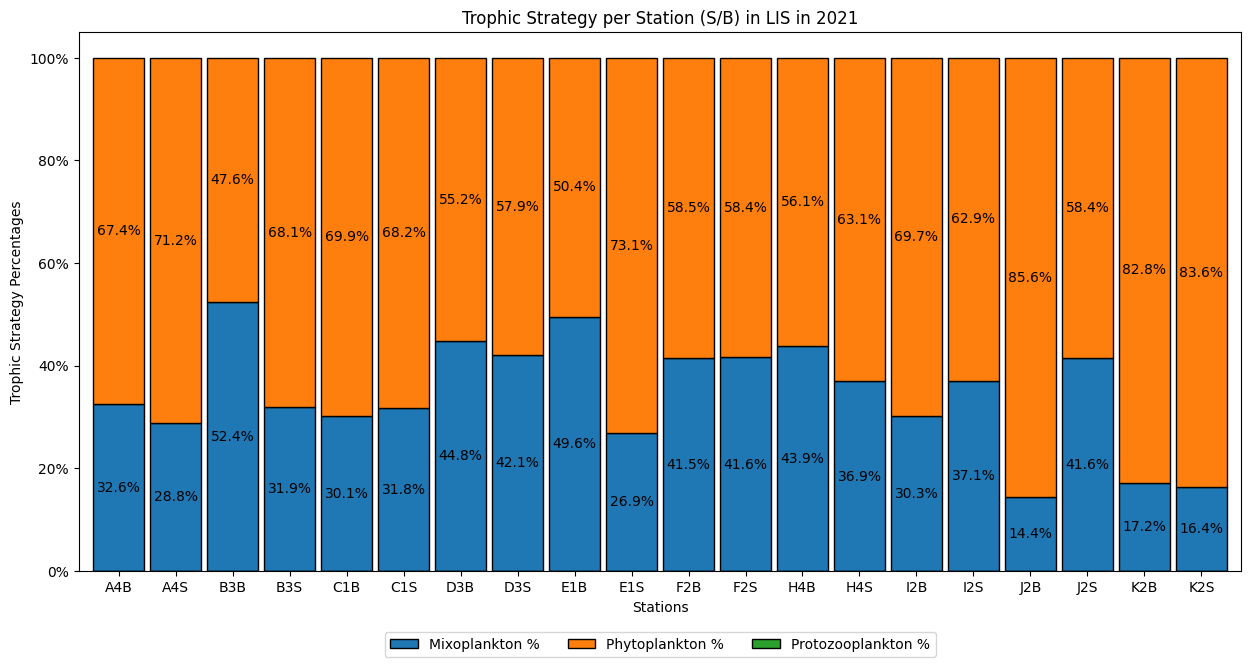

Station  Mixoplankton  Phytoplankton  Protozooplankton   Totals  \
0      A4B        867460        1795728                 0  2663188   
1      A4S       1906388        4704304                 0  6610692   
2      B3B       1293952        1174096                 0  2468048   
3      B3S       2325180        4954488                 0  7279668   
4      C1B        512204        1187780                 0  1699984   
5      C1S       1750672        3749416                 0  5500088   
6      D3B        727364         896940                 0  1624304   
7      D3S        806256        1109372                 0  1915628   
8      E1B        955108         972400                 0  1927508   
9      E1S        305360         827948                 0  1133308   
10     F2B        596772         841984                 0  1438756   
11     F2S        949300        1332452                 0  2281752   
12     H4B        783860        1002364                 0  1786224   
13     H4S        701756        1197724                 0  1899480   
14     I2B        651508        1499784                 0  2151292   
15     I2S        544412         923340                 0  1467752   
16     J2B        226864        1347104                 0  1573968   
17     J2S        965360        1355948                 0  2321308   
18     K2B        183656         883520                 0  1067176   
19     K2S        169224         862576                 0  1031800   

    Mixoplankton %  Phytoplankton %  Protozooplankton %  
0        32.572240        67.427760                 0.0  
1        28.837949        71.162051                 0.0  
2        52.428154        47.571846                 0.0  
3        31.940742        68.059258                 0.0  
4        30.129931        69.870069                 0.0  
5        31.829891        68.170109                 0.0  
6        44.780041        55.219959                 0.0  
7        42.088339        57.911661                 0.0  
8        49.551442        50.448558                 0.0  
9        26.944132        73.055868                 0.0  
10       41.478333        58.521667                 0.0  
11       41.603996        58.396004                 0.0  
12       43.883634        56.116366                 0.0  
13       36.944637        63.055363                 0.0  
14       30.284499        69.715501                 0.0  
15       37.091552        62.908448                 0.0  
16       14.413508        85.586492                 0.0  
17       41.586898        58.413102                 0.0  
18       17.209532        82.790468                 0.0  
19       16.400853        83.599147                 0.0

In [20]:
# Percentage of PLankton Trophic Strategy per Station
for csv_name in csvs:
    # Get pie chart for each year
    yearly_trophic_strategy_per_station(csv_name)

In [21]:
# Total cells/L per Plankton Trophic Strategy
def trophic_strategy_for_total_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'
    
    # Clean Data
    classified = Classifier(csv_name)
    df = classified.all_classified
    df.loc[df['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    df = df.replace(['No', 'Yes'], ['Phytoplankton', 'Mixoplankton'])
    counts = percentages(df, 'Status')

    # Pie Chart
    plt.title(f"Total cells/L per Plankton Type in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['Status'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(counts)

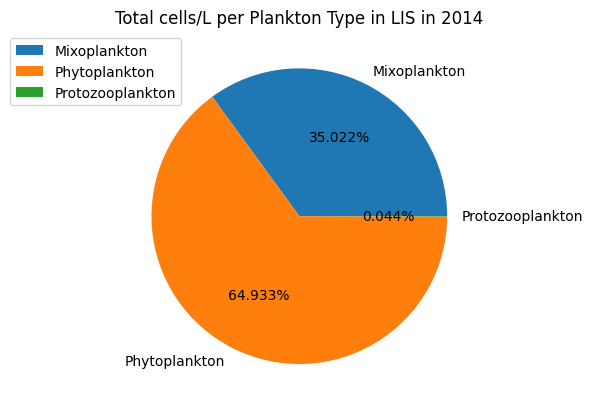

Status    Totals Percentages
0      Mixoplankton  30159886   35.022426
1     Phytoplankton  55917979   64.933378
2  Protozooplankton     38060    0.044196

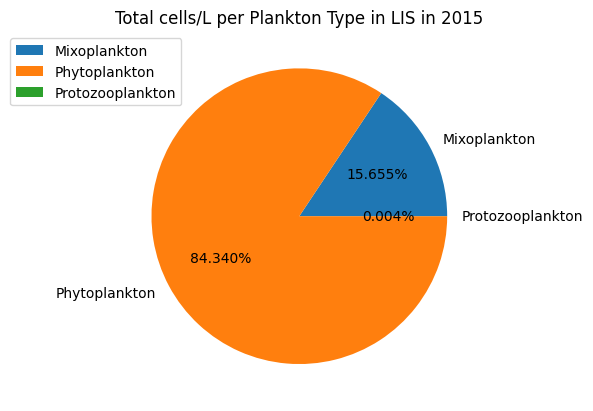

Status     Totals Percentages
0      Mixoplankton   21243460   15.655346
1     Phytoplankton  114445293   84.340341
2  Protozooplankton       5852    0.004313

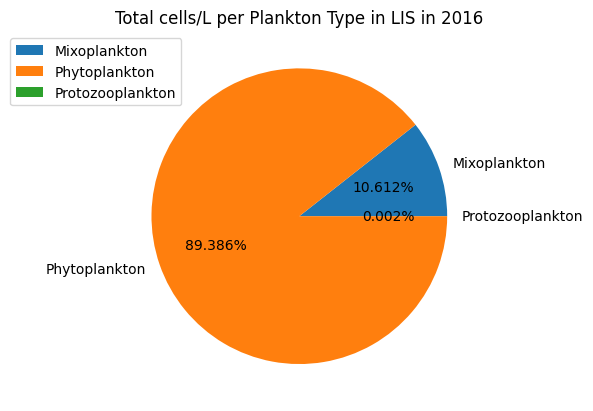

Status    Totals Percentages
0      Mixoplankton   8645340   10.612357
1     Phytoplankton  72818048    89.38586
2  Protozooplankton      1452    0.001782

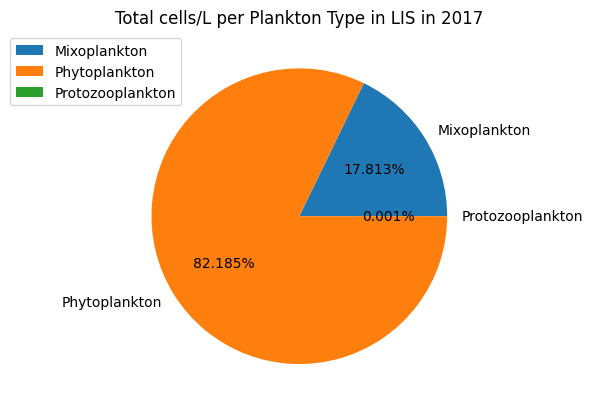

Status    Totals Percentages
0      Mixoplankton  18744098   17.813477
1     Phytoplankton  86478700   82.185143
2  Protozooplankton      1452     0.00138

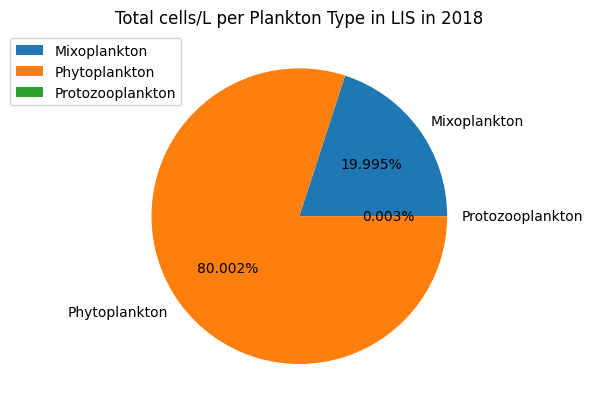

Status    Totals Percentages
0      Mixoplankton  18968748   19.994807
1     Phytoplankton  75896722   80.002132
2  Protozooplankton      2904    0.003061

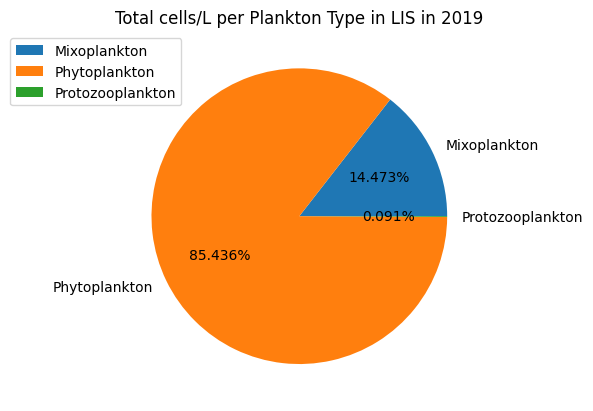

Status    Totals Percentages
0      Mixoplankton  15544320   14.472908
1     Phytoplankton  91760442   85.435735
2  Protozooplankton     98120    0.091357

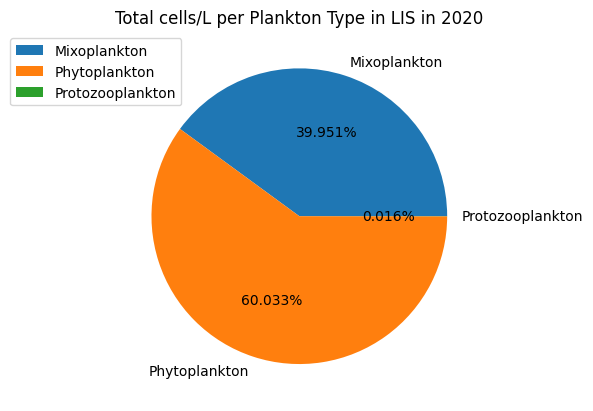

Status    Totals Percentages
0      Mixoplankton  15177844   39.951426
1     Phytoplankton  22806960   60.032939
2  Protozooplankton      5940    0.015635

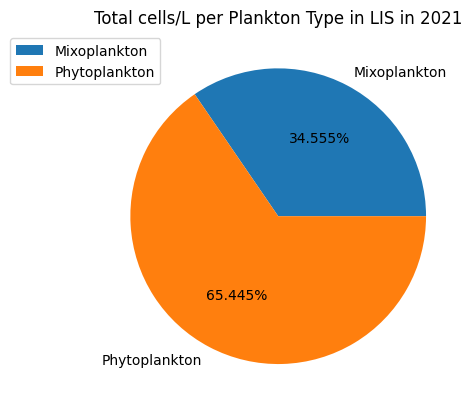

Status    Totals Percentages
0   Mixoplankton  17222656   34.554557
1  Phytoplankton  32619268   65.445443

In [22]:
# Percentage of PLankton Trophic Strategy per Station
for csv_name in csvs:
    # Get pie chart for each year
    trophic_strategy_for_total_pie(csv_name)

## 2. What different types of mixoplankton are present and what is their relative abundance?

In [23]:
def mixoplankton_type_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean Data
    classified = Classifier(csv_name)
    df = classified.mixoplankton_with_header
    df = df.loc[:, ~df.columns.get_level_values(2).isin(['Status', 'Phylum', 'Genus', 'Species', 'Evidence of mixoplankton activity', 'size class', 'Totals'])]
    df.columns = df.columns.get_level_values(1)
    df = pd.concat([df[[np.nan]], df.groupby(df.columns.str[0], axis=1).sum()], axis=1).rename(columns= {np.nan:'MFT'}).groupby('MFT').sum().reset_index()
    df['Totals'] = df.iloc[:, 1:].sum(axis=1)
    df = df[df['Totals'] != 0]
    df['Percentages'] = ((df['Totals'] / df['Totals'].sum()) * 100)

    # Pie Chart
    plt.title(f"Mixoplankton Functional Type in LIS in {year}")
    plt.pie(df['Percentages'], labels=df['MFT'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(df)

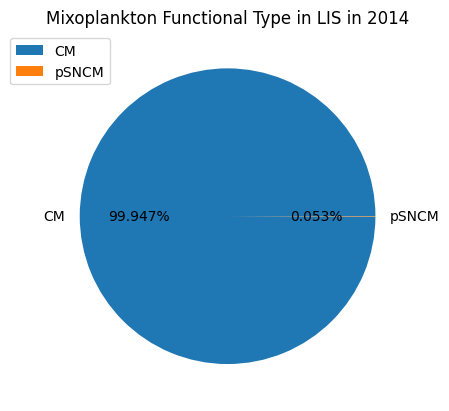

MFT        A        B        C        D        E        F        H  \
0     CM  5844292  4432120  3338016  3766312  2747844  1862432  3319982   
2  pSNCM     2904     4400     4400        0        0     2904        0   

         I        J        K    Totals  Percentages  
0  1829652  1758372  1244804  30143826     99.94675  
2     1452        0        0     16060      0.05325

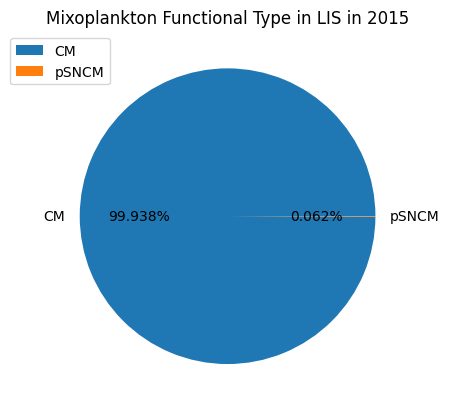

MFT        A        B        C        D        E        F        H  \
0     CM  2735304  3808464  2933612  2466772  1778744  3059408  1440600   
2  pSNCM        0     5852     5852        0     1452        0        0   

         I        J       K    Totals  Percentages  
0  1224740  1133044  649616  21230304     99.93807  
2        0        0       0     13156      0.06193

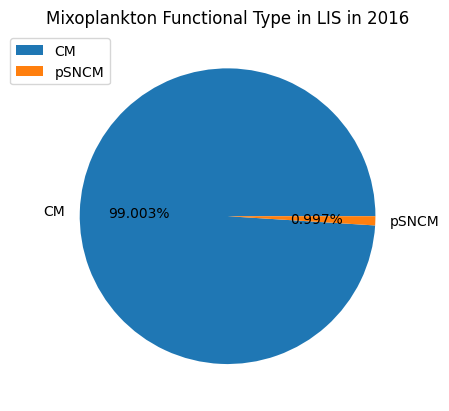

MFT        A        B        C        D       E       F       H        I  \
0     CM  1458512  1270060  1249512  1378476  263868  649660  542564  1243616   
2  pSNCM    11704    17512    10208     5808   11704   14652    2904    10252   

        J       K   Totals  Percentages  
0  265408  237468  8559144    99.002977  
2    1452       0    86196     0.997023

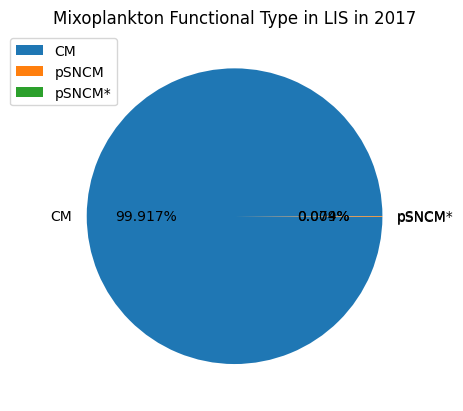

MFT        A        B        C        D        E       F        H  \
0      CM  3525764  4267120  2090660  1998964  1930720  962016  1261964   
2   pSNCM     1452     2156     5060     1452     1452       0        0   
3  pSNCM*        0        0        0        0      704       0        0   

         I        J       K    Totals  Percentages  
0  1113034  1117424  460944  18728610    99.917371  
2     2156     1056       0     14784     0.078873  
3        0        0       0       704     0.003756

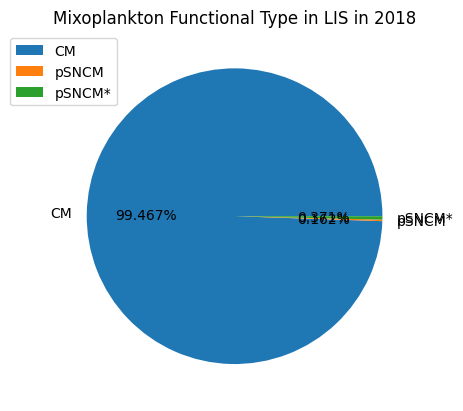

MFT        A        B        C        D        E        F        H  \
0      CM  3296524  3553176  3687024  1734876  2125108  1332496  1096920   
2   pSNCM     1408     5016     4312     2464     1452    13904      704   
3  pSNCM*        0        0        0    70400        0        0        0   

         I       J       K    Totals  Percentages  
0  1110824  485760  444972  18867680    99.467187  
2      704     352     352     30668     0.161676  
3        0       0       0     70400     0.371137

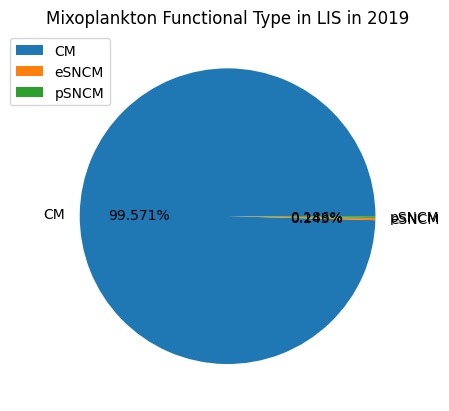

MFT        A        B        C        D        E        F        H  \
0     CM  2311760  2020788  2215576  1917212  1598520  1304380  1403116   
1  eSNCM        0        0        0        0        0        0    30800   
2  pSNCM     3784    13200     1936      176     1452     6204      352   

         I       J       K    Totals  Percentages  
0  1335884  958540  411840  15477616    99.570879  
1      792    6028     176     37796     0.243150  
2     1804       0       0     28908     0.185971

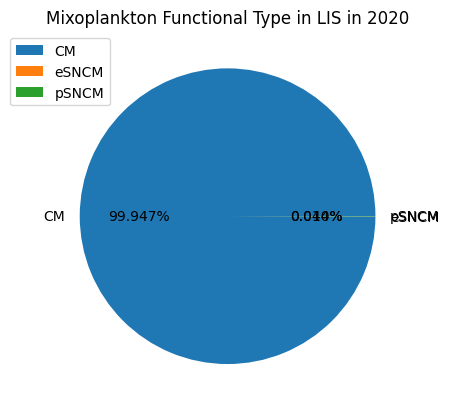

MFT        A        B        C        D        E        F        H  \
0     CM  1902428  2233836  2078956  1265704  2071740  1883552  1648812   
1  eSNCM        0        0        0        0        0        0        0   
2  pSNCM        0      176     2904     2904       88        0      176   

         I       J       K    Totals  Percentages  
0  1425644  428824  230252  15169748    99.946659  
1        0       0    1452      1452     0.009567  
2      176      88     132      6644     0.043774

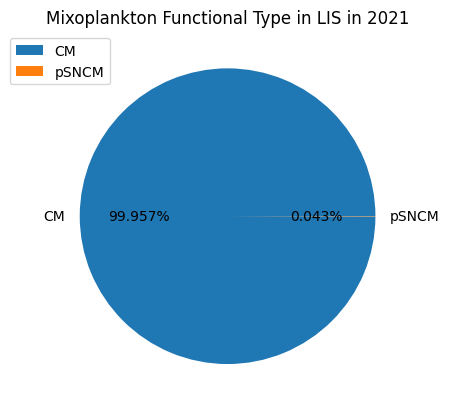

MFT        A        B        C        D        E        F        H  \
0     CM  2773056  3616976  2259972  1532564  1260468  1545720  1485616   
2  pSNCM      792     2156     2904     1056        0      352        0   

         I        J       K    Totals  Percentages  
0  1195920  1192136  352792  17215220    99.956824  
2        0       88      88      7436     0.043176

In [24]:
for csv_name in csvs:
    # Get pie chart for each year
    mixoplankton_type_pie(csv_name)

## 3. For just the dinoflagellates, what fraction are phyto vs mixo vs heterotrophs?  
### All of the dinoflagellates that are in the genus Protoperidinium are strict heterotrophs. They only use phagocytosis for nutrition and are not capable of photosynthesis. They get counted in these kinds of monitoring programs just because the person doing the counting sees them but they are not phytoplankton at all.

In [25]:
def trophic_strategy_for_dinoflagellates_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean Data
    classified = Classifier(csv_name)
    df = classified.all_classified
    df = df.loc[df['Phylum'] == 'Dinoflagellate']
    df.loc[df['Genus']=='Protoperidinium', 'Status'] = 'Protozooplankton'
    df = df.replace('No', 'Phytoplankton')
    df = df.replace('Yes', 'Mixoplankton')
    counts = percentages(df, 'Status')
    
    # Pie Chart
    plt.title(f"Trophic Strategy of Dinoflagellates in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['Status'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(counts)

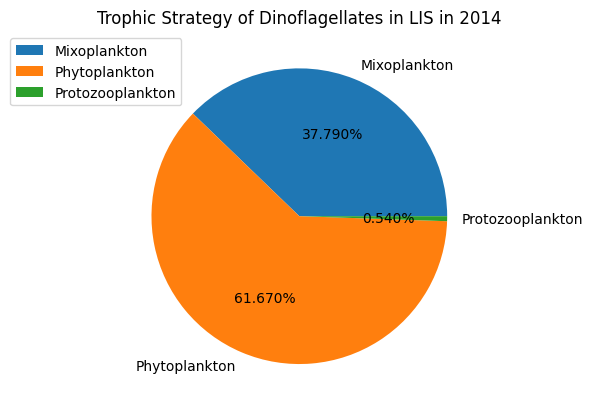

Status   Totals Percentages
0      Mixoplankton  2663104   37.790295
1     Phytoplankton  4345894   61.669622
2  Protozooplankton    38060    0.540084

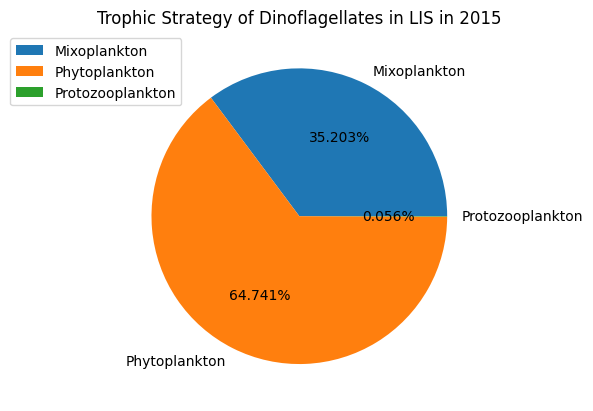

Status   Totals Percentages
0      Mixoplankton  3659608   35.202836
1     Phytoplankton  6730316   64.740872
2  Protozooplankton     5852    0.056292

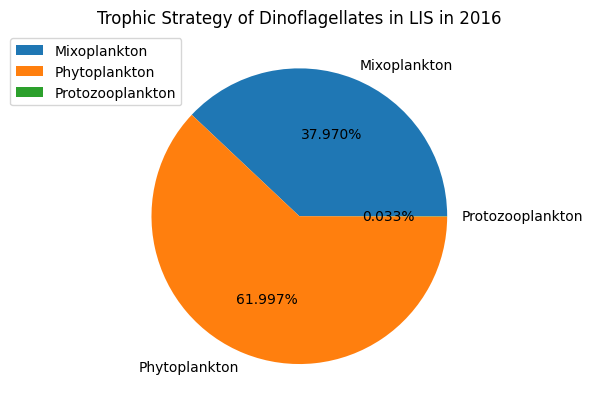

Status   Totals Percentages
0      Mixoplankton  1666984   37.969914
1     Phytoplankton  2721840   61.997013
2  Protozooplankton     1452    0.033073

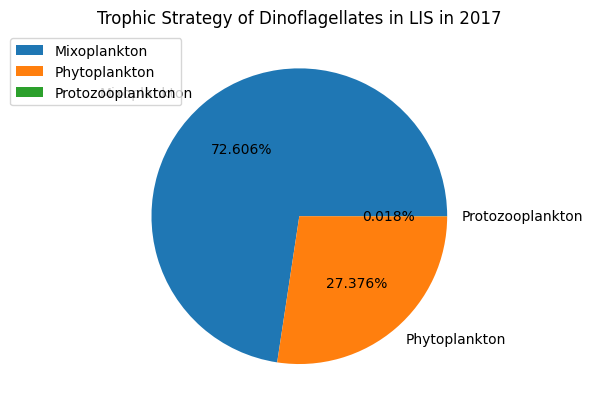

Status   Totals Percentages
0      Mixoplankton  5965212   72.606092
1     Phytoplankton  2249192   27.376234
2  Protozooplankton     1452    0.017673

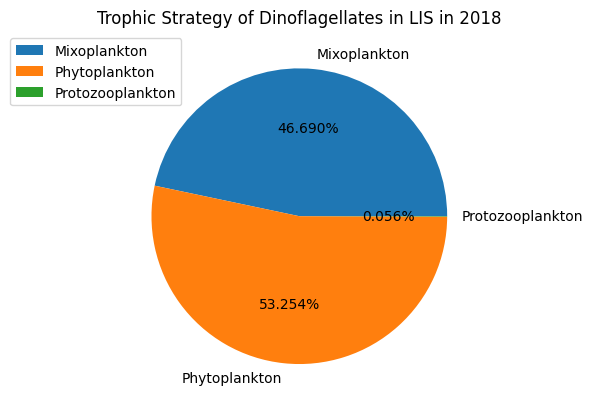

Status   Totals Percentages
0      Mixoplankton  2429984   46.689734
1     Phytoplankton  2771648   53.254469
2  Protozooplankton     2904    0.055797

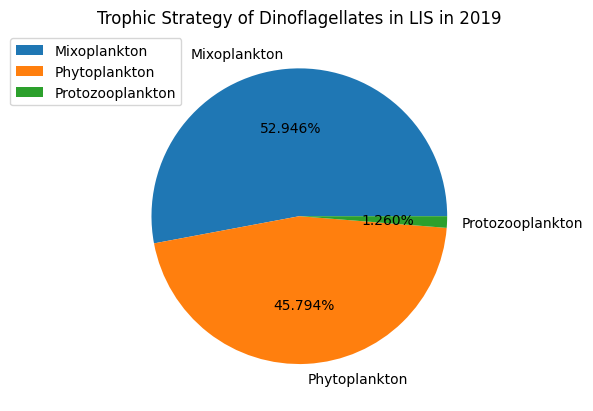

Status   Totals Percentages
0      Mixoplankton  4122976   52.946218
1     Phytoplankton  3566006    45.79375
2  Protozooplankton    98120    1.260032

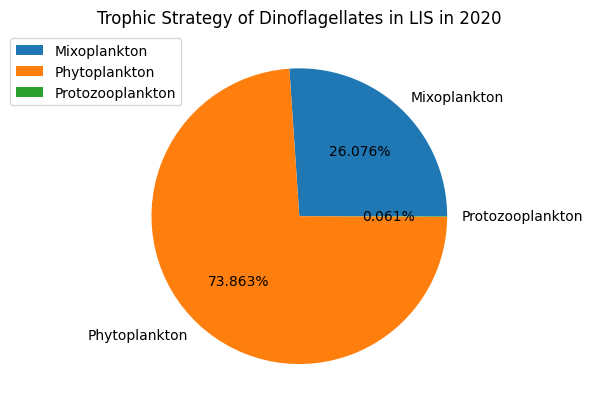

Status   Totals Percentages
0      Mixoplankton  2522476   26.075941
1     Phytoplankton  7145160   73.862654
2  Protozooplankton     5940    0.061404

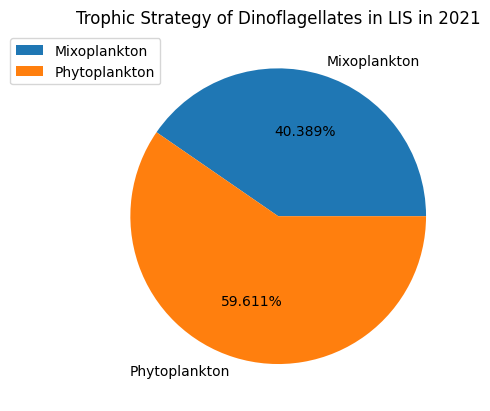

Status   Totals Percentages
0   Mixoplankton  1538592    40.38948
1  Phytoplankton  2270796    59.61052

In [26]:
for csv_name in csvs:
    # Get pie chart for each year
    trophic_strategy_for_dinoflagellates_pie(csv_name)

## 4. What fraction of mixoplankton are nano size and micro size?

In [27]:
def mixoplankton_sizes_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean data
    classified = Classifier(csv_name)
    df = classified.mixoplankton
    counts = percentages(df, 'size class')
    
    # Pie Chart
    plt.title(f"Relative Size of Mixoplankton in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['size class'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.2, 1))
    
    plt.show()
    display(counts)

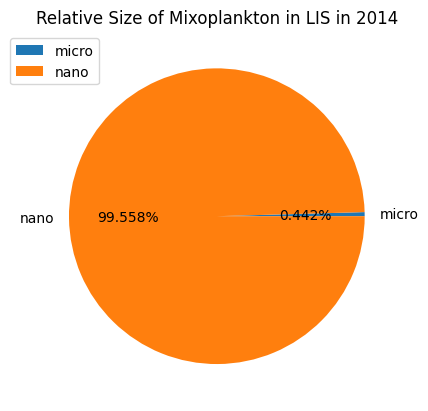

size class    Totals Percentages
1      micro    133320    0.442044
2       nano  30026566   99.557956

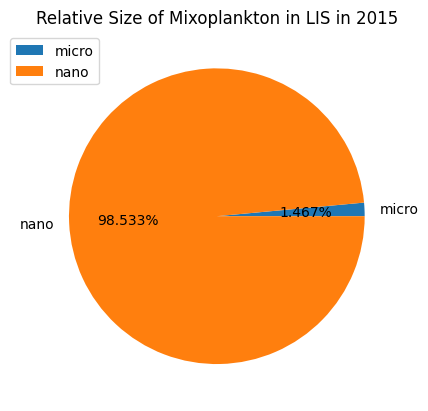

size class    Totals Percentages
1      micro    311564    1.466635
2       nano  20931896   98.533365

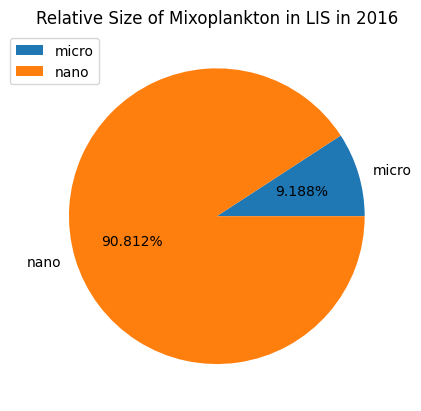

size class   Totals Percentages
1      micro   794376    9.188488
2       nano  7850964   90.811512

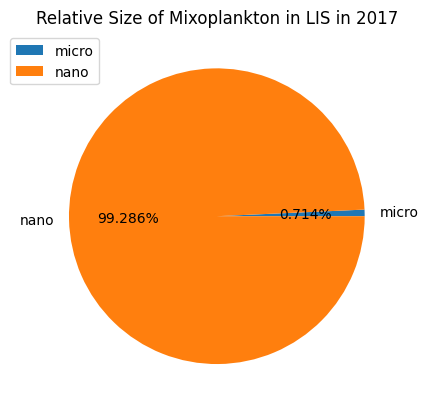

size class    Totals Percentages
1      micro    133760    0.713611
2       nano  18610338   99.286389

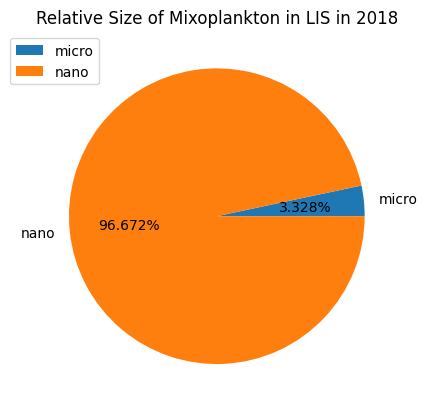

size class    Totals Percentages
1      micro    631312    3.328169
2       nano  18337436   96.671831

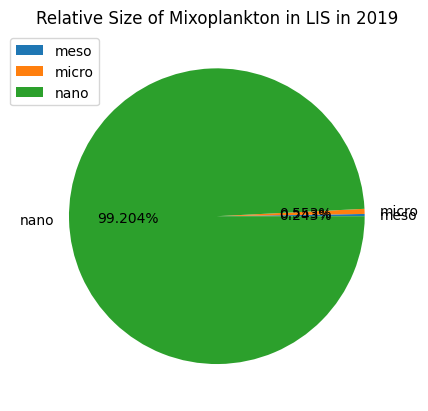

size class    Totals Percentages
0       meso     37796     0.24315
1      micro     85976    0.553102
2       nano  15420548   99.203748

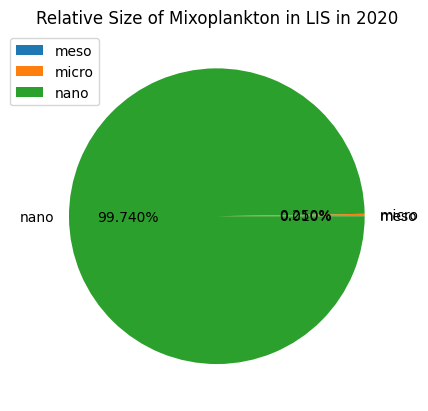

size class    Totals Percentages
0       meso      1452    0.009567
1      micro     37972     0.25018
2       nano  15138420   99.740253

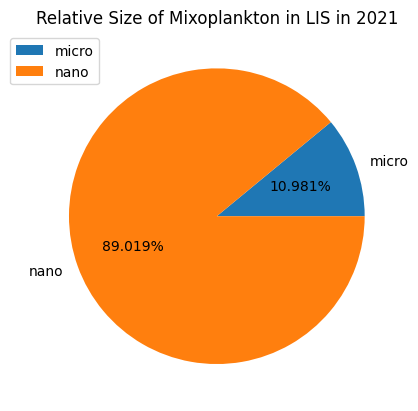

size class    Totals Percentages
1      micro   1891252   10.981187
2       nano  15331404   89.018813

In [28]:
for csv_name in csvs:
    # Get pie chart for each year
    mixoplankton_sizes_pie(csv_name)

## 5. What proportion of the mixoplankton are dinoflagellates?

In [29]:
def mixoplankton_phylums_pie(csv_name):
    # Get year
    year = re.search(r'\b(\d{4})\b', csv_name).group(1) if re.search(r'\b(\d{4})\b', csv_name) else 'Year not found'

    # Clean data
    classified = Classifier(csv_name)
    df = classified.mixoplankton
    counts = percentages(df, 'Phylum')
    
    # Pie Chart
    plt.title(f"Relative Abundance of Mixoplankton Phylum in LIS in {year}")
    plt.pie(counts['Percentages'], labels=counts['Phylum'], autopct='%1.3f%%')
    plt.legend(bbox_to_anchor=(.19, 1))
    
    plt.show()
    display(counts)

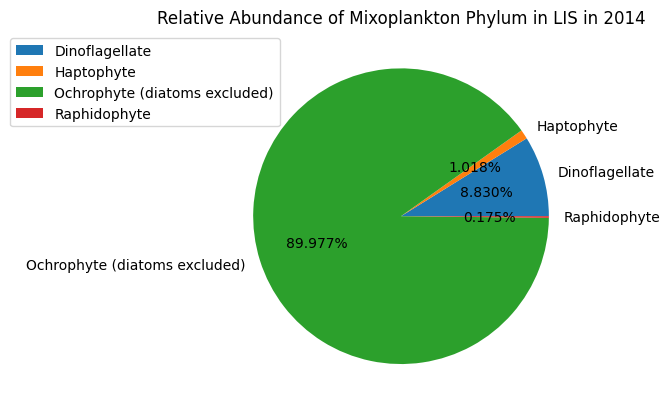

Phylum    Totals Percentages
0                 Dinoflagellate   2663104    8.829954
1                     Haptophyte    307089    1.018203
2  Ochrophyte (diatoms excluded)  27136849    89.97663
3                   Raphidophyte     52844    0.175213

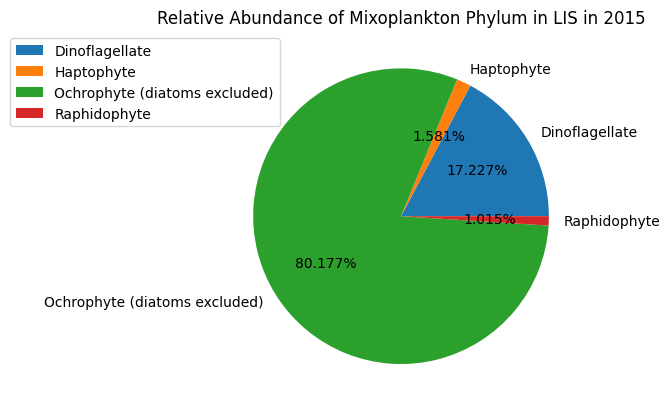

Phylum    Totals Percentages
0                 Dinoflagellate   3659608   17.226987
1                     Haptophyte    335852    1.580967
2  Ochrophyte (diatoms excluded)  17032400   80.177146
3                   Raphidophyte    215600    1.014901

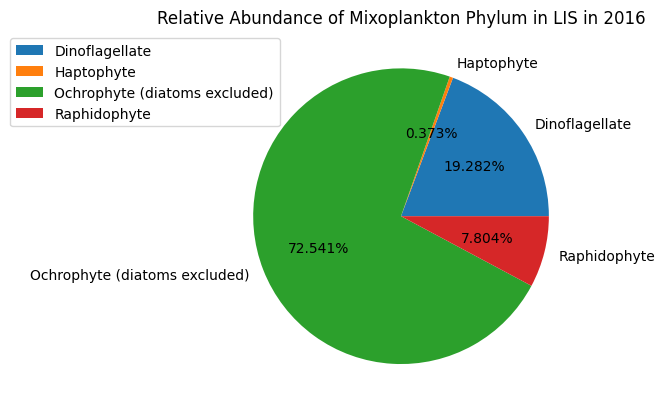

Phylum   Totals Percentages
0                 Dinoflagellate  1666984   19.281879
1                     Haptophyte    32252    0.373056
2  Ochrophyte (diatoms excluded)  6271452   72.541415
3                   Raphidophyte   674652    7.803649

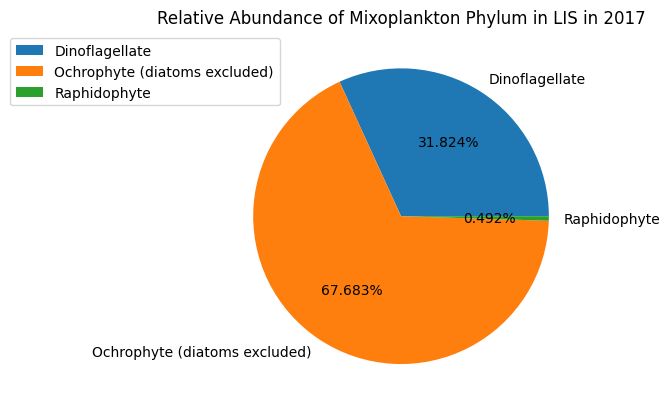

Phylum    Totals Percentages
0                 Dinoflagellate   5965212   31.824481
2  Ochrophyte (diatoms excluded)  12686618   67.683268
3                   Raphidophyte     92268    0.492251

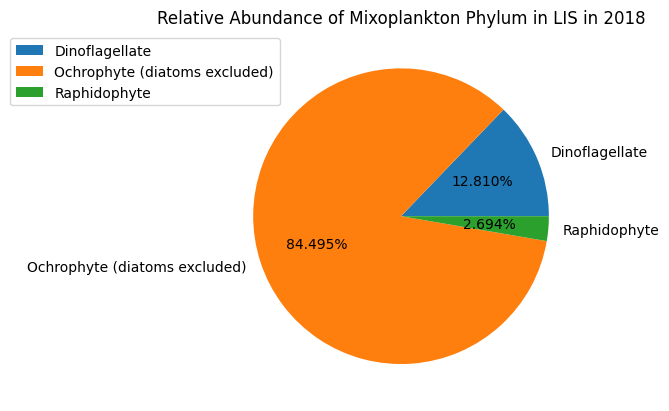

Phylum    Totals Percentages
0                 Dinoflagellate   2429984   12.810461
2  Ochrophyte (diatoms excluded)  16027660   84.495086
3                   Raphidophyte    511104    2.694453

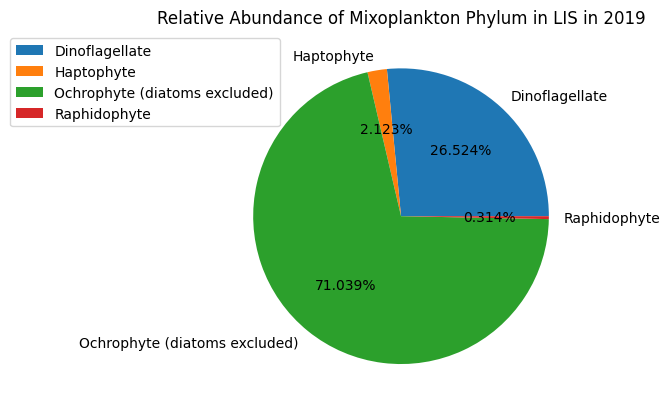

Phylum    Totals Percentages
0                 Dinoflagellate   4122976   26.524004
1                     Haptophyte    330000    2.122962
2  Ochrophyte (diatoms excluded)  11042460   71.038553
3                   Raphidophyte     48884    0.314481

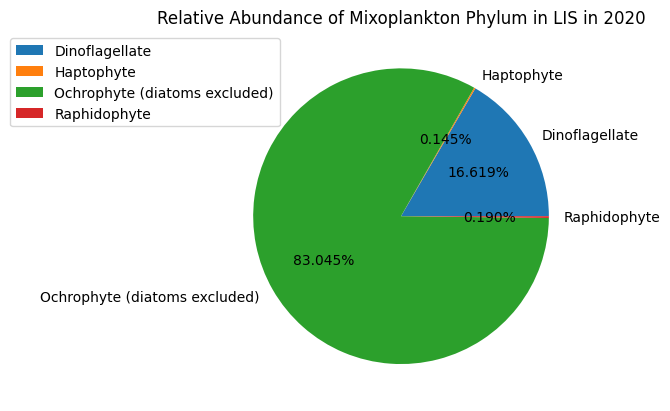

Phylum    Totals Percentages
0                 Dinoflagellate   2522476   16.619462
1                     Haptophyte     22000    0.144948
2  Ochrophyte (diatoms excluded)  12604504   83.045418
3                   Raphidophyte     28864    0.190172

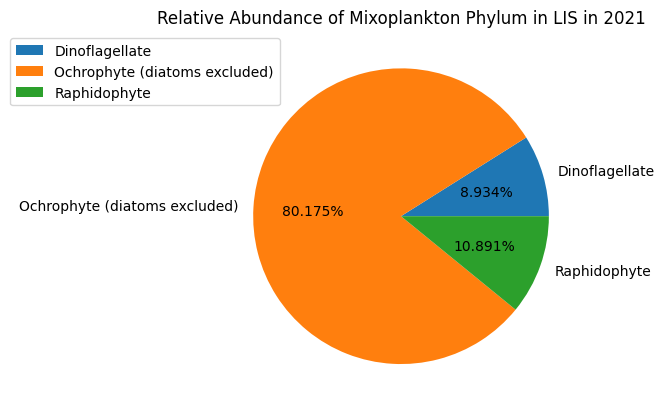

Phylum    Totals Percentages
0                 Dinoflagellate   1538592    8.933535
2  Ochrophyte (diatoms excluded)  13808344   80.175462
3                   Raphidophyte   1875720   10.891003

In [30]:
for csv_name in csvs:
    # Get pie chart for each year
    mixoplankton_phylums_pie(csv_name)